<a href="https://colab.research.google.com/github/probml/pyprobml/blob/master/notebooks/Covid/covid_open_data_paper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Covid-open-data paper


This colab shows how to use the [Covid19-open-data](https://github.com/GoogleCloudPlatform/covid-19-open-data) repository. We use the [v3 schema](https://docs.google.com/document/d/119NjmUMYs2a2rdO_cL5gnCK331BxG7nXzuGj5mUam_c/edit?resourcekey=0-c9vlXgdUekrqfc1HOxCAMQ#).
We focus on the static 2020 snapshot of the dataset.




In [70]:
from typing import Callable, List, Tuple
import pandas as pd
import seaborn
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns;
from IPython.display import display, HTML
import math

from typing import List
import pandas as pd
from tqdm.notebook import tqdm
from datetime import datetime,timedelta

from sklearn.metrics import r2_score, mean_squared_error


import matplotlib.pyplot as plt
import seaborn
seaborn.set()
seaborn.set_style("whitegrid")

plt.rcParams.update({'font.size': 48, 'legend.fontsize': 18})
plt.rc('xtick',labelsize=14)
plt.rc('ytick',labelsize=14)

pd.options.display.width = 1200
pd.options.display.max_colwidth = 100
pd.options.display.max_columns = 100

# Metadata for each individual table

In [5]:
# individual data tables 
ROOT = 'https://storage.googleapis.com/covid19-open-data/v3'
# set default_na=False to prevent reading of records with key "NA" (Namibia) as NaN
READ_OPTS = dict(na_values=[''], keep_default_na=False, sep=',', engine='c')

def read_table(name, nrows=None):
  URL = f'{ROOT}/{name}.csv'
  print('reading ', URL)
  if nrows:
    df = pd.read_csv(URL, nrows=nrows, **READ_OPTS)
  else:
    df = pd.read_csv(URL, **READ_OPTS)
  return df



In [36]:
# Extract column names for each table
table_names = ['index', 'epidemiology', 'hospitalizations', 'by-age', 'by-sex',
            'lawatlas-emergency-declarations', 'oxford-government-response', 
            'weather', 'mobility',   'google-search-trends',
           'demographics', 'economy',   'geography', 'health', 'worldbank']

table_cols = {}
table_ncols = {}
table_static = {}
for i, table in enumerate(table_names):
  df = read_table(table, nrows=0) # header only
  cols = list(df.columns)
  cols.remove('location_key') # every table has a location_key
  if 'date' in cols:
    cols.remove('date')
    is_static = False
  else:
    is_static = True
  table_static[table] = is_static
  ncols = len(cols)
  table_cols[table] = cols
  table_ncols[table] = ncols

print(table_ncols)
print(table_static)
print(table_cols)

reading  https://storage.googleapis.com/covid19-open-data/v3/index.csv
reading  https://storage.googleapis.com/covid19-open-data/v3/epidemiology.csv
reading  https://storage.googleapis.com/covid19-open-data/v3/hospitalizations.csv
reading  https://storage.googleapis.com/covid19-open-data/v3/by-age.csv


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (148,149,150,151) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


reading  https://storage.googleapis.com/covid19-open-data/v3/by-sex.csv
reading  https://storage.googleapis.com/covid19-open-data/v3/lawatlas-emergency-declarations.csv
reading  https://storage.googleapis.com/covid19-open-data/v3/oxford-government-response.csv
reading  https://storage.googleapis.com/covid19-open-data/v3/weather.csv
reading  https://storage.googleapis.com/covid19-open-data/v3/mobility.csv
reading  https://storage.googleapis.com/covid19-open-data/v3/google-search-trends.csv
reading  https://storage.googleapis.com/covid19-open-data/v3/demographics.csv
reading  https://storage.googleapis.com/covid19-open-data/v3/economy.csv
reading  https://storage.googleapis.com/covid19-open-data/v3/geography.csv
reading  https://storage.googleapis.com/covid19-open-data/v3/health.csv
reading  https://storage.googleapis.com/covid19-open-data/v3/worldbank.csv
{'index': 13, 'epidemiology': 8, 'hospitalizations': 9, 'by-age': 150, 'by-sex': 28, 'lawatlas-emergency-declarations': 102, 'oxford-

In [7]:
for table, cols in table_cols.items():
  print(table)
  print(cols)

index
['wikidata_id', 'datacommons_id', 'country_code', 'country_name', 'subregion1_code', 'subregion1_name', 'subregion2_code', 'subregion2_name', 'locality_code', 'locality_name', 'iso_3166_1_alpha_2', 'iso_3166_1_alpha_3', 'aggregation_level']
epidemiology
['new_confirmed', 'new_deceased', 'new_recovered', 'new_tested', 'cumulative_confirmed', 'cumulative_deceased', 'cumulative_recovered', 'cumulative_tested']
hospitalizations
['new_hospitalized', 'cumulative_hospitalized', 'current_hospitalized', 'new_intensive_care', 'cumulative_intensive_care', 'current_intensive_care', 'new_ventilator', 'cumulative_ventilator', 'current_ventilator']
by-age
['new_confirmed_age_0', 'new_confirmed_age_1', 'new_confirmed_age_2', 'new_confirmed_age_3', 'new_confirmed_age_4', 'new_confirmed_age_5', 'new_confirmed_age_6', 'new_confirmed_age_7', 'new_confirmed_age_8', 'new_confirmed_age_9', 'cumulative_confirmed_age_0', 'cumulative_confirmed_age_1', 'cumulative_confirmed_age_2', 'cumulative_confirmed_ag

In [37]:
c = table_cols['google-search-trends']
c2 = [s for s in c if not s.startswith('search_trends')]
print(c2)


[]


In [38]:
table_sources = {}
for t in table_names:
  table_sources[t] = ['Various']
table_sources['index'] = ['Wikidata', 'Eurostat']
table_sources['economy'] = ['Wikidata', 'Eurostat']
table_sources['lawatlas-emergency-declarations'] = ['Lawatlas Project']
table_sources['geography'] = ['Wikidata']
table_sources['health'] = ['Wikidata', 'Wordlbank', 'Eurostat']
table_sources['mobility'] = ['Google']
table_sources['google-search-trends'] = ['Google']
table_sources['oxford-government-response'] = ['U. Oxford']
table_sources['weather'] = ['NOAA']
table_sources['worldbank'] = ['Worldbank']


A = set(table_names)
B = set(table_sources.keys())
print(B-A)

set()


In [39]:
table_text = {}
table_text['index'] = 'Name of each location'
table_text['demographics'] = 'Current population statistics'
table_text['economy'] = 'Current economic indicators'
table_text['epidemiology'] = 'New and cumulative cases, deaths, tests, recoveries'
table_text['lawatlas-emergency-declarations'] = 'Government mandates'
table_text['geography'] = 'Spatial information'
table_text['health'] = 'Current health indicators'
table_text['hospitalizations'] = 'New and cumulative data for COVID patients'
table_text['mobility'] = 'Relative amount of movement to location types'
table_text['google-search-trends'] = 'Relative trends in COVID-related search terms'
table_text['oxford-government-response'] = 'Government mandates'
table_text['weather'] = 'Metereological information'
table_text['worldbank'] = 'Latest economic indicators'
table_text['by-age'] = 'Epidemiological and hospitalization data stratified by age'
table_text['by-sex'] = 'Epidemiological and hospitalization data stratified by sex'


In [41]:




df = pd.DataFrame({'Table': table_names,
                   '#columns': [table_ncols[t] for t in table_names],  
                   'Static': [table_static[t] for t in table_names], 
                   'Content': [table_text[t] for t in table_names],
                   'Sources': [table_sources[t] for t in table_names]
                   })

print(df.dtypes)
#df = df.style.set_properties(**{'text-align': 'left'}) 
display(df) 


Table       object
#columns     int64
Static        bool
Content     object
Sources     object
dtype: object


,Table,#columns,Static,Content,Sources
0,index,13,True,Name of each location,"[Wikidata, Eurostat]"
1,epidemiology,8,False,"New and cumulative cases, deaths, tests, recoveries",[Various]
2,hospitalizations,9,False,New and cumulative data for COVID patients,[Various]
3,by-age,150,False,Epidemiological and hospitalization data stratified by age,[Various]
4,by-sex,28,False,Epidemiological and hospitalization data stratified by sex,[Various]
5,lawatlas-emergency-declarations,102,False,Government mandates,[Lawatlas Project]
6,oxford-government-response,20,False,Government mandates,[U. Oxford]
7,weather,7,False,Metereological information,[NOAA]
8,mobility,6,False,Relative amount of movement to location types,[Google]
9,google-search-trends,422,False,Relative trends in COVID-related search terms,[Google]


In [42]:
print(df.to_latex(index=False)) 

\begin{tabular}{lrlll}
\toprule
                           Table &  \#columns &  Static &                                                     Content &                          Sources \\
\midrule
                           index &        13 &    True &                                       Name of each location &             [Wikidata, Eurostat] \\
                    epidemiology &         8 &   False &         New and cumulative cases, deaths, tests, recoveries &                        [Various] \\
                hospitalizations &         9 &   False &                  New and cumulative data for COVID patients &                        [Various] \\
                          by-age &       150 &   False &  Epidemiological and hospitalization data stratified by age &                        [Various] \\
                          by-sex &        28 &   False &  Epidemiological and hospitalization data stratified by sex &                        [Various] \\
 lawatlas-emergency-declarat

# Aggregated table

The aggregated table is a join of the following tables:

- index
- epidemiology
- hospitalizations
- by-age
- by-sex
- demographics
- economy
- geography
- health
- mobility
- oxford-government-response
- google-search-trends
- weather

Thus it omits the following tables, which are very wide:

- lawatlas-emergency-declarations
- worldbank

In [11]:
# read aggregated data table
!wget -qq 'https://storage.googleapis.com/covid19-open-data/paper/aggregated-2020.csv.gz'

FILE_NAME = 'aggregated-2020.csv.gz'
# set default_na=False to prevent reading of records with key "NA" (Namibia) as NaN
READ_OPTS = dict(na_values=[''], keep_default_na=False, sep=',', engine='c')

COLUMNS = list(pd.read_csv(FILE_NAME, nrows=0, **READ_OPTS).columns) # header only
print(COLUMNS)
print(len(COLUMNS))



['location_key', 'date', 'wikidata_id', 'datacommons_id', 'country_code', 'country_name', 'iso_3166_1_alpha_2', 'iso_3166_1_alpha_3', 'aggregation_level', 'new_confirmed', 'new_deceased', 'cumulative_confirmed', 'cumulative_deceased', 'cumulative_tested', 'population', 'population_male', 'population_female', 'population_rural', 'population_urban', 'population_density', 'human_development_index', 'population_age_00_09', 'population_age_10_19', 'population_age_20_29', 'population_age_30_39', 'population_age_40_49', 'population_age_50_59', 'population_age_60_69', 'population_age_70_79', 'population_age_80_and_older', 'gdp_usd', 'gdp_per_capita_usd', 'openstreetmap_id', 'latitude', 'longitude', 'area_sq_km', 'smoking_prevalence', 'diabetes_prevalence', 'infant_mortality_rate', 'nurses_per_1000', 'physicians_per_1000', 'health_expenditure_usd', 'out_of_pocket_health_expenditure_usd', 'school_closing', 'workplace_closing', 'cancel_public_events', 'restrictions_on_gatherings', 'public_transpo

In [12]:
# extract columns from local copy of aggregated table

def read_data(columns: List[str]) -> pd.DataFrame:
  columns = ['location_key', 'date', 'aggregation_level', 'population'] + columns
  return pd.read_csv(FILE_NAME, usecols=columns, **READ_OPTS)

# Geo-index

In [11]:
df_index = read_table('index')
print(df_index.shape)
df_index.head()

reading  https://storage.googleapis.com/covid19-open-data/v3/index.csv
(22024, 14)


,location_key,wikidata_id,datacommons_id,country_code,country_name,subregion1_code,subregion1_name,subregion2_code,subregion2_name,locality_code,locality_name,iso_3166_1_alpha_2,iso_3166_1_alpha_3,aggregation_level
0,AD,Q228,country/AND,AD,Andorra,NaN,NaN,NaN,NaN,NaN,NaN,AD,AND,0
1,AE,Q878,country/ARE,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,NaN,AE,ARE,0
2,AF,Q889,country/AFG,AF,Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,AF,AFG,0
3,AF_BAL,Q121104,NaN,AF,Afghanistan,BAL,Balkh,NaN,NaN,NaN,NaN,AF,AFG,1
4,AF_BAM,Q171382,NaN,AF,Afghanistan,BAM,Bamyan,NaN,NaN,NaN,NaN,AF,AFG,1


In [12]:
print(table_cols['index'])

['wikidata_id', 'datacommons_id', 'country_code', 'country_name', 'subregion1_code', 'subregion1_name', 'subregion2_code', 'subregion2_name', 'locality_code', 'locality_name', 'iso_3166_1_alpha_2', 'iso_3166_1_alpha_3', 'aggregation_level']


In [13]:
geo_keys_level  = [] # geo_keys_level[i] = [list of keys at level i]
geo_nkeys_level = [] # geo_keys_level[i] = number of keys at level i
for level in range(4):
  keys = df_index.location_key[df_index.aggregation_level==level].to_numpy()
  n = len(keys)
  geo_keys_level.append(keys)
  geo_nkeys_level.append(n)

geo_nkeys_level = np.array(geo_nkeys_level)

print(geo_nkeys_level)
print(np.sum(geo_nkeys_level[0:3]))
print(np.sum(geo_nkeys_level))

[  246  1390 20356    32]
21992
22024


In [14]:
def key_level(key):
  matches = df_index[df_index.location_key==key]
  if len(matches) != 1:
    print(f'key_level: cannot find location {key} in index')
    return -1 
  tmp = matches.iloc[0] # first row
  level = tmp.aggregation_level
  return level
  
def key_name(key):
  matches = df_index[df_index.location_key==key]
  if len(matches) != 1:
    print(f'key_name: cannot find location {key} in index')
    return key 
  tmp = matches.iloc[0] # first row
  level = tmp.aggregation_level
  if level == 0:
    return('{} ({})'.format(key, tmp.country_name))
  elif level == 1:
    return('{} ({}-{})'.format(key, tmp.country_name, tmp.subregion1_name))
  elif level == 2:
    return('{} ({}-{}-{})'.format(key, tmp.country_name, tmp.subregion1_name, tmp.subregion2_name))




In [15]:
print(key_name('CA'))
print(key_name('CA_BC'))
print(key_name('CA_BC_5940'))

print(key_name('GZ'))

CA (Canada)
CA_BC (Canada-British Columbia)
CA_BC_5940 (Canada-British Columbia-Vancouver Island)
key_name: cannot find location GZ in index
GZ


## Level 0 (country)

In [ ]:

countries = geo_keys_level[0]
print(len(countries))
print(countries)

246
['AD' 'AE' 'AF' 'AG' 'AI' 'AL' 'AM' 'AN' 'AO' 'AQ' 'AR' 'AS' 'AT' 'AU'
 'AW' 'AZ' 'BA' 'BB' 'BD' 'BE' 'BF' 'BG' 'BH' 'BI' 'BJ' 'BM' 'BN' 'BO'
 'BQ' 'BR' 'BS' 'BT' 'BV' 'BW' 'BY' 'BZ' 'CA' 'CC' 'CD' 'CF' 'CG' 'CH'
 'CI' 'CK' 'CL' 'CM' 'CN' 'CO' 'CR' 'CU' 'CV' 'CW' 'CX' 'CY' 'CZ' 'DE'
 'DJ' 'DK' 'DM' 'DO' 'DZ' 'EC' 'EE' 'EG' 'EH' 'ER' 'ES' 'ET' 'FI' 'FJ'
 'FK' 'FM' 'FO' 'FR' 'GA' 'GB' 'GD' 'GE' 'GF' 'GG' 'GH' 'GI' 'GL' 'GM'
 'GN' 'GQ' 'GR' 'GS' 'GT' 'GU' 'GW' 'GY' 'HK' 'HM' 'HN' 'HR' 'HT' 'HU'
 'ID' 'IE' 'IL' 'IM' 'IN' 'IO' 'IQ' 'IR' 'IS' 'IT' 'JE' 'JM' 'JO' 'JP'
 'KE' 'KG' 'KH' 'KI' 'KM' 'KN' 'KP' 'KR' 'KW' 'KY' 'KZ' 'LA' 'LB' 'LC'
 'LI' 'LK' 'LR' 'LS' 'LT' 'LU' 'LV' 'LY' 'MA' 'MC' 'MD' 'ME' 'MG' 'MH'
 'MK' 'ML' 'MM' 'MN' 'MO' 'MP' 'MQ' 'MR' 'MS' 'MT' 'MU' 'MV' 'MW' 'MX'
 'MY' 'MZ' 'NA' 'NC' 'NE' 'NF' 'NG' 'NI' 'NL' 'NO' 'NP' 'NR' 'NU' 'NZ'
 'OM' 'PA' 'PE' 'PF' 'PG' 'PH' 'PK' 'PL' 'PN' 'PR' 'PS' 'PT' 'PW' 'PY'
 'QA' 'RE' 'RO' 'RS' 'RU' 'RW' 'SA' 'SB' 'SC' 'SD' 'SE' 'SG' 'SH' 'SI'
 '

## Level 1 (state)

In [ ]:
def compute_states_per_country():
  keys = df_index['location_key']
  countries = set()
  states_per_country = {}
  def parse_key(key):
    parts = key.split('_')
    level = len(parts)-1
    if level==0:
      countries.add(key)
    elif level==1:
      country = parts[0]
      state = parts[1]
      try:
        states_per_country[country].add(key)
      except:
        states_per_country[country] = {key}

  for k in keys:
    parse_key(k)
    
  return states_per_country

states_per_country = compute_states_per_country()

In [ ]:
# 5 US territories: American Samoa (AS), Guam (GU), Northern Mariana Islands (MP), Puerto Rico (PR), U.S. Virgin Islands (VI).
# DC
print(len(states_per_country['US']))
print(states_per_country['US'])

56
{'US_WA', 'US_DC', 'US_ND', 'US_KS', 'US_MP', 'US_MD', 'US_AZ', 'US_NC', 'US_NY', 'US_SD', 'US_NE', 'US_WV', 'US_WY', 'US_NH', 'US_NV', 'US_ME', 'US_DE', 'US_KY', 'US_VI', 'US_UT', 'US_MA', 'US_LA', 'US_MN', 'US_MS', 'US_MI', 'US_IA', 'US_PR', 'US_GU', 'US_AL', 'US_VT', 'US_WI', 'US_AR', 'US_TX', 'US_GA', 'US_RI', 'US_ID', 'US_VA', 'US_IL', 'US_MO', 'US_CT', 'US_CA', 'US_OH', 'US_PA', 'US_CO', 'US_OR', 'US_AS', 'US_OK', 'US_MT', 'US_TN', 'US_AK', 'US_SC', 'US_NJ', 'US_IN', 'US_FL', 'US_HI', 'US_NM'}


In [ ]:
nstates_per_country = {} 
for i, c in enumerate(countries):
  states = states_per_country.get(c, [])
  nstates_per_country[c] = len(states)

print(nstates_per_country)
nstates_per_country = {k: v for k, v in sorted(nstates_per_country.items(), key=lambda item: -item[1])} # largest first
print(nstates_per_country)

nstates_per_country_nonzero = {key_name(k): v for k, v in nstates_per_country.items() if v>0}
print(len(nstates_per_country_nonzero)) # 62 countries have state-level info
print(nstates_per_country_nonzero)



{'AD': 0, 'AE': 0, 'AF': 34, 'AG': 0, 'AI': 0, 'AL': 0, 'AM': 0, 'AN': 0, 'AO': 0, 'AQ': 0, 'AR': 24, 'AS': 0, 'AT': 9, 'AU': 8, 'AW': 0, 'AZ': 0, 'BA': 0, 'BB': 0, 'BD': 8, 'BE': 11, 'BF': 0, 'BG': 0, 'BH': 0, 'BI': 0, 'BJ': 0, 'BM': 0, 'BN': 0, 'BO': 9, 'BQ': 0, 'BR': 27, 'BS': 0, 'BT': 0, 'BV': 0, 'BW': 0, 'BY': 0, 'BZ': 0, 'CA': 13, 'CC': 0, 'CD': 30, 'CF': 0, 'CG': 0, 'CH': 26, 'CI': 0, 'CK': 0, 'CL': 16, 'CM': 0, 'CN': 31, 'CO': 33, 'CR': 7, 'CU': 17, 'CV': 0, 'CW': 0, 'CX': 0, 'CY': 0, 'CZ': 14, 'DE': 16, 'DJ': 0, 'DK': 0, 'DM': 0, 'DO': 32, 'DZ': 0, 'EC': 24, 'EE': 15, 'EG': 0, 'EH': 0, 'ER': 0, 'ES': 19, 'ET': 0, 'FI': 0, 'FJ': 0, 'FK': 0, 'FM': 0, 'FO': 0, 'FR': 21, 'GA': 0, 'GB': 13, 'GD': 0, 'GE': 0, 'GF': 0, 'GG': 0, 'GH': 0, 'GI': 0, 'GL': 0, 'GM': 0, 'GN': 0, 'GQ': 0, 'GR': 0, 'GS': 0, 'GT': 22, 'GU': 0, 'GW': 0, 'GY': 0, 'HK': 0, 'HM': 0, 'HN': 18, 'HR': 0, 'HT': 10, 'HU': 0, 'ID': 34, 'IE': 0, 'IL': 7, 'IM': 0, 'IN': 35, 'IO': 0, 'IQ': 19, 'IR': 0, 'IS': 0, 'IT': 21, '

Text(0.5, 0, '# states (level 1)')

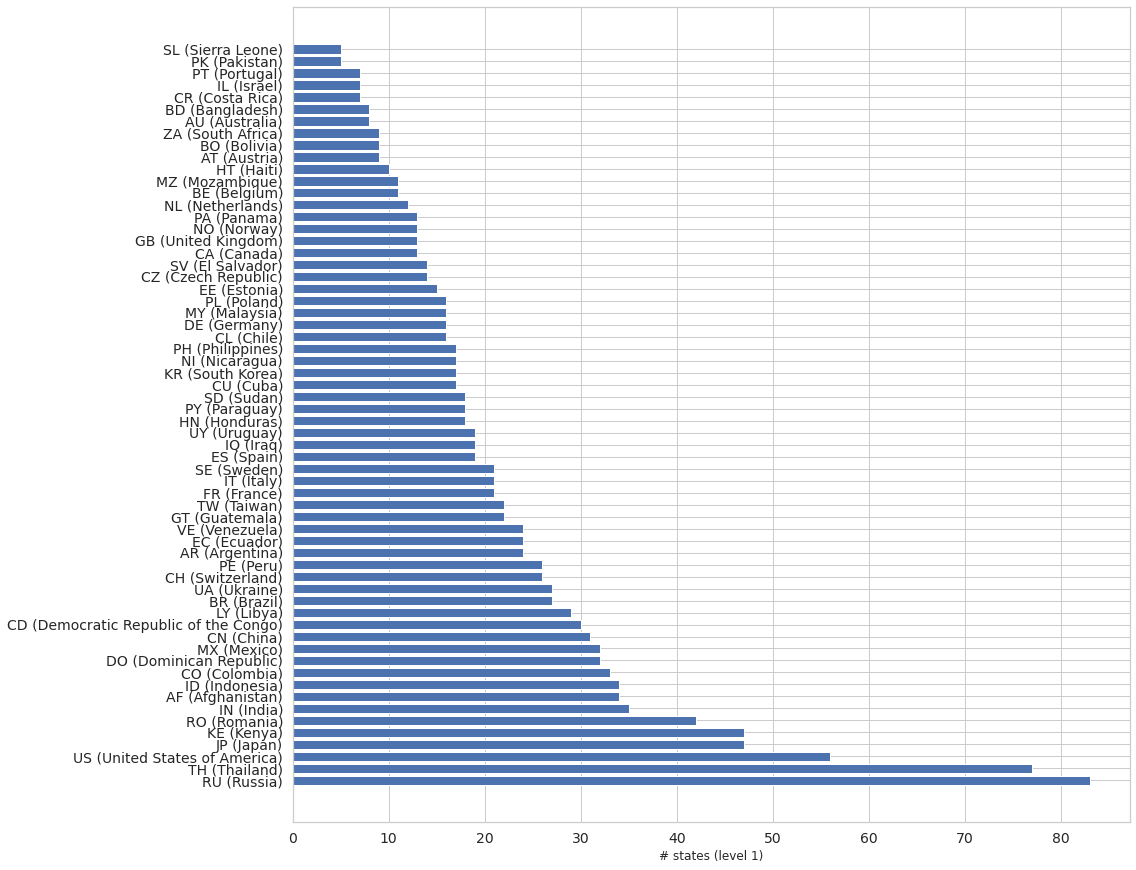

In [ ]:
plt.figure(figsize=(15,15))
names = list(nstates_per_country_nonzero.keys())
counts = list(nstates_per_country_nonzero.values())
plt.barh(names, counts)
plt.xlabel('# states (level 1)')


## Level 2 (county)


In [ ]:
def compute_counties():
  keys = df_index['location_key']
  counties_per_state = {}
  counties_per_country = {}

  def parse_key(key):
    parts = key.split('_')
    level = len(parts)-1
    if level==2:
      country = parts[0]
      state = parts[1]
      county = parts[2]
      state_key = f'{country}_{state}'
      try:
        counties_per_state[state_key].add(key)
      except:
        counties_per_state[state_key]  = {key}
      try:
        counties_per_country[country].add(key)
      except:
        counties_per_country[country]  = {key}

  for k in keys:
    parse_key(k)

  return counties_per_state, counties_per_country

counties_per_state, counties_per_country  = compute_counties()


In [ ]:

print(len(counties_per_state['US_CA']))
print(counties_per_state['US_CA'])

print(len(counties_per_state['CA_BC']))
print(counties_per_state['CA_BC'])

print([key_name(c) for c in counties_per_state['CA_BC']])

print(len(counties_per_country['CA']))

59
{'US_CA_06047', 'US_CA_06083', 'US_CA_06043', 'US_CA_06077', 'US_CA_06099', 'US_CA_06021', 'US_CA_06067', 'US_CA_06097', 'US_CA_06093', 'US_CA_06001', 'US_CA_06105', 'US_CA_SFO', 'US_CA_06069', 'US_CA_06023', 'US_CA_06049', 'US_CA_06109', 'US_CA_06063', 'US_CA_06037', 'US_CA_06033', 'US_CA_06061', 'US_CA_06073', 'US_CA_06115', 'US_CA_06019', 'US_CA_06039', 'US_CA_06057', 'US_CA_06075', 'US_CA_06103', 'US_CA_06081', 'US_CA_06031', 'US_CA_06017', 'US_CA_06111', 'US_CA_06007', 'US_CA_06015', 'US_CA_06045', 'US_CA_06025', 'US_CA_06113', 'US_CA_06041', 'US_CA_06095', 'US_CA_06071', 'US_CA_06029', 'US_CA_06079', 'US_CA_06087', 'US_CA_06013', 'US_CA_06059', 'US_CA_06065', 'US_CA_06009', 'US_CA_06085', 'US_CA_06091', 'US_CA_06101', 'US_CA_06035', 'US_CA_06053', 'US_CA_06003', 'US_CA_06005', 'US_CA_06051', 'US_CA_06107', 'US_CA_06055', 'US_CA_06011', 'US_CA_06027', 'US_CA_06089'}
5
{'CA_BC_5930', 'CA_BC_5920', 'CA_BC_5940', 'CA_BC_5910', 'CA_BC_5950'}
['CA_BC_5930 (Canada-British Columbia-Va

In [ ]:
ncounties_per_country = {} 
for i, c in enumerate(countries):
  counties = counties_per_country.get(c, [])
  ncounties_per_country[c] = len(counties)

print(ncounties_per_country)
ncounties_per_country = {k: v for k, v in sorted(ncounties_per_country.items(), key=lambda item: -item[1])} # largest first
print(ncounties_per_country)

ncounties_per_country_nonzero = {key_name(k): v for k, v in ncounties_per_country.items() if v>0}
print(len(ncounties_per_country_nonzero)) # 23 countries have county-level info
print(ncounties_per_country_nonzero)

{'AD': 0, 'AE': 0, 'AF': 0, 'AG': 0, 'AI': 0, 'AL': 0, 'AM': 0, 'AN': 0, 'AO': 0, 'AQ': 0, 'AR': 520, 'AS': 0, 'AT': 94, 'AU': 0, 'AW': 0, 'AZ': 0, 'BA': 0, 'BB': 0, 'BD': 64, 'BE': 0, 'BF': 0, 'BG': 0, 'BH': 0, 'BI': 0, 'BJ': 0, 'BM': 0, 'BN': 0, 'BO': 0, 'BQ': 0, 'BR': 5588, 'BS': 0, 'BT': 0, 'BV': 0, 'BW': 0, 'BY': 0, 'BZ': 0, 'CA': 92, 'CC': 0, 'CD': 0, 'CF': 0, 'CG': 0, 'CH': 0, 'CI': 0, 'CK': 0, 'CL': 346, 'CM': 0, 'CN': 0, 'CO': 1122, 'CR': 0, 'CU': 0, 'CV': 0, 'CW': 0, 'CX': 0, 'CY': 0, 'CZ': 77, 'DE': 412, 'DJ': 0, 'DK': 0, 'DM': 0, 'DO': 0, 'DZ': 0, 'EC': 0, 'EE': 0, 'EG': 0, 'EH': 0, 'ER': 0, 'ES': 1378, 'ET': 0, 'FI': 0, 'FJ': 0, 'FK': 0, 'FM': 0, 'FO': 0, 'FR': 96, 'GA': 0, 'GB': 183, 'GD': 0, 'GE': 0, 'GF': 0, 'GG': 0, 'GH': 0, 'GI': 0, 'GL': 0, 'GM': 0, 'GN': 0, 'GQ': 0, 'GR': 0, 'GS': 0, 'GT': 0, 'GU': 0, 'GW': 0, 'GY': 0, 'HK': 0, 'HM': 0, 'HN': 0, 'HR': 0, 'HT': 0, 'HU': 0, 'ID': 0, 'IE': 0, 'IL': 1478, 'IM': 0, 'IN': 713, 'IO': 0, 'IQ': 0, 'IR': 0, 'IS': 0, 'IT': 103

Text(0.5, 0, '# counties (level 2)')

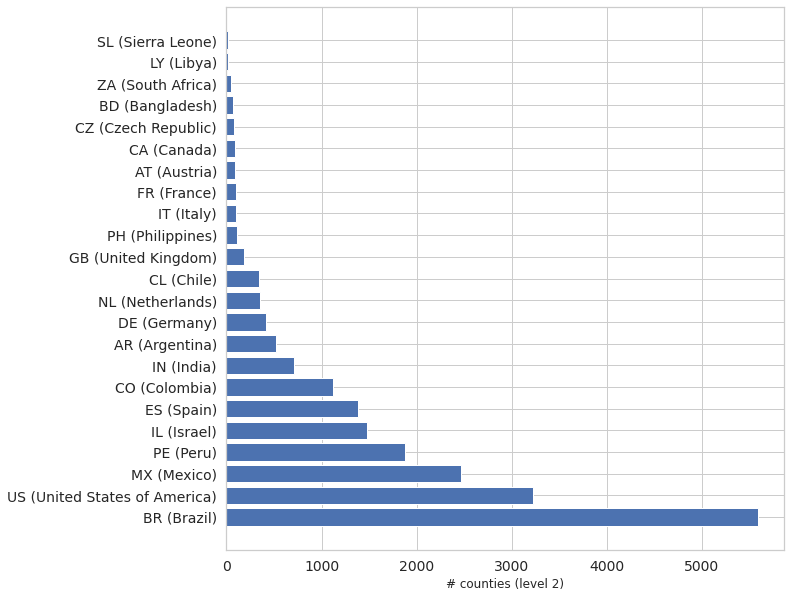

In [ ]:
plt.figure(figsize=(10,10))
names = list(ncounties_per_country_nonzero.keys())
counts = list(ncounties_per_country_nonzero.values())
plt.barh(names, counts)
plt.xlabel('# counties (level 2)')

In [ ]:
print(ncounties_per_country['CA'])
print(counties_per_state['CA_BC'])
for key in counties_per_state['CA_BC']:
  print(key_name(key))


92
{'CA_BC_5930', 'CA_BC_5920', 'CA_BC_5940', 'CA_BC_5910', 'CA_BC_5950'}
CA_BC_5930 (Canada-British Columbia-Vancouver Coastal)
CA_BC_5920 (Canada-British Columbia-Fraser)
CA_BC_5940 (Canada-British Columbia-Vancouver Island)
CA_BC_5910 (Canada-British Columbia-Interior)
CA_BC_5950 (Canada-British Columbia-Northern)


## Level 3 (locality)

In [ ]:
# locality level, not hierarchically nested.
print(len(geo_keys_level[3]))
print(geo_keys_level[3])

32
['BR_AL_MCZ' 'BR_AM_MAO' 'BR_BA_SSA' 'BR_CE_FOR' 'BR_DF_BSB' 'BR_GO_GYN'
 'BR_MA_SLZ' 'BR_MG_CNF' 'BR_PA_BEL' 'BR_PE_REC' 'BR_PR_CWB' 'BR_RJ_GIG'
 'BR_RJ_QSD' 'BR_RS_POA' 'BR_SP_GRU' 'BR_SP_SAO' 'BR_SP_VCP' 'ES_CN_ACE'
 'ES_CN_FUE' 'ES_CN_GMZ' 'ES_CN_LPA' 'ES_CN_SPC' 'ES_CN_TFN' 'ES_CN_VDE'
 'ES_CT_BCN' 'ES_MD_MAD' 'GB_ENG_LON' 'PH_00_MNL' 'UA_KBP' 'US_CA_SFO'
 'US_GA_ATL' 'US_NY_NYC']


# Epidemiology

In [16]:
cols_idx = ['aggregation_level', 'population']
cols_epi = table_cols['epidemiology']
df_epi_all = read_data(cols_idx + cols_epi) # takes several minutes

In [334]:
df_epi_all = df_epi_all.dropna()
df_epi_all['date']= pd.to_datetime(df_epi_all['date'],format='%Y-%m-%d') # converts date to datetime object

print(df_epi_all.shape)
df_epi_all.sample(n=10, random_state=42) 

(158962, 12)


,location_key,date,aggregation_level,new_confirmed,new_deceased,cumulative_confirmed,cumulative_deceased,cumulative_tested,population,new_tested,new_recovered,cumulative_recovered
4590616,IN_MH_RGD,2020-10-10,2,325.0,7.0,55310.0,1339.0,176581.0,2634200.0,0.0,193.0,47365.0
6887899,US_AR,2020-10-03,1,746.0,16.0,86525.0,1407.0,1064738.0,2978204.0,10478.0,1586.0,77772.0
4723480,IN_UP_SHV,2020-10-16,2,5.0,0.0,1061.0,13.0,94800.0,1117361.0,4062.0,6.0,977.0
7746447,US_SC,2020-08-16,1,615.0,9.0,106497.0,2269.0,867601.0,4896146.0,7201.0,0.0,42730.0
4492136,IN_BR_KMR,2020-09-14,2,6.0,0.0,1464.0,9.0,102400.0,1626384.0,92160.0,6.0,1335.0
4538289,IN_HR_FTB,2020-10-21,2,13.0,1.0,2764.0,52.0,27456.0,942011.0,0.0,13.0,2447.0
4501260,IN_CH_CHD,2020-08-19,2,91.0,1.0,2396.0,31.0,22730.0,1055450.0,532.0,108.0,1351.0
4644789,IN_PB_AMT,2020-10-15,2,46.0,1.0,11328.0,419.0,89227.0,2490656.0,0.0,72.0,10370.0
243268,AT_5,2020-05-28,1,1.0,0.0,1209.0,37.0,32726.0,555221.0,393.0,2.0,1153.0
7296778,US_MD,2020-11-29,1,1999.0,23.0,196447.0,4625.0,4402399.0,6006401.0,39249.0,8.0,8607.0


## Meta-data

In [336]:
feature_text = {}
feature_text['new_confirmed'] = 'Count of new cases confirmed after positive test on this date'
feature_text['new_deceased'] = 'Count of new deaths from a positive COVID-19 case on this date'
feature_text['new_recovered'] = 'Count of new recoveries from a positive COVID-19 case on this date'
feature_text['new_tested'] = 	'Count of new COVID-19 tests performed on this date'
feature_text['cumulative_confirmed'] = 'Cumulative sum of cases confirmed after positive test to date'
feature_text['cumulative_deceased'] =	'Cumulative sum of deaths from a positive COVID-19 case to date'
feature_text['cumulative_recovered'] = 'Cumulative sum of recoveries from a positive COVID-19 case to date'
feature_text['cumulative_tested'] =	'Cumulative sum of COVID-19 tests performed to date'

feature_names = feature_text.keys()
feature_sources = { k: 'Country specific' for k in feature_names}


df = pd.DataFrame({'Name': feature_names,
                   'Type': ['integer' for t in feature_names],
                    'Description': [feature_text[t] for t in feature_names],
                  # 'Sources': [feature_sources[t] for t in feature_names]
                   })

display(df) 


,Name,Type,Description
0,new_confirmed,integer,Count of new cases confirmed after positive test on this date
1,new_deceased,integer,Count of new deaths from a positive COVID-19 case on this date
2,new_recovered,integer,Count of new recoveries from a positive COVID-19 case on this date
3,new_tested,integer,Count of new COVID-19 tests performed on this date
4,cumulative_confirmed,integer,Cumulative sum of cases confirmed after positive test to date
5,cumulative_deceased,integer,Cumulative sum of deaths from a positive COVID-19 case to date
6,cumulative_recovered,integer,Cumulative sum of recoveries from a positive COVID-19 case to date
7,cumulative_tested,integer,Cumulative sum of COVID-19 tests performed to date


In [337]:
print(df.to_latex(index=False)) 

\begin{tabular}{lll}
\toprule
                 Name &     Type &                                                         Description \\
\midrule
        new\_confirmed &  integer &       Count of new cases confirmed after positive test on this date \\
         new\_deceased &  integer &      Count of new deaths from a positive COVID-19 case on this date \\
        new\_recovered &  integer &  Count of new recoveries from a positive COVID-19 case on this date \\
           new\_tested &  integer &                  Count of new COVID-19 tests performed on this date \\
 cumulative\_confirmed &  integer &       Cumulative sum of cases confirmed after positive test to date \\
  cumulative\_deceased &  integer &      Cumulative sum of deaths from a positive COVID-19 case to date \\
 cumulative\_recovered &  integer &  Cumulative sum of recoveries from a positive COVID-19 case to date \\
    cumulative\_tested &  integer &                  Cumulative sum of COVID-19 tests performed to date \\

<a name="death-rates-per-country-time-series"></a>
## Epi rates per country (time series)



In [55]:
# Exract country-level data
df_epi = df_epi_all[df_epi_all.aggregation_level == 0]
df_epi['date']= pd.to_datetime(df_epi['date'],format='%Y-%m-%d') # converts date to datetime object


print(df_epi.shape)
df_epi.sample(n=10, random_state=42)

(90402, 12)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,location_key,date,aggregation_level,new_confirmed,new_deceased,cumulative_confirmed,cumulative_deceased,cumulative_tested,population,new_tested,new_recovered,cumulative_recovered
8054187,UY,2020-06-11,0,0.0,0.0,847.0,23.0,51313.0,3461734.0,840.0,NaN,NaN
6797904,SZ,2020-11-13,0,17.0,1.0,6093.0,119.0,NaN,1148130.0,NaN,NaN,NaN
3871953,GE,2020-03-19,0,10.0,0.0,48.0,0.0,NaN,3720382.0,NaN,NaN,NaN
4867117,MS,2020-03-29,0,0.0,0.0,5.0,0.0,NaN,5215.0,NaN,NaN,NaN
6789807,SN,2020-09-29,0,63.0,2.0,14982.0,311.0,185355.0,16296364.0,1266.0,NaN,NaN
6791500,SV,2020-05-15,0,55.0,2.0,1265.0,25.0,55694.0,6453553.0,2282.0,NaN,NaN
2377466,BY,2020-02-10,0,0.0,0.0,0.0,0.0,NaN,9466856.0,NaN,NaN,NaN
6647042,PH,2020-09-04,0,3875.0,57.0,257803.0,5456.0,2628970.0,108116615.0,38935.0,1060.0,59657.0
15757,AQ,2020-01-20,0,NaN,NaN,NaN,NaN,NaN,4400.0,NaN,NaN,NaN
8072487,VN,2020-06-11,0,0.0,0.0,332.0,0.0,NaN,96462106.0,NaN,NaN,NaN


In [ ]:
def plot_epi_rate_helper(df, epi_col, ax, label, rolling_avg=None):
  # epi_col = 'confirmed', 'deceased', 'tested'
  df = df.dropna(subset=[epi_col])
  epi_normalized = df[epi_col] / df['population'] * 100_000
  if rolling_avg:
    y = epi_normalized.rolling(window=rolling_avg).mean()
  else:
    y = epi_normalized
  ax.plot(df.date, y, label=label)
 
    
def plot_normalized_new_epi_rate(epi_col, country_list):
  fig, ax = plt.subplots(1,1, figsize=(15,7))
  col_name = f'new_{epi_col}'
  rolling_avg = 14
  for country in country_list:
    df = df_epi[df_epi.location_key == country]
    plot_epi_rate_helper(df, col_name, ax, label=key_name(country), rolling_avg=rolling_avg)
  plt.legend()
  plt.title(f'{col_name} per 100k, {rolling_avg}-day rolling average')

      
def plot_normalized_cum_epi_rate(epi_col, country_list):
  fig, ax = plt.subplots(1,1, figsize=(15,7))
  col_name = f'cumulative_{epi_col}'
  for country in country_list:
    df = df_epi[df_epi.location_key == country]
    cum_epi_final = list(df[col_name].values)[-1] # most recent
    label = f'{key_name(country)}, final total {cum_epi_final:,}'
    plot_epi_rate_helper(df, col_name, ax, label)
  plt.legend()
  plt.title(f'{col_name} per 100k')


Infection rates per country (time series)

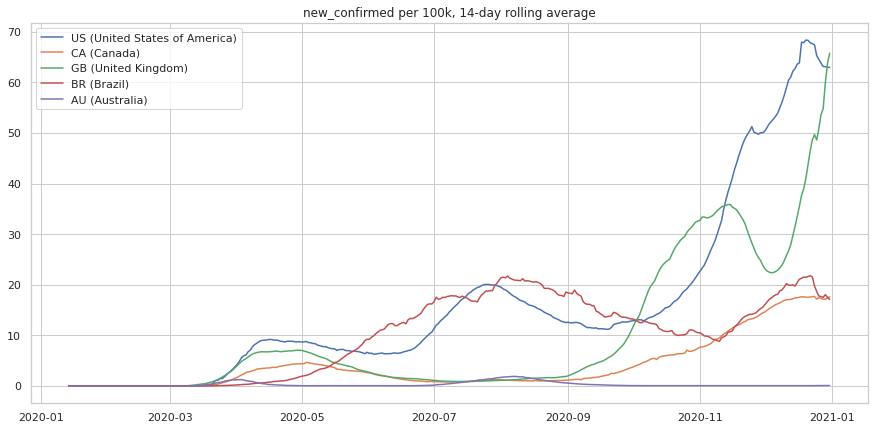

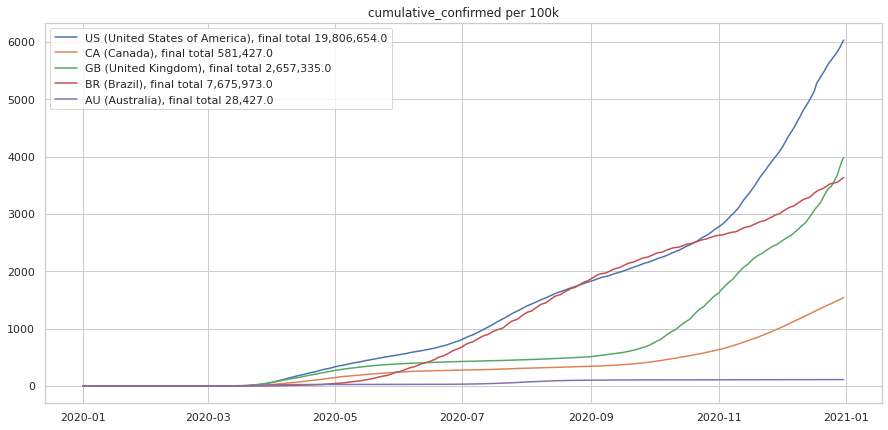

In [ ]:
countries = ['US', 'CA', 'GB', 'BR', 'AU']
plot_normalized_new_epi_rate('confirmed', countries)
plot_normalized_cum_epi_rate('confirmed', countries)

Death rates per country (time series)

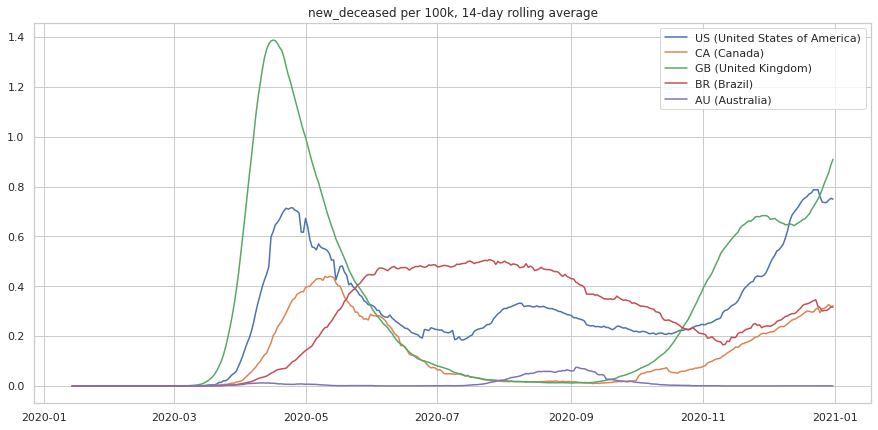

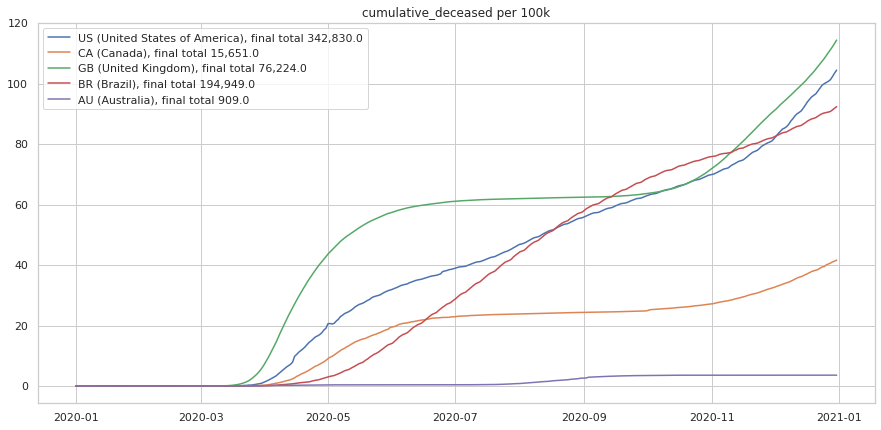

In [ ]:
plot_normalized_new_epi_rate('deceased', countries)
plot_normalized_cum_epi_rate('deceased', countries)

## Death rates per country (ranking) 

We compute the total number of deaths for each country, divided by population size, and call this the 'covid severity index'.

In [ ]:
def get_most_recent_value(df, col):
  dates = df['date']
  if len(dates)==0:
    return None
  last_date = max(dates)
  df_tmp = df[df.date == last_date]
  val = df_tmp[col].values[0]
  return val

def compute_latest_death_rate(country):
  df = df_epi[df_epi['location_key'] == country]
  df = df[['cumulative_deceased', 'date', 'population']]
  df = df.dropna(subset=['cumulative_deceased'])
  latest_cum_death = get_most_recent_value(df, 'cumulative_deceased')
  if latest_cum_death is None:
    print(f'{country} has no death data')
    print(f'{key_name(country)} has no death data')
    return 0
  pop = df['population'].values[0]
  return latest_cum_death / pop * 100_000

countries = set(df_epi.location_key.values)
death_rates = {}
for country in countries:
  d = compute_latest_death_rate(country)
  if d > 0: 
    death_rates[country] = d

print(death_rates)


CC has no death data
CC (Cocos Islands) has no death data
UM has no death data
UM (United States Minor Outlying Islands) has no death data
TF has no death data
TF (French Southern Territories) has no death data
IO has no death data
IO (British Indian Ocean Territory) has no death data
BV has no death data
BV (Bouvet Island) has no death data
BQ has no death data
BQ (Caribbean Netherlands) has no death data
HM has no death data
HM (Heard Island and McDonald Islands) has no death data
EH has no death data
EH (Western Sahara) has no death data
CX has no death data
CX (Christmas Island) has no death data
GS has no death data
GS (South Georgia and the South Sandwich Islands) has no death data
NF has no death data
NF (Norfolk Island) has no death data
AQ has no death data
AQ (Antarctica) has no death data
AN has no death data
AN (Netherlands Antilles) has no death data
SJ has no death data
SJ (Svalbard and Jan Mayen) has no death data
GZ has no death data
key_name: cannot find location GZ in

In [ ]:
df_death_rate = pd.DataFrame({'location_key': death_rates.keys(),
                   'country': [key_name(c) for c in death_rates.keys()], 
                    'deaths-per-100k': death_rates.values()})
#df_death_rate = df_death_rate.set_index('location_key')
df_death_rate = df_death_rate.sort_values('deaths-per-100k', ascending=False)
display(df_death_rate)

,location_key,country,deaths-per-100k
12,SM,SM (San Marino),174.246899
21,BE,BE (Belgium),171.480664
136,SI,SI (Slovenia),131.433009
150,PE,PE (Peru),128.392039
164,BA,BA (Bosnia and Herzegovina),123.780673
...,...,...,...
78,ER,ER (Eritrea),0.085788
152,VN,VN (Vietnam),0.036284
126,TZ,TZ (Tanzania),0.036203
74,TW,TW (Taiwan),0.029669


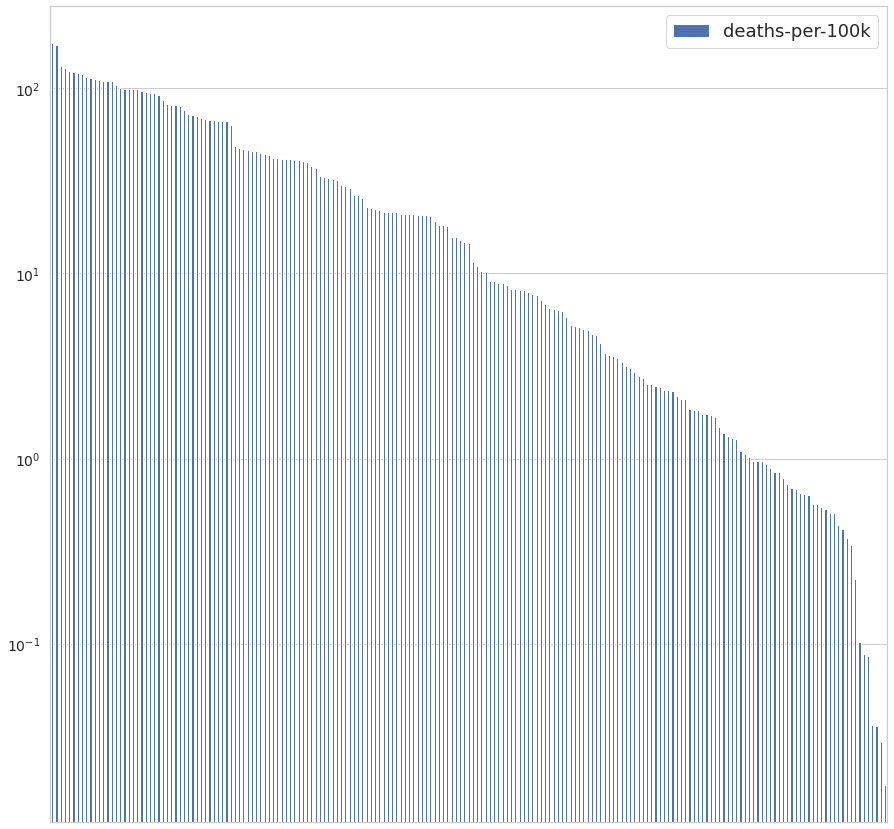

In [ ]:
df_death_rate.plot.bar(figsize=(15,15), xticks=[], logy=True)

## Predicting deaths from cases 


We can predict future deaths quite accurately if we know past infections, just by multiplying by the case fatality rate. We re-use code from this article by Clay Harmon.
https://medium.com/swlh/covid-19-time-series-analysis-with-pandas-and-python-the-grim-rifr-b078e6a327ca.


In [ ]:
def plot_cases_deaths(df, death_lag=0):
  fig,ax = plt.subplots(figsize=(12,6))
  rolling_avg = 14 # number of days to use for rolling average - probably should be multiple of 7

  ax.plot(df.date,df['new_confirmed'].rolling(window=rolling_avg).mean(),color='blue',
          label=f'new daily infections, {rolling_avg} day moving average')
  ax.set_ylabel('Daily new infections')
  leg = ax.legend(loc='center', frameon=False,bbox_to_anchor=(0.5, -0.10))

  ax2=ax.twinx()
  ax2.plot(df.date, df["new_deceased"].shift(death_lag).rolling(window=rolling_avg).mean(), color="red",
           label=f'new daily deaths, {rolling_avg}  day moving average, shifted by {death_lag} days')
  leg2=ax2.legend(loc='center', frameon=False,bbox_to_anchor=(0.49, -0.15))
  ax2.grid(False) # turn off grid for second Y axis
  ax2.set_ylabel('Daily new deaths')

def plot_cases_deaths_country(df_epi, country, death_lag=0):
  df = df_epi.loc[df_epi.location_key == country, ['date', 'new_confirmed', 'new_deceased']]
  plot_cases_deaths(df, death_lag=death_lag)
  plt.title(country)

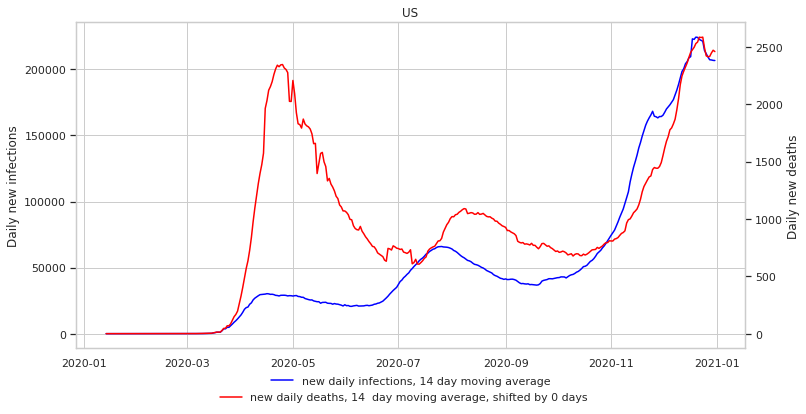

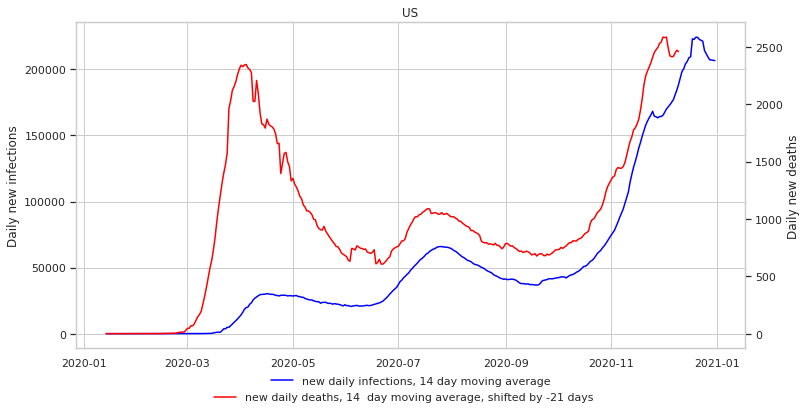

In [ ]:
plot_cases_deaths_country(df_epi, 'US')
plot_cases_deaths_country(df_epi, 'US', death_lag=-21)

In [123]:
def compute_case_fatality_rate(df, lag=-21, rolling_avg=14):
  # calculate an average death rate from lagged data
  fatality_rate = df["new_deceased"].shift(lag)/df["new_confirmed"] 
  avg_death_from_positive_cases = fatality_rate.rolling(window=rolling_avg).mean()
  stable_period = 45 # most recent 45 days of data
  start = lag - stable_period # calculates the index from end of dataframe to start the calculation
  death_factor = avg_death_from_positive_cases[start:lag].mean() # average of smoothed data
  return death_factor

def compute_case_fatality_rate_raw(df, lag=-21, rolling_avg=14):
  # calculate an average death rate from lagged data
  fatality_rate = df["new_deceased"].shift(lag)/df["new_confirmed"] 
  death_factor = np.nanmean(fatality_rate.values)
  return death_factor

def predict_deaths_from_cfr(df, cfr, lag=-21):
  #df['cfr'] = [cfr] * len(df.index) # copies value to entire column
  df['new_deceased_pred'] = df['new_confirmed'].shift(-lag) * cfr #df['cfr']
  return df




In [150]:
display(X)
display(X[0:10])

,date,new_confirmed,new_deceased,new_deceased_pred
3885826,2020-02-13,3.0,0.0,0.227113
3885827,2020-02-14,3.0,1.0,0.340670
3885829,2020-02-16,1.0,0.0,0.340670
3885832,2020-02-19,3.0,0.0,0.227113
3885833,2020-02-20,4.0,0.0,0.227113
...,...,...,...,...
3886144,2020-12-27,70.0,3.0,10.787874
3886145,2020-12-28,61.0,1.0,8.857413
3886146,2020-12-29,53.0,1.0,11.355657
3886147,2020-12-30,54.0,1.0,11.809884


,date,new_confirmed,new_deceased,new_deceased_pred
3885826,2020-02-13,3.0,0.0,0.227113
3885827,2020-02-14,3.0,1.0,0.340670
3885829,2020-02-16,1.0,0.0,0.340670
3885832,2020-02-19,3.0,0.0,0.227113
3885833,2020-02-20,4.0,0.0,0.227113
3885835,2020-02-22,1.0,0.0,0.113557
3885836,2020-02-23,5.0,0.0,0.113557
3885838,2020-02-25,4.0,0.0,0.340670
3885839,2020-02-26,6.0,1.0,0.340670
3885840,2020-02-27,2.0,0.0,0.340670


In [151]:

def get_true_and_pred_deaths_partial(df):
  X = df.copy()
  X = X.dropna() # drop rows with missing values
  rolling_avg = 14 # number of days to use for rolling average - probably should be multiple of 7
  new_deceased_smoothed = X['new_deceased'].rolling(window=rolling_avg).mean()
  new_deceased_pred_smoothed = X['new_deceased_pred'].rolling(window=rolling_avg).mean()

  # We only evaluate performance on second half of year, when things have 'settled down' and there is more data
  start_date = datetime(2020,8,1) # Aug 1
  start_R_calc = np.where(X.date==start_date)[0][0]
  end_date = datetime(2020,12,31) # Dec 31
  end_R_calc = np.where(X.date==end_date)[0][0]
  
  truth = new_deceased_smoothed[start_R_calc:end_R_calc]
  prediction = new_deceased_pred_smoothed[start_R_calc:end_R_calc]
  return truth, prediction

def get_true_and_pred_deaths(df):
  X = df.copy()
  X = X.dropna() # drop rows with missing values
  rolling_avg = 14 # number of days to use for rolling average - probably should be multiple of 7
  X['new_deceased_smoothed'] = X['new_deceased'].rolling(window=rolling_avg).mean()
  X['new_deceased_pred_smoothed'] = X['new_deceased_pred'].rolling(window=rolling_avg).mean()
  X = X.dropna() # drop rows with missing values (from rolling window)
  # Extract second half of data, when thigns are more predictable
  N = len(X)
  start = int(N/2)
  stop = N
  truth = X[start:stop]['new_deceased_smoothed'].values
  prediction = X[start:stop]['new_deceased_pred_smoothed'].values
  return truth, prediction

def mape_score(y_true, y_pred, eps=1e-3): 
    """
    %Error compares true value with predicted value. Lower the better. Use this along with rmse(). If the series has 
    outliers, compare/select model using MAPE instead of rmse()
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    y_true = y_true + eps
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


def rmse_score(y_true, y_pred):
  return np.sqrt(mean_squared_error(y_true, y_pred))



In [25]:

def plot_pred_deaths(df):
  fig,ax = plt.subplots(figsize=(12,6))
  rolling_avg = 14 # number of days to use for rolling average - probably should be multiple of 7
  true_deaths_smoothed = df['new_deceased'].rolling(window=rolling_avg).mean()
  pred_deaths_smoothed = df['new_deceased_pred'].rolling(window=rolling_avg).mean()

  ax.plot(df.date, true_deaths_smoothed, color='red',linestyle='-',
          label=f'Actual new daily deaths (smoothed)')
  ax.plot(df.date, pred_deaths_smoothed, color='red',linestyle='--',
          label=f'Predicted new daily deaths (smoothed)')
  ax.set_ylabel('New daily deaths')
  leg = ax.legend(loc='upper left', fontsize=10)

  ax2=ax.twinx()
  ax2.plot(df.date, df['new_confirmed'].rolling(window=rolling_avg).mean(), color="blue",
           label=f'New daily cases (smoothed)')
  leg2=ax2.legend(loc='upper right',  fontsize=10)
  ax2.grid(False) # turn off grid for second Y axis
  ax2.set_ylabel('New daily confirmed cases')





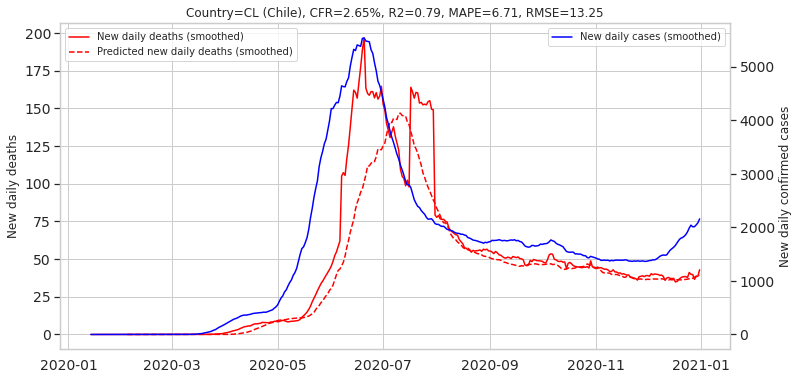

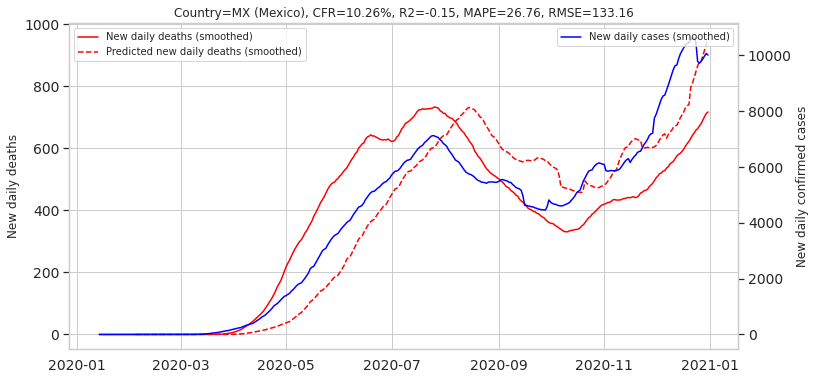

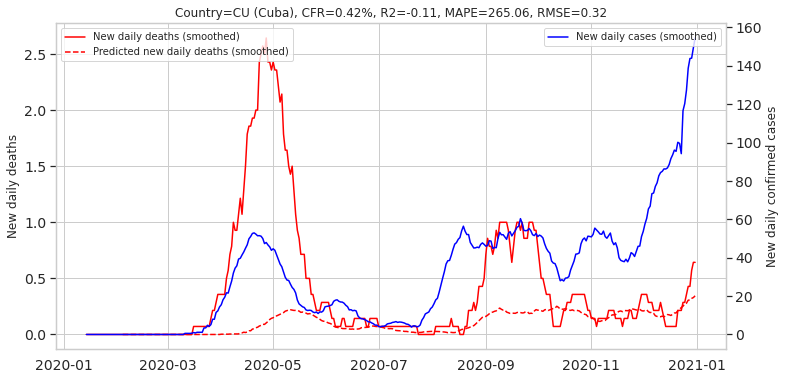

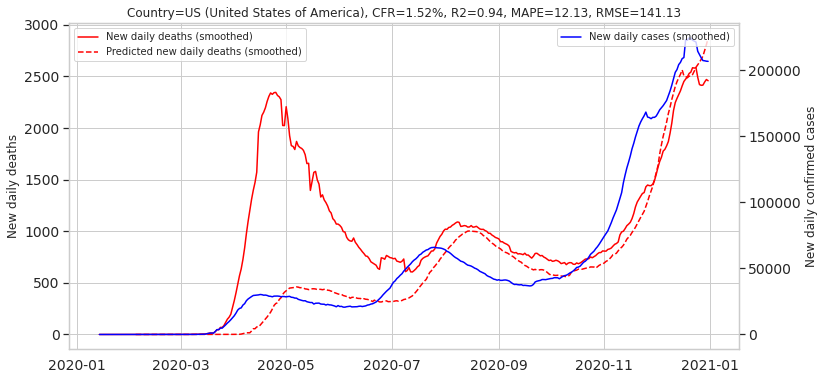

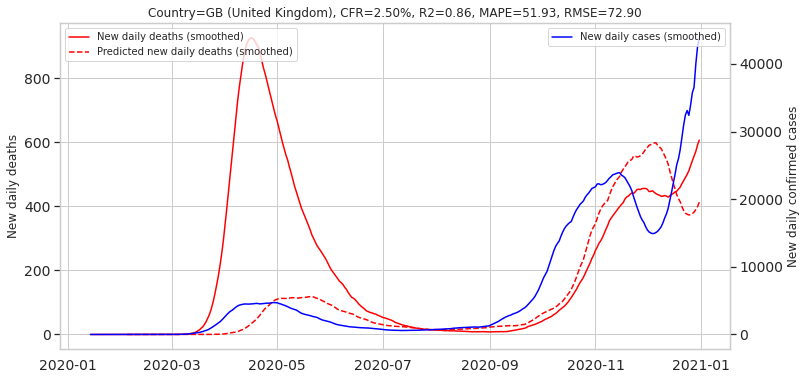

In [176]:
countries = ['US', 'ZW', 'CD', 'HK', 'AE']
countries = ['CL', 'MX', 'CU', 'US', 'GB']

CFR_dict = {}
R2_dict = {}
MAPE_dict = {}
RMSE_dict = {}
for country in countries:
  df = df_epi.loc[df_epi.location_key == country, ['date', 'new_confirmed', 'new_deceased']]
  CFR = compute_case_fatality_rate(df)
  df = predict_deaths_from_cfr(df, CFR)
  truth, pred = get_true_and_pred_deaths(df)
  R2 = r2_score(truth, pred)
  MAPE = mape_score(truth, pred)
  RMSE = rmse_score(truth, pred)
  CFR_dict[country] = CFR
  R2_dict[country] = R2
  MAPE_dict[country] = MAPE
  RMSE_dict[country] = RMSE
  plot_pred_deaths(df)
  plt.title('Country={}, CFR={:0.2f}%, R2={:0.2f}, MAPE={:0.2f}, RMSE={:0.2f}'.format(key_name(country), CFR*100, R2, MAPE, RMSE))

In [177]:

countries = set(df_epi.location_key.values)

CFR_dict = {}
R2_dict = {}
MAPE_dict = {}
RMSE_dict = {}
for country in countries:
  #print(country)
  df = df_epi.loc[df_epi.location_key == country, ['date', 'new_confirmed', 'new_deceased']]
  CFR = compute_case_fatality_rate(df)
  df = predict_deaths_from_cfr(df, CFR)
  truth, pred = get_true_and_pred_deaths(df)
  if len(truth)==0:
    continue
  R2 = r2_score(truth, pred)
  MAPE = mape_score(truth, pred)
  RMSE = rmse_score(truth, pred)
  CFR_dict[country] = CFR
  R2_dict[country] = R2
  MAPE_dict[country] = MAPE
  RMSE_dict[country] = RMSE
  #print(ttl)
  #plot_pred_deaths(df)
  #plt.title('Country={}, CFR={:0.2f}%, R2={:0.2f}, MAPE={:0.2f}, RMSE={:0.2f}'.format(key_name(country), CFR*100, R2, MAPE, RMSE))

In [159]:
# Merge dictionaries into a dataframe
countries = CFR_dict.keys()
CFR_list = np.fromiter(CFR_dict.values(), dtype=float)
R2_list = np.fromiter(R2_dict.values(), dtype=float)
MAPE_list = np.fromiter(MAPE_dict.values(), dtype=float)
RMSE_list = np.fromiter(RMSE_dict.values(), dtype=float)
df_cfr = pd.DataFrame({'location_key': countries,
                   'name': [key_name(c) for c in countries], 
                    'CFR': CFR_list*100,
                    'R2': R2_list,
                    'MAPE': MAPE_list,
                    'RMSE': RMSE_list
})
df_cfr = df_cfr.sort_values('CFR', ascending=False)
df_cfr = df_cfr[df_cfr["CFR"]>1e-3] # drop rows with negligible CFR
display(df_cfr)

,location_key,name,CFR,R2,MAPE,RMSE
119,ZW,ZW (Zimbabwe),27.139466,-145.970576,1700.607643,18.197548
117,CD,CD (Democratic Republic of the Congo),16.434288,-2.889458,611.445649,7.245684
15,HK,HK (Hong Kong),11.355657,-32.993031,27481.601723,4.194296
35,SY,SY (Syria),10.535588,0.274555,58.603149,2.389452
106,MX,MX (Mexico),10.256837,-0.153799,26.757850,133.162444
...,...,...,...,...,...,...
128,AE,AE (United Arab Emirates),0.238992,0.805594,20.179032,0.378085
38,UZ,UZ (Uzbekistan),0.228499,-1.110586,345.604177,2.959896
115,BH,BH (Bahrain),0.225824,0.119459,41.080502,0.750107
124,TH,TH (Thailand),0.144110,-0.023986,559.711717,0.028168


In [160]:
display(df_cfr.loc[df_cfr['location_key']=='US'])

,location_key,name,CFR,R2,MAPE,RMSE
79,US,US (United States of America),1.523221,0.936805,12.13144,141.129763


Text(0, 0.5, 'CFR')

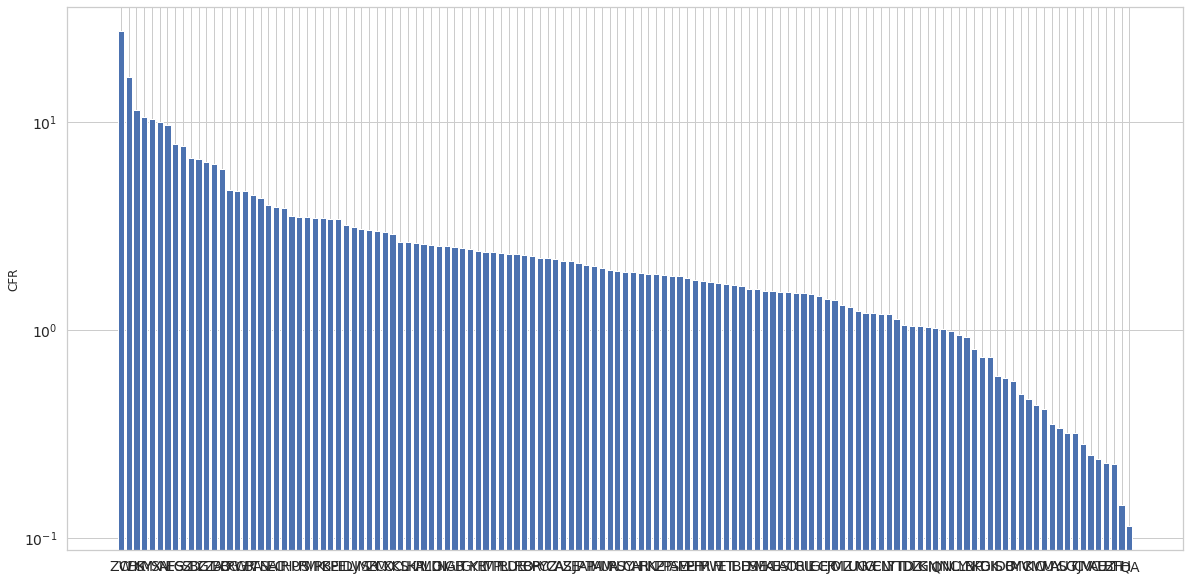

In [161]:
fig, ax = plt.subplots(figsize=(20,10))
ax.bar(df_cfr.location_key, df_cfr.CFR)
ax.set_yscale('log')
ax.set_ylabel('CFR')

(0.0, 1000.0)

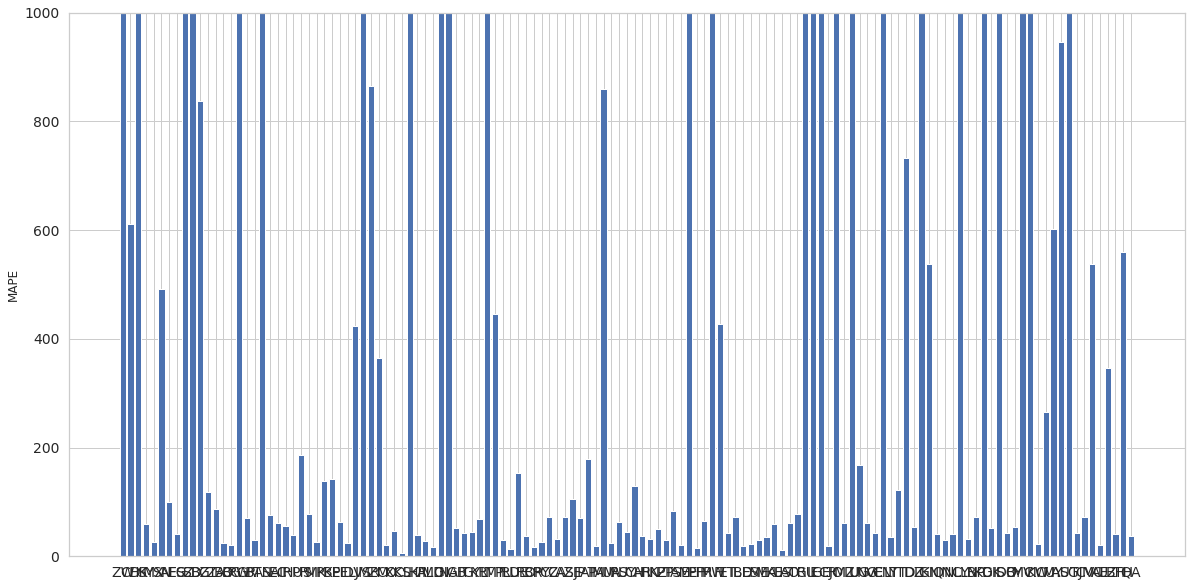

In [163]:
fig, ax = plt.subplots(figsize=(20,10))
ax.bar(df_cfr.location_key, df_cfr.MAPE)
ax.set_ylabel('MAPE')
ax.set_ylim(top=1000)

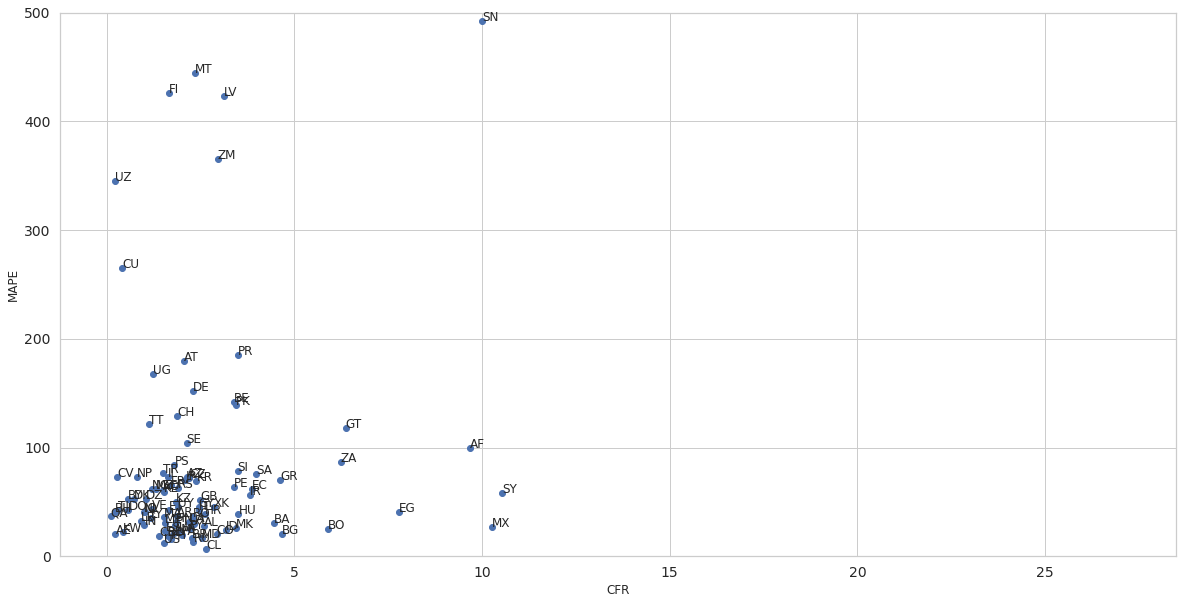

In [175]:
fig, ax = plt.subplots(figsize=(20,10))
xs = df_cfr.CFR.values
ys = df_cfr.MAPE.values
ax.scatter(xs, ys)
ax.set_xlabel('CFR')
ax.set_ylabel('MAPE')
ax.set_ylim((0, 500))
names = list(df_cfr.location_key.values)
for i, txt in enumerate(names):
  if ys[i] < 500:
    ax.annotate(txt, (xs[i], ys[i]), fontsize=12) 


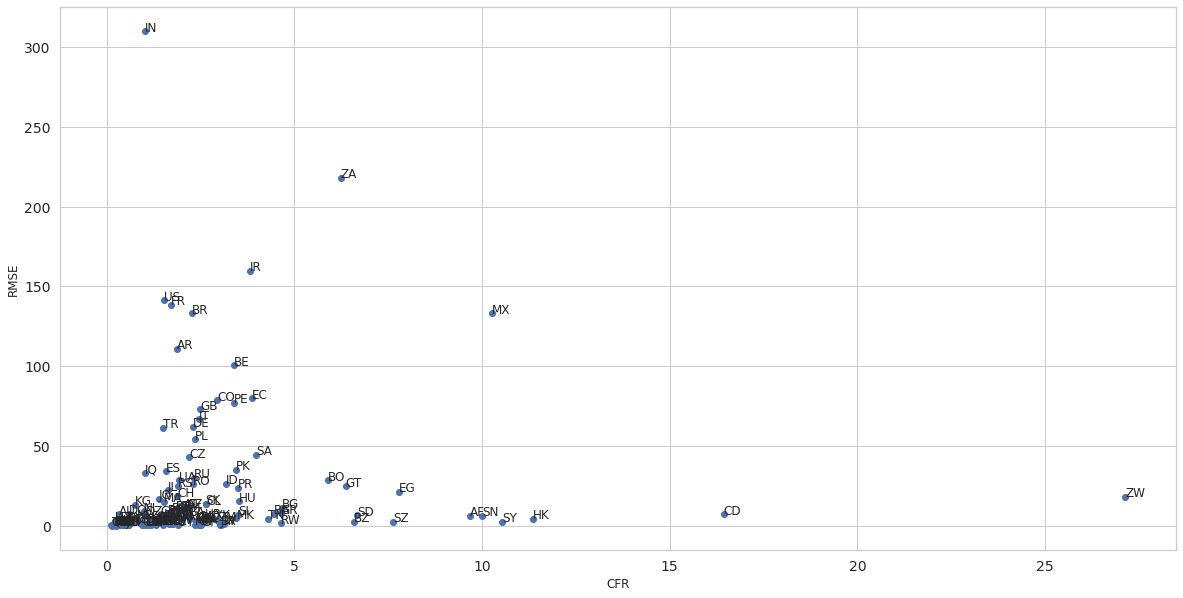

In [168]:
fig, ax = plt.subplots(figsize=(20,10))
xs = df_cfr.CFR.values
ys = df_cfr.RMSE.values
ax.scatter(xs, ys)
ax.set_xlabel('CFR')
ax.set_ylabel('RMSE')
names = list(df_cfr.location_key.values)
for i, txt in enumerate(names):
  ax.annotate(txt, (xs[i], ys[i]), fontsize=12) 

In [171]:
print([key_name(k) for k in ['IN', 'US', 'CD', 'ZW']])

['IN (India)', 'ZA (South Africa)', 'AR (Argentina)', 'CD (Democratic Republic of the Congo)', 'ZW (Zimbabwe)']


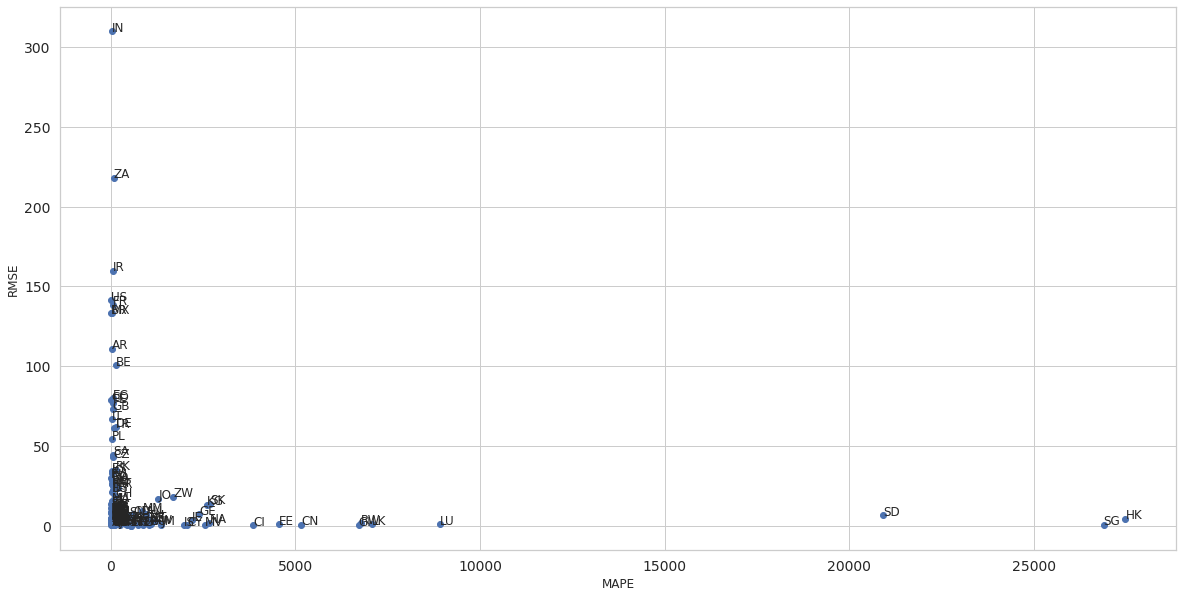

In [167]:
fig, ax = plt.subplots(figsize=(20,10))
xs = df_cfr.MAPE.values
ys = df_cfr.RMSE.values
ax.scatter(xs, ys)
ax.set_xlabel('MAPE')
ax.set_ylabel('RMSE')
names = list(df_cfr.location_key.values)
for i, txt in enumerate(names):
  ax.annotate(txt, (xs[i], ys[i]), fontsize=12) 

# Hospitalizations

In [210]:
cols_idx = ['aggregation_level', 'population']
cols_hospital = table_cols['hospitalizations']
df_hospital_all = read_data(cols_idx + cols_hospital) # takes several minutes

In [338]:
df_hospital_all = df_hospital_all.dropna()
df_hospital_all['date']= pd.to_datetime(df_hospital_all['date'],format='%Y-%m-%d') # converts date to datetime object

print(df_hospital_all.shape)
display(df_hospital_all.sample(n=10, random_state=42))


(162, 13)


,location_key,date,aggregation_level,population,new_hospitalized,cumulative_hospitalized,new_intensive_care,cumulative_intensive_care,current_hospitalized,current_intensive_care,current_ventilator,new_ventilator,cumulative_ventilator
7184447,US_KS,2020-12-30,1,2911641.0,192.0,6760.0,61.0,1823.0,767.0,234.0,99.0,1.0,412.0
7184398,US_KS,2020-11-11,1,2911641.0,114.0,4252.0,32.0,1167.0,810.0,210.0,80.0,8.0,347.0
7184420,US_KS,2020-12-03,1,2911641.0,0.0,5290.0,0.0,1390.0,854.0,227.0,92.0,0.0,409.0
7184344,US_KS,2020-09-18,1,2911641.0,55.0,2671.0,21.0,734.0,286.0,79.0,23.0,5.0,230.0
7184383,US_KS,2020-10-27,1,2911641.0,0.0,3646.0,0.0,1009.0,362.0,103.0,39.0,0.0,313.0
7184318,US_KS,2020-08-23,1,2911641.0,0.0,2159.0,0.0,584.0,296.0,89.0,24.0,0.0,203.0
7184390,US_KS,2020-11-03,1,2911641.0,0.0,3893.0,0.0,1082.0,373.0,110.0,39.0,0.0,328.0
7184340,US_KS,2020-09-14,1,2911641.0,35.0,2572.0,13.0,703.0,192.0,50.0,15.0,2.0,221.0
7184389,US_KS,2020-11-02,1,2911641.0,61.0,3893.0,15.0,1082.0,373.0,110.0,39.0,5.0,328.0
7184433,US_KS,2020-12-16,1,2911641.0,155.0,6050.0,44.0,1628.0,858.0,228.0,111.0,0.0,409.0


In [241]:
# Exract country-level data
df_hospital = df_hospital_all[df_hospital_all.aggregation_level == 0]
#df_hospital = df_hospital.dropna(subset=['new_hospitalized'])
print(df_hospital.shape)
df_hospital.sample(n=10, random_state=42)

(3844, 13)


,location_key,date,aggregation_level,population,new_hospitalized,cumulative_hospitalized,new_intensive_care,cumulative_intensive_care,current_hospitalized,current_intensive_care,current_ventilator,new_ventilator,cumulative_ventilator
3241820,ES,2020-06-06,0,46937060.0,43.0,110037.0,2.0,9437.0,NaN,NaN,NaN,NaN,NaN
6799599,TH,2020-07-01,0,69625582.0,-1.0,56.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3241999,ES,2020-12-02,0,46937060.0,622.0,201937.0,60.0,17604.0,NaN,NaN,NaN,NaN,NaN
4842039,LI,2020-09-21,0,38378.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5803757,NL,2020-08-14,0,17282163.0,11.0,12020.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6799721,TH,2020-10-31,0,69625582.0,0.0,131.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
319366,BR,2020-06-13,0,211049527.0,2216.0,173019.0,857.0,52379.0,NaN,NaN,NaN,NaN,NaN
4842077,LI,2020-10-29,0,38378.0,2.0,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3241994,ES,2020-11-27,0,46937060.0,769.0,198835.0,52.0,17302.0,NaN,NaN,NaN,NaN,NaN
2430874,CH,2020-02-26,0,8544527.0,9.0,18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [242]:
df = df_hospital[df_hospital.location_key == 'US']
df.head()

,location_key,date,aggregation_level,population,new_hospitalized,cumulative_hospitalized,new_intensive_care,cumulative_intensive_care,current_hospitalized,current_intensive_care,current_ventilator,new_ventilator,cumulative_ventilator


In [243]:
df = df_hospital[df_hospital.location_key == 'ES']
df.head()

,location_key,date,aggregation_level,population,new_hospitalized,cumulative_hospitalized,new_intensive_care,cumulative_intensive_care,current_hospitalized,current_intensive_care,current_ventilator,new_ventilator,cumulative_ventilator
3241663,ES,2020-01-01,0,46937060.0,9.0,9.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
3241664,ES,2020-01-02,0,46937060.0,67.0,76.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN
3241665,ES,2020-01-03,0,46937060.0,11.0,87.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN
3241666,ES,2020-01-04,0,46937060.0,11.0,98.0,0.0,2.0,NaN,NaN,NaN,NaN,NaN
3241667,ES,2020-01-05,0,46937060.0,13.0,111.0,0.0,2.0,NaN,NaN,NaN,NaN,NaN


## Meta data

In [339]:
#@title HTML
tbl_html = '''
<table>
<thead>
<tr>
<th>Name</th>
<th>Type</th>
<th>Description</th>
<th>Example</th>
</tr>
</thead>
<tbody>
<tr>
<td><strong>date</strong></td>
<td><code>string</code></td>
<td>ISO 8601 date (YYYY-MM-DD) of the datapoint</td>
<td>2020-03-30</td>
</tr>
<tr>
<td><strong>key</strong></td>
<td><code>string</code></td>
<td>Unique string identifying the region</td>
<td>CN_HB</td>
</tr>
<tr>
<td><strong>new_hospitalized*</strong></td>
<td><code>integer</code></td>
<td>Count of new cases hospitalized after positive test on this date</td>
<td>34</td>
</tr>
<tr>
<td><strong>new_intensive_care*</strong></td>
<td><code>integer</code></td>
<td>Count of new cases admitted into ICU after a positive COVID-19 test on this date</td>
<td>2</td>
</tr>
<tr>
<td><strong>new_ventilator*</strong></td>
<td><code>integer</code></td>
<td>Count of new COVID-19 positive cases which require a ventilator on this date</td>
<td>13</td>
</tr>
<tr>
<td><strong>total_hospitalized**</strong></td>
<td><code>integer</code></td>
<td>Cumulative sum of cases hospitalized after positive test to date</td>
<td>6447</td>
</tr>
<tr>
<td><strong>total_intensive_care**</strong></td>
<td><code>integer</code></td>
<td>Cumulative sum of cases admitted into ICU after a positive COVID-19 test to date</td>
<td>133</td>
</tr>
<tr>
<td><strong>total_ventilator**</strong></td>
<td><code>integer</code></td>
<td>Cumulative sum of COVID-19 positive cases which require a ventilator to date</td>
<td>133</td>
</tr>
<tr>
<td><strong>current_hospitalized**</strong></td>
<td><code>integer</code></td>
<td>Count of current (active) cases hospitalized after positive test to date</td>
<td>34</td>
</tr>
<tr>
<td><strong>current_intensive_care**</strong></td>
<td><code>integer</code></td>
<td>Count of current (active) cases admitted into ICU after a positive COVID-19 test to date</td>
<td>2</td>
</tr>
<tr>
<td><strong>current_ventilator**</strong></td>
<td><code>integer</code></td>
<td>Count of current (active) COVID-19 positive cases which require a ventilator to date</td>
<td>13</td>
</tr>
</tbody>
</table>
<p>*Values can be negative, typically indicating a correction or an adjustment in the way they were
measured. For example, a case might have been incorrectly flagged as recovered one date so it will
be subtracted from the following date.</p>
<p>**Total count will not always amount to the sum of daily counts, because many authorities make
changes to criteria for counting cases, but not always make adjustments to the data. There is also
potential missing data. All of that makes the total counts <em>drift</em> away from the sum of all daily
counts over time, which is why the cumulative values, if reported, are kept in a separate column.</p>
<h2><a id="user-content-sources-of-data" class="anchor" aria-hidden="true" href="#sources-of-data"><svg class="octicon octicon-link" viewBox="0 0 16 16" version="1.1" width="16" height="16" aria-hidden="true"><path fill-rule="evenodd" d="M7.775 3.275a.75.75 0 001.06 1.06l1.25-1.25a2 2 0 112.83 2.83l-2.5 2.5a2 2 0 01-2.83 0 .75.75 0 00-1.06 1.06 3.5 3.5 0 004.95 0l2.5-2.5a3.5 3.5 0 00-4.95-4.95l-1.25 1.25zm-4.69 9.64a2 2 0 010-2.83l2.5-2.5a2 2 0 012.83 0 .75.75 0 001.06-1.06 3.5 3.5 0 00-4.95 0l-2.5 2.5a3.5 3.5 0 004.95 4.95l1.25-1.25a.75.75 0 00-1.06-1.06l-1.25 1.25a2 2 0 01-2.83 0z"></path></svg></a>Sources of data</h2>
<details>
<summary>Show data sources</summary>
<table>
<thead>
<tr>
<th>Data</th>
<th>Source</th>
<th>License and Terms of Use</th>
</tr>
</thead>
<tbody>
<tr>
<td>Country-level data</td>
<td><a href="https://ourworldindata.org" rel="nofollow">Our World in Data</a></td>
<td><a href="https://ourworldindata.org/how-to-use-our-world-in-data#how-is-our-work-copyrighted" rel="nofollow">CC BY</a></td>
</tr>
<tr>
<td>Argentina</td>
<td><a href="https://datos.gob.ar/" rel="nofollow">Datos Argentina</a></td>
<td><a href="https://datos.gob.ar/acerca/seccion/marco-legal" rel="nofollow">Public domain</a></td>
</tr>
<tr>
<td>Australia</td>
<td><a href="https://covid-19-au.com/" rel="nofollow">https://covid-19-au.com/</a></td>
<td><a href="https://covid-19-au.com/faq" rel="nofollow">Attribution required</a></td>
</tr>
<tr>
<td>Belgium</td>
<td><a href="https://epistat.wiv-isp.be" rel="nofollow">Belgian institute for health</a></td>
<td><a href="https://www.health.belgium.be/en/legal-information" rel="nofollow">Attribution required</a></td>
</tr>
<tr>
<td>Brazil</td>
<td><a href="https://coronavirus.saude.gov.br/" rel="nofollow">Brazil Ministério da Saúde</a></td>
<td><a href="http://www.opendefinition.org/licenses/cc-by" rel="nofollow">Creative Commons Atribuição</a></td>
</tr>
<tr>
<td>Brazil (Rio de Janeiro)</td>
<td><a href="http://www.data.rio/" rel="nofollow">http://www.data.rio/</a></td>
<td><a href="https://www.data.rio/datasets/f314453b3a55434ea8c8e8caaa2d8db5" rel="nofollow">Dados abertos</a></td>
</tr>
<tr>
<td>Brazil (Ceará)</td>
<td><a href="https://saude.ce.gov.br" rel="nofollow">https://saude.ce.gov.br</a></td>
<td><a href="https://cearatransparente.ce.gov.br/portal-da-transparencia" rel="nofollow">Dados abertos</a></td>
</tr>
<tr>
<td>Chile</td>
<td><a href="http://www.minciencia.gob.cl/COVID19" rel="nofollow">Ministerio de Ciencia de Chile</a></td>
<td><a href="http://www.minciencia.gob.cl/sites/default/files/1771596.pdf" rel="nofollow">Terms of use</a></td>
</tr>
<tr>
<td>Czech Republic</td>
<td><a href="https://onemocneni-aktualne.mzcr.cz/covid-19" rel="nofollow">Ministry of Health of the Czech Republic</a></td>
<td><a href="https://www.jmir.org/2020/5/e19367" rel="nofollow">Open Data</a></td>
</tr>
<tr>
<td>Denmark</td>
<td><a href="https://github.com/google-research/open-covid-19-data">Open COVID-19 Data</a></td>
<td><a href="https://github.com/google-research/open-covid-19-data/blob/master/data/exports/cc_by/LICENSE">CC-BY</a></td>
</tr>
<tr>
<td>France</td>
<td><a href="https://data.gouv.fr" rel="nofollow">data.gouv.fr</a></td>
<td><a href="https://www.etalab.gouv.fr/licence-ouverte-open-licence" rel="nofollow">Open License 2.0</a></td>
</tr>
<tr>
<td>Hong Kong</td>
<td><a href="https://data.gov.hk/en-data/dataset/hk-dh-chpsebcddr-novel-infectious-agent" rel="nofollow">Hong Kong Department of Health</a></td>
<td><a href="https://data.gov.hk/en/terms-and-conditions" rel="nofollow">Attribution Required</a></td>
</tr>
<tr>
<td>India</td>
<td><a href="https://www.covid19india.org/" rel="nofollow">Covid 19 India Organisation</a></td>
<td><a href="http://creativecommons.org/licenses/by/4.0/" rel="nofollow">CC BY</a></td>
</tr>
<tr>
<td>Italy</td>
<td><a href="https://github.com/pcm-dpc/COVID-19">Italy's Department of Civil Protection</a></td>
<td><a href="https://github.com/pcm-dpc/COVID-19/blob/master/LICENSE">CC BY</a></td>
</tr>
<tr>
<td>Mexico</td>
<td><a href="https://coronavirus.gob.mx/" rel="nofollow">Secretaría de Salud Mexico</a></td>
<td><a href="https://datos.gob.mx/libreusomx" rel="nofollow">Attribution Required</a></td>
</tr>
<tr>
<td>Netherlands</td>
<td><a href="https://data.rivm.nl/covid-19" rel="nofollow">RIVM</a></td>
<td><a href="https://databronnencovid19.nl/Disclaimer" rel="nofollow">Public Domain</a></td>
</tr>
<tr>
<td>Norway</td>
<td><a href="https://github.com/covid19-eu-zh/covid19-eu-data">COVID19 EU Data</a></td>
<td><a href="https://github.com/covid19-eu-zh/covid19-eu-data/issues/57">MIT</a></td>
</tr>
<tr>
<td>Philippines</td>
<td><a href="http://www.doh.gov.ph/covid19tracker" rel="nofollow">Philippines Department of Health</a></td>
<td><a href="https://drive.google.com/file/d/1LzY2eLzZQdLR9yuoNufGEBN5Ily8ZTdV" rel="nofollow">Attribution required</a></td>
</tr>
<tr>
<td>Portugal</td>
<td><a href="https://github.com/carlospramalheira/covid19">COVID-19: Portugal</a></td>
<td><a href="https://github.com/carlospramalheira/covid19/blob/master/LICENSE">MIT</a></td>
</tr>
<tr>
<td>Romania</td>
<td><a href="https://github.com/adrianp/covid19romania">https://github.com/adrianp/covid19romania</a></td>
<td><a href="https://github.com/adrianp/covid19romania/blob/master/LICENSE">CC0</a></td>
</tr>
<tr>
<td>Slovenia</td>
<td><a href="https://www.gov.si" rel="nofollow">https://www.gov.si</a></td>
<td><a href="https://foundation.wikimedia.org/wiki/Terms_of_Use" rel="nofollow">Attribution Required</a></td>
</tr>
<tr>
<td>Spain</td>
<td><a href="https://covid19.isciii.es" rel="nofollow">Government Authority</a></td>
<td><a href="https://www.mscbs.gob.es/avisoLegal/home.html" rel="nofollow">Attribution required</a></td>
</tr>
<tr>
<td>Spain (Canary Islands)</td>
<td><a href="https://grafcan1.maps.arcgis.com/apps/opsdashboard/index.html#/156eddd4d6fa4ff1987468d1fd70efb6" rel="nofollow">Gobierno de Canarias</a></td>
<td><a href="https://www.gobiernodecanarias.org/principal/avisolegal.html" rel="nofollow">Attribution required</a></td>
</tr>
<tr>
<td>Spain (Catalonia)</td>
<td><a href="https://analisi.transparenciacatalunya.cat/" rel="nofollow">Dades Obertes Catalunya</a></td>
<td><a href="https://web.gencat.cat/ca/menu-ajuda/ajuda/avis_legal/" rel="nofollow">CC0</a></td>
</tr>
<tr>
<td>Spain (Madrid)</td>
<td><a href="https://www.comunidad.madrid/gobierno/datos-abiertos" rel="nofollow">Datos Abiertos Madrid</a></td>
<td><a href="https://www.comunidad.madrid/gobierno/datos-abiertos/reutiliza#condiciones-uso" rel="nofollow">Attribution required</a></td>
</tr>
<tr>
<td>Switzerland</td>
<td><a href="https://open.zh.ch" rel="nofollow">OpenZH data</a></td>
<td><a href="https://github.com/openZH/covid_19/blob/master/LICENSE">CC BY</a></td>
</tr>
<tr>
<td>Thailand</td>
<td><a href="https://covid19.th-stat.com/" rel="nofollow">Ministry of Public Health</a></td>
<td>Fair Use</td>
</tr>
<tr>
<td>United Kingdom</td>
<td><a href="https://coronavirus.data.gov.uk/" rel="nofollow">https://coronavirus.data.gov.uk/</a></td>
<td>Attribution required, <a href="https://www.nationalarchives.gov.uk/doc/open-government-licence/version/3/" rel="nofollow">Open Government Licence v3.0</a></td>
</tr>
<tr>
<td>USA</td>
<td><a href="https://covidtracking.com" rel="nofollow">COVID Tracking Project</a></td>
<td><a href="https://covidtracking.com/license" rel="nofollow">CC BY</a></td>
</tr>
<tr>
<td>USA (Alaska)</td>
<td><a href="http://dhss.alaska.gov/dph/Epi/id/Pages/COVID-19/default.aspx" rel="nofollow">Alaska Department of Health and Social Services</a></td>
<td></td>
</tr>
<tr>
<td>USA (D.C.)</td>
<td><a href="https://coronavirus.dc.gov/" rel="nofollow">Government of the District of Columbia</a></td>
<td><a href="https://dc.gov/node/939602" rel="nofollow">Public Domain</a></td>
</tr>
<tr>
<td>USA (Delaware)</td>
<td><a href="https://coronavirus.dc.gov/" rel="nofollow">Delaware Health and Social Services</a></td>
<td><a href="https://coronavirus.delaware.gov/coronavirus-graphics/" rel="nofollow">Public Domain</a></td>
</tr>
<tr>
<td>USA (Florida)</td>
<td><a href="https://floridahealthcovid19.gov/" rel="nofollow">Florida Health</a></td>
<td><a href="https://www.dms.myflorida.com/support/terms_and_conditions" rel="nofollow">Public Domain</a></td>
</tr>
<tr>
<td>USA (New York)</td>
<td><a href="https://www1.nyc.gov/site/doh/covid/covid-19-data.page" rel="nofollow">New York City Health Department</a></td>
<td><a href="https://www1.nyc.gov/home/terms-of-use.page" rel="nofollow">Public Domain</a></td>
</tr>
<tr>
<td>USA (San Francisco)</td>
<td><a href="https://data.sfgov.org/stories/s/dak2-gvuj" rel="nofollow">SF Open Data</a></td>
<td><a href="https://datasf.org/opendata/terms-of-use/#toc8" rel="nofollow">Public Domain Dedication and License</a></td>
</tr>
<tr>
<td>USA (Texas)</td>
<td><a href="https://dshs.texas.gov" rel="nofollow">Texas Department of State Health Services</a></td>
<td><a href="https://dshs.texas.gov/policy/copyright.shtm" rel="nofollow">Attribution required</a></td>
</tr>
</tbody>
</table>
</details>
</article>
  </div>

    </div>
'''

In [213]:
tables = pd.read_html(tbl_html)
display(tables[0])
display(tables[1])

,Name,Type,Description,Example
0,date,string,ISO 8601 date (YYYY-MM-DD) of the datapoint,2020-03-30
1,key,string,Unique string identifying the region,CN_HB
2,new_hospitalized*,integer,Count of new cases hospitalized after positive test on this date,34
3,new_intensive_care*,integer,Count of new cases admitted into ICU after a positive COVID-19 test on this date,2
4,new_ventilator*,integer,Count of new COVID-19 positive cases which require a ventilator on this date,13
5,total_hospitalized**,integer,Cumulative sum of cases hospitalized after positive test to date,6447
6,total_intensive_care**,integer,Cumulative sum of cases admitted into ICU after a positive COVID-19 test to date,133
7,total_ventilator**,integer,Cumulative sum of COVID-19 positive cases which require a ventilator to date,133
8,current_hospitalized**,integer,Count of current (active) cases hospitalized after positive test to date,34
9,current_intensive_care**,integer,Count of current (active) cases admitted into ICU after a positive COVID-19 test to date,2


,Data,Source,License and Terms of Use
0,Country-level data,Our World in Data,CC BY
1,Argentina,Datos Argentina,Public domain
2,Australia,https://covid-19-au.com/,Attribution required
3,Belgium,Belgian institute for health,Attribution required
4,Brazil,Brazil Ministério da Saúde,Creative Commons Atribuição
5,Brazil (Rio de Janeiro),http://www.data.rio/,Dados abertos
6,Brazil (Ceará),https://saude.ce.gov.br,Dados abertos
7,Chile,Ministerio de Ciencia de Chile,Terms of use
8,Czech Republic,Ministry of Health of the Czech Republic,Open Data
9,Denmark,Open COVID-19 Data,CC-BY


In [340]:
df = pd.read_html(tbl_html)[0]
df = df.drop(columns = 'Example')
feature_names = [n.replace('*', '') for n in df.Name.values]
df['Name'] = feature_names
feature_sources = ['Country specific' for f in feature_names]
df_sources = pd.DataFrame({'Sources': feature_sources})
#df = pd.concat([df, df_sources], axis=1)
df = df[df.Name != 'date']
df = df[df.Name != 'key']
display(df)

,Name,Type,Description
2,new_hospitalized,integer,Count of new cases hospitalized after positive test on this date
3,new_intensive_care,integer,Count of new cases admitted into ICU after a positive COVID-19 test on this date
4,new_ventilator,integer,Count of new COVID-19 positive cases which require a ventilator on this date
5,total_hospitalized,integer,Cumulative sum of cases hospitalized after positive test to date
6,total_intensive_care,integer,Cumulative sum of cases admitted into ICU after a positive COVID-19 test to date
7,total_ventilator,integer,Cumulative sum of COVID-19 positive cases which require a ventilator to date
8,current_hospitalized,integer,Count of current (active) cases hospitalized after positive test to date
9,current_intensive_care,integer,Count of current (active) cases admitted into ICU after a positive COVID-19 test to date
10,current_ventilator,integer,Count of current (active) COVID-19 positive cases which require a ventilator to date


In [341]:
print(df.to_latex(index=False)) 

\begin{tabular}{lll}
\toprule
                   Name &     Type &                                                                               Description \\
\midrule
       new\_hospitalized &  integer &                          Count of new cases hospitalized after positive test on this date \\
     new\_intensive\_care &  integer &          Count of new cases admitted into ICU after a positive COVID-19 test on this date \\
         new\_ventilator &  integer &              Count of new COVID-19 positive cases which require a ventilator on this date \\
     total\_hospitalized &  integer &                          Cumulative sum of cases hospitalized after positive test to date \\
   total\_intensive\_care &  integer &          Cumulative sum of cases admitted into ICU after a positive COVID-19 test to date \\
       total\_ventilator &  integer &              Cumulative sum of COVID-19 positive cases which require a ventilator to date \\
   current\_hospitalized &  integer &      

# By-age

In [249]:

cols_age = table_cols['by-age']
df_age_all = read_data(cols_age) # takes several minutes

ValueError: ignored

In [248]:
print(table_cols['by-age'])

['new_confirmed_age_0', 'new_confirmed_age_1', 'new_confirmed_age_2', 'new_confirmed_age_3', 'new_confirmed_age_4', 'new_confirmed_age_5', 'new_confirmed_age_6', 'new_confirmed_age_7', 'new_confirmed_age_8', 'new_confirmed_age_9', 'cumulative_confirmed_age_0', 'cumulative_confirmed_age_1', 'cumulative_confirmed_age_2', 'cumulative_confirmed_age_3', 'cumulative_confirmed_age_4', 'cumulative_confirmed_age_5', 'cumulative_confirmed_age_6', 'cumulative_confirmed_age_7', 'cumulative_confirmed_age_8', 'cumulative_confirmed_age_9', 'new_deceased_age_0', 'new_deceased_age_1', 'new_deceased_age_2', 'new_deceased_age_3', 'new_deceased_age_4', 'new_deceased_age_5', 'new_deceased_age_6', 'new_deceased_age_7', 'new_deceased_age_8', 'new_deceased_age_9', 'cumulative_deceased_age_0', 'cumulative_deceased_age_1', 'cumulative_deceased_age_2', 'cumulative_deceased_age_3', 'cumulative_deceased_age_4', 'cumulative_deceased_age_5', 'cumulative_deceased_age_6', 'cumulative_deceased_age_7', 'cumulative_decea

In [251]:
# Download the data using only the necessary columns
age_cols = [f'age_bin_{idx}' for idx in range(10)]
pop_cols = [col for col in COLUMNS if col.startswith('population_age_')]
cases_cols = [f'cumulative_confirmed_age_{idx}' for idx in range(10)]
deaths_cols = [f'cumulative_deceased_age_{idx}' for idx in range(10)]
df_age_all = read_data(['location_key', 'date', 'population'] + age_cols + cases_cols + deaths_cols)




/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (197,198,199,200,201,202,203,204,205,206) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [342]:
df_age_all = df_age_all.dropna()
df_age_all['date']= pd.to_datetime(df_age_all['date'],format='%Y-%m-%d') # converts date to datetime object


print(df_age_all.shape)
display(df_age_all.sample(n=10, random_state=42))

(744605, 34)


,location_key,date,aggregation_level,population,cumulative_confirmed_age_0,cumulative_confirmed_age_1,cumulative_confirmed_age_2,cumulative_confirmed_age_3,cumulative_confirmed_age_4,cumulative_confirmed_age_5,cumulative_confirmed_age_6,cumulative_confirmed_age_7,cumulative_confirmed_age_8,cumulative_confirmed_age_9,cumulative_deceased_age_0,cumulative_deceased_age_1,cumulative_deceased_age_2,cumulative_deceased_age_3,cumulative_deceased_age_4,cumulative_deceased_age_5,cumulative_deceased_age_6,cumulative_deceased_age_7,cumulative_deceased_age_8,cumulative_deceased_age_9,age_bin_0,age_bin_1,age_bin_2,age_bin_3,age_bin_4,age_bin_5,age_bin_6,age_bin_7,age_bin_8,age_bin_9
2789888,CO_25_25740,2020-08-23,2,38412.0,9.0,26.0,72.0,107.0,113.0,115.0,51.0,27.0,20.0,3.0,1.0,0.0,0.0,1.0,3.0,7.0,3.0,4.0,6.0,1.0,0-9,10-19,20-29,30-39,40-49,50-59,60-69,70-79,80-89,90-
2280939,BR_SP_354730,2020-05-17,2,108813.0,11.0,11.0,59.0,115.0,130.0,88.0,29.0,9.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,2.0,6.0,3.0,5.0,0.0,0-9,10-19,20-29,30-39,40-49,50-59,60-69,70-79,80-89,90-
6380654,PE_LAL_0103,2020-11-03,2,37262.0,38.0,86.0,295.0,338.0,316.0,285.0,203.0,123.0,55.0,5.0,1.0,0.0,3.0,6.0,14.0,23.0,42.0,42.0,22.0,6.0,0-9,10-19,20-29,30-39,40-49,50-59,60-69,70-79,80-89,90-
2844320,CO_50,2020-05-13,1,1062454.0,2.0,21.0,324.0,309.0,165.0,80.0,21.0,13.0,3.0,2.0,0.0,0.0,1.0,0.0,1.0,0.0,3.0,1.0,1.0,2.0,0-9,10-19,20-29,30-39,40-49,50-59,60-69,70-79,80-89,90-
5128183,MX_MEX_15031,2020-07-22,2,610601.0,21.0,30.0,255.0,433.0,431.0,390.0,245.0,109.0,31.0,3.0,2.0,1.0,4.0,27.0,67.0,117.0,101.0,51.0,19.0,1.0,0-9,10-19,20-29,30-39,40-49,50-59,60-69,70-79,80-89,90-
151074,AR_P,2020-10-09,1,600229.0,1.0,7.0,39.0,27.0,22.0,14.0,16.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0-9,10-19,20-29,30-39,40-49,50-59,60-69,70-79,80-89,90-
1463486,BR_PI_220620,2020-07-27,2,32289.0,10.0,63.0,147.0,131.0,103.0,85.0,53.0,48.0,16.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0-9,10-19,20-29,30-39,40-49,50-59,60-69,70-79,80-89,90-
2049782,BR_SC_421820,2020-09-09,2,36774.0,33.0,64.0,267.0,273.0,212.0,138.0,56.0,28.0,6.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,5.0,0.0,0-9,10-19,20-29,30-39,40-49,50-59,60-69,70-79,80-89,90-
4896291,MX_CHH_08037,2020-12-14,2,1267229.0,99.0,387.0,3792.0,4810.0,4608.0,3532.0,1650.0,852.0,353.0,53.0,7.0,3.0,33.0,110.0,389.0,618.0,646.0,476.0,220.0,26.0,0-9,10-19,20-29,30-39,40-49,50-59,60-69,70-79,80-89,90-
2894959,CO_63_63111,2020-09-21,2,2730.0,0.0,1.0,2.0,0.0,0.0,3.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0-9,10-19,20-29,30-39,40-49,50-59,60-69,70-79,80-89,90-


In [256]:
# Exract country-level data
df_age = df_age_all[df_age_all.aggregation_level == 0]
#df_age = df_age.dropna(subset=['cumulative_confirmed_age_0'])
print(df_age.shape)
df_age.sample(n=10, random_state=42)

(5434, 34)


,location_key,date,aggregation_level,population,cumulative_confirmed_age_0,cumulative_confirmed_age_1,cumulative_confirmed_age_2,cumulative_confirmed_age_3,cumulative_confirmed_age_4,cumulative_confirmed_age_5,cumulative_confirmed_age_6,cumulative_confirmed_age_7,cumulative_confirmed_age_8,cumulative_confirmed_age_9,cumulative_deceased_age_0,cumulative_deceased_age_1,cumulative_deceased_age_2,cumulative_deceased_age_3,cumulative_deceased_age_4,cumulative_deceased_age_5,cumulative_deceased_age_6,cumulative_deceased_age_7,cumulative_deceased_age_8,cumulative_deceased_age_9,age_bin_0,age_bin_1,age_bin_2,age_bin_3,age_bin_4,age_bin_5,age_bin_6,age_bin_7,age_bin_8,age_bin_9
4457735,IN,2020-09-17,0,1.366418e+09,4230.0,8022.0,24178.0,24748.0,20018.0,16240.0,10407.0,4752.0,1422.0,197.0,1.0,0.0,1.0,2.0,5.0,5.0,17.0,9.0,3.0,0.0,0-9,10-19,20-29,30-39,40-49,50-59,60-69,70-79,80-89,90-
6799462,TH,2020-02-15,0,6.962558e+07,2.0,0.0,3.0,11.0,3.0,5.0,6.0,4.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0-9,10-19,20-29,30-39,40-49,50-59,60-69,70-79,80-89,90-
3241825,ES,2020-06-11,0,4.693706e+07,1125.0,2157.0,14545.0,23392.0,35925.0,42912.0,34721.0,33527.0,58414.0,NaN,4.0,6.0,35.0,79.0,293.0,1009.0,2703.0,6712.0,18476.0,NaN,0-9,10-19,20-29,30-39,40-49,50-59,60-69,70-79,80-,NaN
319353,BR,2020-05-31,0,2.110495e+08,12970.0,22071.0,107218.0,185071.0,159166.0,102059.0,53060.0,27370.0,13567.0,4537.0,178.0,146.0,510.0,1612.0,3520.0,6382.0,10510.0,11368.0,8737.0,2858.0,0-9,10-19,20-29,30-39,40-49,50-59,60-69,70-79,80-89,90-
4457781,IN,2020-11-02,0,1.366418e+09,4235.0,8030.0,24220.0,24821.0,20242.0,16596.0,10896.0,5143.0,1592.0,230.0,1.0,0.0,1.0,2.0,5.0,5.0,17.0,9.0,3.0,0.0,0-9,10-19,20-29,30-39,40-49,50-59,60-69,70-79,80-89,90-
5944804,NZ,2020-12-29,0,4.917000e+06,89.0,193.0,509.0,387.0,305.0,318.0,221.0,91.0,32.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0-9,10-19,20-29,30-39,40-49,50-59,60-69,70-79,80-89,90-
3021660,CZ,2020-11-25,0,1.064980e+07,22215.0,41236.0,64539.0,73323.0,105842.0,81809.0,48671.0,33548.0,18880.0,5451.0,1.0,6.0,23.0,76.0,236.0,919.0,2638.0,3035.0,1001.0,NaN,0-9,10-19,20-29,30-39,40-49,50-59,60-69,70-79,80-89,90-
6799503,TH,2020-03-27,0,6.962558e+07,21.0,26.0,291.0,306.0,202.0,156.0,92.0,39.0,3.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0-9,10-19,20-29,30-39,40-49,50-59,60-69,70-79,80-89,90-
6799564,TH,2020-05-27,0,6.962558e+07,78.0,117.0,790.0,746.0,569.0,422.0,223.0,86.0,22.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0-9,10-19,20-29,30-39,40-49,50-59,60-69,70-79,80-89,90-
16360,AR,2020-09-13,0,4.493871e+07,18644.0,32675.0,115002.0,139444.0,112338.0,76885.0,42299.0,22580.0,14674.0,6185.0,28.0,28.0,116.0,291.0,762.0,1698.0,3603.0,4626.0,4506.0,2112.0,0-9,10-19,20-29,30-39,40-49,50-59,60-69,70-79,80-89,90-


## Meta-data

In [343]:
#@title HTML
tbl_html = '''
<table>
<thead>
<tr>
<th>Name</th>
<th>Type</th>
<th>Description</th>
<th>Example</th>
</tr>
</thead>
<tbody>
<tr>
<td><strong>date</strong></td>
<td><code>string</code></td>
<td>ISO 8601 date (YYYY-MM-DD) of the datapoint</td>
<td>2020-03-30</td>
</tr>
<tr>
<td><strong>key</strong></td>
<td><code>string</code></td>
<td>Unique string identifying the region</td>
<td>FR</td>
</tr>
<tr>
<td><strong><code>${statistic}</code>_age_bin_<code>${index}</code></strong></td>
<td><code>integer</code></td>
<td>Value of <code>${statistic}</code> for age bin <code>${index}</code></td>
<td>139</td>
</tr>
<tr>
<td><strong>age_bin_<code>${index}</code></strong></td>
<td><code>integer</code></td>
<td>Range for the age values inside of bin <code>${index}</code>, both ends inclusive</td>
<td>30-39</td>
</tr>
</tbody>
</table>
<h2><a id="user-content-sources-of-data" class="anchor" aria-hidden="true" href="#sources-of-data"><svg class="octicon octicon-link" viewBox="0 0 16 16" version="1.1" width="16" height="16" aria-hidden="true"><path fill-rule="evenodd" d="M7.775 3.275a.75.75 0 001.06 1.06l1.25-1.25a2 2 0 112.83 2.83l-2.5 2.5a2 2 0 01-2.83 0 .75.75 0 00-1.06 1.06 3.5 3.5 0 004.95 0l2.5-2.5a3.5 3.5 0 00-4.95-4.95l-1.25 1.25zm-4.69 9.64a2 2 0 010-2.83l2.5-2.5a2 2 0 012.83 0 .75.75 0 001.06-1.06 3.5 3.5 0 00-4.95 0l-2.5 2.5a3.5 3.5 0 004.95 4.95l1.25-1.25a.75.75 0 00-1.06-1.06l-1.25 1.25a2 2 0 01-2.83 0z"></path></svg></a>Sources of data</h2>
<details>
<summary>Show data sources</summary>
<table>
<thead>
<tr>
<th>Data</th>
<th>Source</th>
<th>License and Terms of Use</th>
</tr>
</thead>
<tbody>
<tr>
<td>Argentina</td>
<td><a href="https://datos.gob.ar/" rel="nofollow">Datos Argentina</a></td>
<td><a href="https://datos.gob.ar/acerca/seccion/marco-legal" rel="nofollow">Public domain</a></td>
</tr>
<tr>
<td>Brazil</td>
<td><a href="https://coronavirus.saude.gov.br/" rel="nofollow">Brazil Ministério da Saúde</a></td>
<td><a href="http://www.opendefinition.org/licenses/cc-by" rel="nofollow">Creative Commons Atribuição</a></td>
</tr>
<tr>
<td>Brazil (Rio de Janeiro)</td>
<td><a href="http://www.data.rio/" rel="nofollow">http://www.data.rio/</a></td>
<td><a href="https://www.data.rio/datasets/f314453b3a55434ea8c8e8caaa2d8db5" rel="nofollow">Dados abertos</a></td>
</tr>
<tr>
<td>Brazil (Ceará)</td>
<td><a href="https://saude.ce.gov.br" rel="nofollow">https://saude.ce.gov.br</a></td>
<td><a href="https://cearatransparente.ce.gov.br/portal-da-transparencia" rel="nofollow">Dados abertos</a></td>
</tr>
<tr>
<td>Colombia</td>
<td><a href="https://www.datos.gov.co" rel="nofollow">Datos Abiertos Colombia</a></td>
<td><a href="https://herramientas.datos.gov.co/es/terms-and-conditions-es" rel="nofollow">Attribution required</a></td>
</tr>
<tr>
<td>Czech Republic</td>
<td><a href="https://onemocneni-aktualne.mzcr.cz/covid-19" rel="nofollow">Ministry of Health of the Czech Republic</a></td>
<td><a href="https://www.jmir.org/2020/5/e19367" rel="nofollow">Open Data</a></td>
</tr>
<tr>
<td>Estonia</td>
<td><a href="https://www.terviseamet.ee/et/koroonaviirus/avaandmed" rel="nofollow">Health Board of Estonia</a></td>
<td><a href="https://www.terviseamet.ee/et/koroonaviirus/avaandmed" rel="nofollow">Open Data</a></td>
</tr>
<tr>
<td>Finland</td>
<td><a href="https://thl.fi/en/web/thlfi-en" rel="nofollow">Finnish institute for health and welfare</a></td>
<td><a href="https://thl.fi/en/web/thlfi-en/statistics/statistical-databases/open-data" rel="nofollow">CC BY</a></td>
</tr>
<tr>
<td>France</td>
<td><a href="https://data.gouv.fr" rel="nofollow">data.gouv.fr</a></td>
<td><a href="https://www.etalab.gouv.fr/licence-ouverte-open-licence" rel="nofollow">Open License 2.0</a></td>
</tr>
<tr>
<td>Germany</td>
<td><a href="https://npgeo-corona-npgeo-de.hub.arcgis.com/datasets/dd4580c810204019a7b8eb3e0b329dd6_0?page=26" rel="nofollow">Robert Koch Institute</a></td>
<td><a href="https://www.govdata.de/dl-de/by-2-0" rel="nofollow">Attribution Required</a></td>
</tr>
<tr>
<td>Hong Kong</td>
<td><a href="https://data.gov.hk/en-data/dataset/hk-dh-chpsebcddr-novel-infectious-agent" rel="nofollow">Hong Kong Department of Health</a></td>
<td><a href="https://data.gov.hk/en/terms-and-conditions" rel="nofollow">Attribution Required</a></td>
</tr>
<tr>
<td>India</td>
<td><a href="https://www.covid19india.org/" rel="nofollow">Covid 19 India Organisation</a></td>
<td><a href="http://creativecommons.org/licenses/by/4.0/" rel="nofollow">CC BY</a></td>
</tr>
<tr>
<td>Mexico</td>
<td><a href="https://coronavirus.gob.mx/" rel="nofollow">Secretaría de Salud Mexico</a></td>
<td><a href="https://datos.gob.mx/libreusomx" rel="nofollow">Attribution Required</a></td>
</tr>
<tr>
<td>New Zealand</td>
<td><a href="https://www.health.govt.nz/our-work/diseases-and-conditions/covid-19-novel-coronavirus/covid-19-data-and-statistics" rel="nofollow">Ministry of Health</a></td>
<td><a href="https://www.health.govt.nz/about-site/copyright" rel="nofollow">CC-BY</a></td>
</tr>
<tr>
<td>Peru</td>
<td><a href="https://www.datosabiertos.gob.pe/group/datos-abiertos-de-covid-19" rel="nofollow">Datos Abiertos Peru</a></td>
<td><a href="http://opendefinition.org/licenses/odc-by/" rel="nofollow">ODC BY</a></td>
</tr>
<tr>
<td>Philippines</td>
<td><a href="http://www.doh.gov.ph/covid19tracker" rel="nofollow">Philippines Department of Health</a></td>
<td><a href="https://drive.google.com/file/d/1LzY2eLzZQdLR9yuoNufGEBN5Ily8ZTdV" rel="nofollow">Attribution required</a></td>
</tr>
<tr>
<td>Romania</td>
<td><a href="https://datelazi.ro/" rel="nofollow">https://datelazi.ro/</a></td>
<td><a href="https://stirioficiale.ro/termeni-si-conditii-de-utilizare" rel="nofollow">Terms of Service</a></td>
</tr>
<tr>
<td>Spain</td>
<td><a href="https://covid19.isciii.es" rel="nofollow">Government Authority</a></td>
<td><a href="https://www.mscbs.gob.es/avisoLegal/home.html" rel="nofollow">Attribution required</a></td>
</tr>
<tr>
<td>Spain (Canary Islands)</td>
<td><a href="https://grafcan1.maps.arcgis.com/apps/opsdashboard/index.html#/156eddd4d6fa4ff1987468d1fd70efb6" rel="nofollow">Gobierno de Canarias</a></td>
<td><a href="https://www.gobiernodecanarias.org/principal/avisolegal.html" rel="nofollow">Attribution required</a></td>
</tr>
<tr>
<td>Spain (Catalonia)</td>
<td><a href="https://analisi.transparenciacatalunya.cat/" rel="nofollow">Dades Obertes Catalunya</a></td>
<td><a href="https://web.gencat.cat/ca/menu-ajuda/ajuda/avis_legal/" rel="nofollow">CC0</a></td>
</tr>
<tr>
<td>Spain (Madrid)</td>
<td><a href="https://www.comunidad.madrid/gobierno/datos-abiertos" rel="nofollow">Datos Abiertos Madrid</a></td>
<td><a href="https://www.comunidad.madrid/gobierno/datos-abiertos/reutiliza#condiciones-uso" rel="nofollow">Attribution required</a></td>
</tr>
<tr>
<td>Taiwan</td>
<td><a href="https://data.cdc.gov.tw/en/dataset/agsdctable-day-19cov/resource/3c1e263d-16ec-4d70-b56c-21c9e2171fc7" rel="nofollow">Ministry of Health and Welfare</a></td>
<td><a href="https://data.gov.tw/license" rel="nofollow">Attribution Required</a></td>
</tr>
<tr>
<td>Thailand</td>
<td><a href="https://covid19.th-stat.com/" rel="nofollow">Ministry of Public Health</a></td>
<td>Fair Use</td>
</tr>
<tr>
<td>USA</td>
<td><a href="https://github.com/nytimes">Imperial College of London</a></td>
<td><a href="https://github.com/ImperialCollegeLondon/US-covid19-agespecific-mortality-data/blob/master/LICENSE">CC BY</a></td>
</tr>
<tr>
<td>USA (California)</td>
<td><a href="https://data.ca.gov/dataset/590188d5-8545-4c93-a9a0-e230f0db7290/" rel="nofollow">California Open Data Portal</a></td>
<td><a href="https://data.ca.gov/dataset/590188d5-8545-4c93-a9a0-e230f0db7290/" rel="nofollow">CC0</a></td>
</tr>
<tr>
<td>USA (D.C.)</td>
<td><a href="https://coronavirus.dc.gov/" rel="nofollow">Government of the District of Columbia</a></td>
<td><a href="https://dc.gov/node/939602" rel="nofollow">Public Domain</a></td>
</tr>
<tr>
<td>USA (Delaware)</td>
<td><a href="https://coronavirus.dc.gov/" rel="nofollow">Delaware Health and Social Services</a></td>
<td><a href="https://coronavirus.delaware.gov/coronavirus-graphics/" rel="nofollow">Public Domain</a></td>
</tr>
<tr>
<td>USA (Florida)</td>
<td><a href="https://floridahealthcovid19.gov/" rel="nofollow">Florida Health</a></td>
<td><a href="https://www.dms.myflorida.com/support/terms_and_conditions" rel="nofollow">Public Domain</a></td>
</tr>
<tr>
<td>USA (Georgia)</td>
<td><a href="https://dph.georgia.gov/" rel="nofollow">Georgia Department of Public Health</a></td>
<td><a href="https://dph.georgia.gov/about-dph/mission-and-values" rel="nofollow">Fair Use</a></td>
</tr>
<tr>
<td>USA (Indiana)</td>
<td><a href="https://hub.mph.in.gov/organization/indiana-state-department-of-health" rel="nofollow">Indiana Department of Health</a></td>
<td>CC BY</td>
</tr>
<tr>
<td>USA (Massachusetts)</td>
<td><a href="https://www.mass.gov/info-details/covid-19-updates-and-information" rel="nofollow">MCAD COVID-19 Information &amp; Resource Center</a></td>
<td><a href="https://www.mass.gov/terms-of-use-policy" rel="nofollow">Public Domain</a></td>
</tr>
<tr>
<td>USA (Washington)</td>
<td><a href="https://www.doh.wa.gov/Emergencies/COVID19/DataDashboard" rel="nofollow">Washington State Department of Health</a></td>
<td><a href="https://www.doh.wa.gov/PrivacyandCopyright" rel="nofollow">Public Domain</a></td>
</tr>
<tr>
<td>Venezuela</td>
<td><a href="https://data.humdata.org/dataset/corona-virus-covid-19-cases-and-deaths-in-venezuela" rel="nofollow">HDX</a></td>
<td><a href="https://data.humdata.org/about/license" rel="nofollow">CC BY</a></td>
</tr>
</tbody>
</table>
</details>
</article>
  </div>

    </div>

'''

In [259]:
tables = pd.read_html(tbl_html)
display(tables[0])
display(tables[1])



,Name,Type,Description,Example
0,date,string,ISO 8601 date (YYYY-MM-DD) of the datapoint,2020-03-30
1,key,string,Unique string identifying the region,FR
2,${statistic}_age_bin_${index},integer,Value of ${statistic} for age bin ${index},139
3,age_bin_${index},integer,"Range for the age values inside of bin ${index}, both ends inclusive",30-39


,Data,Source,License and Terms of Use
0,Argentina,Datos Argentina,Public domain
1,Brazil,Brazil Ministério da Saúde,Creative Commons Atribuição
2,Brazil (Rio de Janeiro),http://www.data.rio/,Dados abertos
3,Brazil (Ceará),https://saude.ce.gov.br,Dados abertos
4,Colombia,Datos Abiertos Colombia,Attribution required
5,Czech Republic,Ministry of Health of the Czech Republic,Open Data
6,Estonia,Health Board of Estonia,Open Data
7,Finland,Finnish institute for health and welfare,CC BY
8,France,data.gouv.fr,Open License 2.0
9,Germany,Robert Koch Institute,Attribution Required


In [267]:
print(table_cols['by-age'])

['new_confirmed_age_0', 'new_confirmed_age_1', 'new_confirmed_age_2', 'new_confirmed_age_3', 'new_confirmed_age_4', 'new_confirmed_age_5', 'new_confirmed_age_6', 'new_confirmed_age_7', 'new_confirmed_age_8', 'new_confirmed_age_9', 'cumulative_confirmed_age_0', 'cumulative_confirmed_age_1', 'cumulative_confirmed_age_2', 'cumulative_confirmed_age_3', 'cumulative_confirmed_age_4', 'cumulative_confirmed_age_5', 'cumulative_confirmed_age_6', 'cumulative_confirmed_age_7', 'cumulative_confirmed_age_8', 'cumulative_confirmed_age_9', 'new_deceased_age_0', 'new_deceased_age_1', 'new_deceased_age_2', 'new_deceased_age_3', 'new_deceased_age_4', 'new_deceased_age_5', 'new_deceased_age_6', 'new_deceased_age_7', 'new_deceased_age_8', 'new_deceased_age_9', 'cumulative_deceased_age_0', 'cumulative_deceased_age_1', 'cumulative_deceased_age_2', 'cumulative_deceased_age_3', 'cumulative_deceased_age_4', 'cumulative_deceased_age_5', 'cumulative_deceased_age_6', 'cumulative_deceased_age_7', 'cumulative_decea

### Manual

In [344]:
feature_text = {}
#Value of ${statistic} for age bin ${index} bucket=0:9
feature_text['new_confirmed_age_b'] = 'Count of new cases on this date for age bucket b'
feature_text['new_deceased_age_b'] = 'Count of new deaths  on this date  for age bucket b'
feature_text['new_recovered_age_b'] = 'Count of new recoveries case on this date  for age bucket b'
feature_text['new_tested_age_b'] = 	'Count of new  tests performed on this date  for age bucket b'

feature_text['new_hospitalized_age_b'] = 	'Count of new cases hospitalized on this date  for age bucket b'
feature_text['new_intensive_care_age_b'] = 	'Count of new cases in ICU on this date  for age bucket b'
feature_text['new_ventilator_age_b'] = 	'Count of new cases on ventilators on this date  for age bucket b'

feature_text['cumulative_confirmed_age_b'] = 'Cumulative sum of cases  to date  for age bucket b'
feature_text['cumulative_deceased_age_b'] =	'Cumulative sum of deaths to date  for age bucket b'
feature_text['cumulative_recovered_age_b'] = 'Cumulative sum of recoveries  to date  for age bucket b'
feature_text['cumulative_tested_age_b'] =	'Cumulative sum of  tests performed to date  for age bucket b'

feature_text['cumulative_hospitalized_age_b'] =	'Cumulative sum of cases hospitalized to date  for age bucket b'
feature_text['cumulative_intensive_care_age_b'] =	'Cumulative sum of cases in ICU to date  for age bucket b'
feature_text['cumulative_ventilator_age_b'] =	'Cumulative sum of cases on ventilators to date  for age bucket b'

feature_text['age_bin_b'] =	'Range for the age values inside of bin b, both ends inclusive'

feature_names = feature_text.keys()
feature_sources = { k: 'Location specific' for k in feature_names}
feature_type = { k: 'integer' for k in feature_names}


df = pd.DataFrame({'Name': feature_names,
                   'Type': [feature_type[t] for t in feature_names],
                   'Description': [feature_text[t] for t in feature_names],
                  # 'Sources': [feature_sources[t] for t in feature_names]
                   })

display(df) 

,Name,Type,Description
0,new_confirmed_age_b,integer,Count of new cases on this date for age bucket b
1,new_deceased_age_b,integer,Count of new deaths on this date for age bucket b
2,new_recovered_age_b,integer,Count of new recoveries case on this date for age bucket b
3,new_tested_age_b,integer,Count of new tests performed on this date for age bucket b
4,new_hospitalized_age_b,integer,Count of new cases hospitalized on this date for age bucket b
5,new_intensive_care_age_b,integer,Count of new cases in ICU on this date for age bucket b
6,new_ventilator_age_b,integer,Count of new cases on ventilators on this date for age bucket b
7,cumulative_confirmed_age_b,integer,Cumulative sum of cases to date for age bucket b
8,cumulative_deceased_age_b,integer,Cumulative sum of deaths to date for age bucket b
9,cumulative_recovered_age_b,integer,Cumulative sum of recoveries to date for age bucket b


In [345]:
print(df.to_latex(index=False)) 

\begin{tabular}{lll}
\toprule
                            Name &     Type &                                                       Description \\
\midrule
             new\_confirmed\_age\_b &  integer &                  Count of new cases on this date for age bucket b \\
              new\_deceased\_age\_b &  integer &               Count of new deaths  on this date  for age bucket b \\
             new\_recovered\_age\_b &  integer &       Count of new recoveries case on this date  for age bucket b \\
                new\_tested\_age\_b &  integer &      Count of new  tests performed on this date  for age bucket b \\
          new\_hospitalized\_age\_b &  integer &    Count of new cases hospitalized on this date  for age bucket b \\
        new\_intensive\_care\_age\_b &  integer &          Count of new cases in ICU on this date  for age bucket b \\
            new\_ventilator\_age\_b &  integer &  Count of new cases on ventilators on this date  for age bucket b \\
      cumulative\_c

## Plot age-stratified case fatality rate

In [252]:
df = df_age_all.copy()

# Remove records without any stratified cases or deaths
population_threshold = 10_000
df = df[df['population'] > population_threshold]
df = df.dropna(subset=(cases_cols + deaths_cols), how='all')

# Keep only the latest non-null record
# See https://github.com/pandas-dev/pandas/issues/27751
df = df.set_index('location_key').groupby(level='location_key').ffill().reset_index()
df = df.groupby('location_key').last().reset_index()

# Remove keys which are part of other keys
df = df.sort_values('location_key')
records = []
last_key = '_'
for _, row in df.iterrows():
  if row['location_key'].startswith(last_key):
    # print(f"Removing key {row['location_key']} since it's already in {last_key}")
    pass
  else:
    records.append(row)
    last_key = row['location_key']
df = pd.DataFrame.from_records(records)

def combine_age_groups(record, merge_groups = ('80-89', '80-90', '90-99', '90-100', '90-', '100-')):
  '''Combine age groups 80-90, 90-100 and 100+ into 80+.'''
  merge_indices = [idx for idx, age_group in enumerate(age_cols) if record[age_group] in merge_groups]
  if merge_indices:
    replace_idx = merge_indices[0]
    record[f'age_bin_{replace_idx}'] = '80-'
    record[f'cumulative_confirmed_age_{replace_idx}'] = sum(record[f'cumulative_confirmed_age_{idx}'] for idx in merge_indices)
    record[f'cumulative_deceased_age_{replace_idx}'] = sum(record[f'cumulative_deceased_age_{idx}'] for idx in merge_indices)
    for idx in merge_indices[1:]:
      record[f'age_bin_{idx}'] = None
      record[f'cumulative_confirmed_age_{idx}'] = None
      record[f'cumulative_deceased_age_{idx}'] = None
  return record

# Combine all age groups > 80 years old into a single 80+ bucket
df = df.apply(combine_age_groups, axis=1)

In [253]:
records = []
keys_used = set()
age_groups = ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-']
for key, row in df.set_index('location_key').iterrows():
  record = {}
  idx_map = {idx: row[f'age_bin_{idx}'] for idx in range(10) if row[f'age_bin_{idx}'] in age_groups}
  for idx, age_group in idx_map.items():
    cases = row[f'cumulative_confirmed_age_{idx}']
    deaths = row[f'cumulative_deceased_age_{idx}']
    # Make sure the record has both deaths and cases
    if not pd.isna(cases) and not pd.isna(deaths) and deaths > 0 and cases > 0:
      if deaths > cases: print(key, age_group)
      record[age_group] = min(deaths, cases) / cases
      keys_used.add(key)
  if record: records.append(record)

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


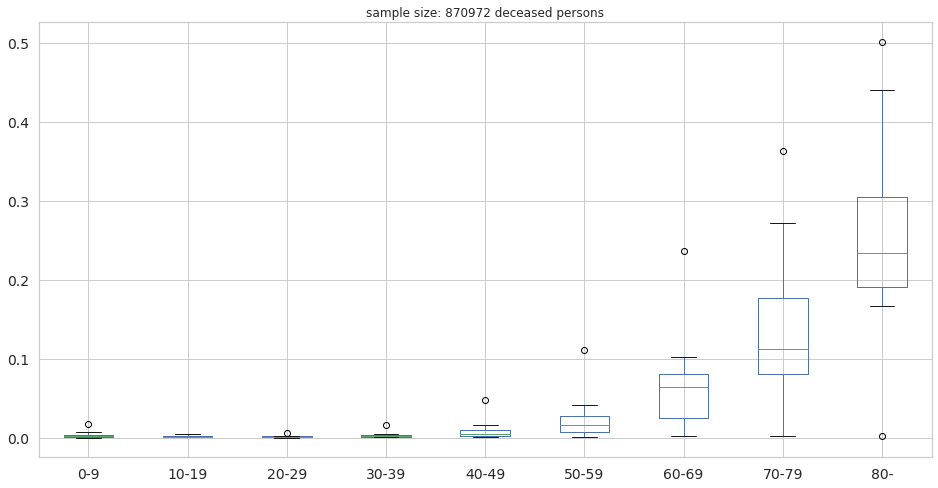

In [254]:
sample_size = df[[col for col in df.columns if col.startswith('cumulative_deceased')]].sum().sum()
X = pd.DataFrame.from_records(records)
X.plot(kind='box', figsize=(16, 8), title=f'sample size: {int(sample_size)} deceased persons',
       ylabel='Fatality rate');

# By-sex

In [284]:

cols_sex = table_cols['by-sex']
print(cols_sex)

# These columns are not in the aggregated table
drop = ['new_ventilator_female', 'cumulative_ventilator_female', 'cumulative_ventilator_male', 'new_ventilator_male']
cols_sex = list(set(cols_sex) - set(drop))
print(cols_sex)

df_sex_all = read_data(cols_sex) # takes several minutes


['new_confirmed_male', 'new_confirmed_female', 'cumulative_confirmed_male', 'cumulative_confirmed_female', 'new_deceased_male', 'new_deceased_female', 'cumulative_deceased_male', 'cumulative_deceased_female', 'new_recovered_male', 'new_recovered_female', 'cumulative_recovered_male', 'cumulative_recovered_female', 'new_tested_male', 'new_tested_female', 'cumulative_tested_male', 'cumulative_tested_female', 'new_hospitalized_male', 'new_hospitalized_female', 'cumulative_hospitalized_male', 'cumulative_hospitalized_female', 'new_intensive_care_male', 'new_intensive_care_female', 'cumulative_intensive_care_male', 'cumulative_intensive_care_female', 'new_ventilator_male', 'new_ventilator_female', 'cumulative_ventilator_male', 'cumulative_ventilator_female']
['cumulative_tested_male', 'cumulative_confirmed_female', 'cumulative_recovered_female', 'cumulative_recovered_male', 'cumulative_hospitalized_female', 'cumulative_intensive_care_female', 'new_confirmed_male', 'cumulative_intensive_care_

In [346]:
df_sex_all = df_sex_all.dropna()
df_sex_all['date']= pd.to_datetime(df_sex_all['date'],format='%Y-%m-%d') # converts date to datetime object


print(df_sex_all.shape)
display(df_sex_all.sample(n=10, random_state=42))

(79506, 28)


,location_key,date,aggregation_level,population,new_confirmed_male,new_confirmed_female,cumulative_confirmed_male,cumulative_confirmed_female,new_deceased_male,new_deceased_female,cumulative_deceased_male,cumulative_deceased_female,new_tested_male,new_tested_female,cumulative_tested_male,cumulative_tested_female,new_hospitalized_male,new_hospitalized_female,cumulative_hospitalized_male,cumulative_hospitalized_female,new_intensive_care_male,new_intensive_care_female,cumulative_intensive_care_male,cumulative_intensive_care_female,new_recovered_male,new_recovered_female,cumulative_recovered_male,cumulative_recovered_female
1641123,BR_PR_412810,2020-12-01,2,100676.0,3.0,2.0,67.0,46.0,0.0,0.0,12.0,12.0,4.0,2.0,405.0,353.0,0.0,1.0,56.0,29.0,1.0,1.0,18.0,13.0,0.0,0.0,0.0,0.0
1178520,BR_MT_510410,2020-11-12,2,32216.0,2.0,3.0,422.0,463.0,0.0,0.0,11.0,10.0,3.0,4.0,949.0,1079.0,1.0,1.0,63.0,53.0,0.0,1.0,12.0,7.0,0.0,0.0,0.0,0.0
1770307,BR_RS_430040,2020-12-27,2,77653.0,0.0,0.0,876.0,1033.0,0.0,0.0,16.0,21.0,22.0,0.0,4723.0,4766.0,1.0,1.0,87.0,97.0,0.0,0.0,35.0,44.0,0.0,0.0,0.0,0.0
1655661,BR_RJ_330170,2020-09-30,2,855048.0,30.0,10.0,4926.0,5276.0,1.0,1.0,419.0,378.0,72.0,36.0,8023.0,8550.0,3.0,6.0,1132.0,999.0,0.0,5.0,379.0,351.0,0.0,0.0,0.0,0.0
1674016,BR_RJ_330510,2020-11-24,2,458673.0,16.0,7.0,1838.0,2059.0,0.0,0.0,312.0,253.0,27.0,24.0,4507.0,5550.0,5.0,1.0,625.0,531.0,1.0,0.0,242.0,212.0,0.0,0.0,0.0,0.0
2300461,BR_SP_355220,2020-09-18,2,586625.0,41.0,44.0,10423.0,9375.0,2.0,1.0,238.0,143.0,374.0,527.0,38718.0,45113.0,7.0,3.0,933.0,642.0,3.0,1.0,321.0,181.0,0.0,0.0,0.0,0.0
1356753,BR_PE_260210,2020-11-03,2,45503.0,2.0,1.0,318.0,376.0,0.0,0.0,10.0,14.0,2.0,3.0,735.0,914.0,1.0,3.0,47.0,48.0,0.0,0.0,5.0,6.0,0.0,0.0,0.0,0.0
1873066,BR_RS_431340,2020-10-01,2,238940.0,22.0,26.0,3050.0,3747.0,0.0,0.0,109.0,65.0,76.0,89.0,10903.0,14381.0,2.0,2.0,366.0,249.0,1.0,0.0,162.0,81.0,0.0,0.0,0.0,0.0
644044,BR_ES_320500,2020-07-19,2,409267.0,2.0,0.0,974.0,206.0,1.0,2.0,234.0,171.0,20.0,0.0,3561.0,497.0,5.0,2.0,456.0,346.0,2.0,1.0,334.0,253.0,0.0,0.0,0.0,0.0
1772373,BR_RS_430060,2020-08-19,2,195673.0,20.0,28.0,1337.0,1386.0,1.0,0.0,58.0,33.0,83.0,95.0,5433.0,5070.0,4.0,4.0,177.0,136.0,0.0,0.0,59.0,46.0,0.0,0.0,0.0,0.0


## Meta-data


In [350]:
#@title HTML 
tbl_html = '''
<table>
<thead>
<tr>
<th>Name</th>
<th>Type</th>
<th>Description</th>
<th>Example</th>
</tr>
</thead>
<tbody>
<tr>
<td><strong>date</strong></td>
<td><code>string</code></td>
<td>ISO 8601 date (YYYY-MM-DD) of the datapoint</td>
<td>2020-03-30</td>
</tr>
<tr>
<td><strong>key</strong></td>
<td><code>string</code></td>
<td>Unique string identifying the region</td>
<td>FR</td>
</tr>
<tr>
<td><strong><code>${statistic}_sex_male</code></strong></td>
<td><code>integer</code></td>
<td>Value of <code>${statistic}</code> for male individuals</td>
<td>87</td>
</tr>
<tr>
<td><strong><code>${statistic}_sex_female</code></strong></td>
<td><code>integer</code></td>
<td>Value of <code>${statistic}</code> for female individuals</td>
<td>68</td>
</tr>
<tr>
<td><strong><code>${statistic}_sex_other</code></strong></td>
<td><code>integer</code></td>
<td>Value of <code>${statistic}</code> for other individuals</td>
<td>12</td>
</tr>
</tbody>
</table>
<h2><a id="user-content-sources-of-data" class="anchor" aria-hidden="true" href="#sources-of-data"><svg class="octicon octicon-link" viewBox="0 0 16 16" version="1.1" width="16" height="16" aria-hidden="true"><path fill-rule="evenodd" d="M7.775 3.275a.75.75 0 001.06 1.06l1.25-1.25a2 2 0 112.83 2.83l-2.5 2.5a2 2 0 01-2.83 0 .75.75 0 00-1.06 1.06 3.5 3.5 0 004.95 0l2.5-2.5a3.5 3.5 0 00-4.95-4.95l-1.25 1.25zm-4.69 9.64a2 2 0 010-2.83l2.5-2.5a2 2 0 012.83 0 .75.75 0 001.06-1.06 3.5 3.5 0 00-4.95 0l-2.5 2.5a3.5 3.5 0 004.95 4.95l1.25-1.25a.75.75 0 00-1.06-1.06l-1.25 1.25a2 2 0 01-2.83 0z"></path></svg></a>Sources of data</h2>
<details>
<summary>Show data sources</summary>
<table>
<thead>
<tr>
<th>Data</th>
<th>Source</th>
<th>License and Terms of Use</th>
</tr>
</thead>
<tbody>
<tr>
<td>Argentina</td>
<td><a href="https://datos.gob.ar/" rel="nofollow">Datos Argentina</a></td>
<td><a href="https://datos.gob.ar/acerca/seccion/marco-legal" rel="nofollow">Public domain</a></td>
</tr>
<tr>
<td>Brazil</td>
<td><a href="https://coronavirus.saude.gov.br/" rel="nofollow">Brazil Ministério da Saúde</a></td>
<td><a href="http://www.opendefinition.org/licenses/cc-by" rel="nofollow">Creative Commons Atribuição</a></td>
</tr>
<tr>
<td>Brazil (Rio de Janeiro)</td>
<td><a href="http://www.data.rio/" rel="nofollow">http://www.data.rio/</a></td>
<td><a href="https://www.data.rio/datasets/f314453b3a55434ea8c8e8caaa2d8db5" rel="nofollow">Dados abertos</a></td>
</tr>
<tr>
<td>Brazil (Ceará)</td>
<td><a href="https://saude.ce.gov.br" rel="nofollow">https://saude.ce.gov.br</a></td>
<td><a href="https://cearatransparente.ce.gov.br/portal-da-transparencia" rel="nofollow">Dados abertos</a></td>
</tr>
<tr>
<td>Colombia</td>
<td><a href="https://www.datos.gov.co" rel="nofollow">Datos Abiertos Colombia</a></td>
<td><a href="https://herramientas.datos.gov.co/es/terms-and-conditions-es" rel="nofollow">Attribution required</a></td>
</tr>
<tr>
<td>Czech Republic</td>
<td><a href="https://onemocneni-aktualne.mzcr.cz/covid-19" rel="nofollow">Ministry of Health of the Czech Republic</a></td>
<td><a href="https://www.jmir.org/2020/5/e19367" rel="nofollow">Open Data</a></td>
</tr>
<tr>
<td>Estonia</td>
<td><a href="https://www.terviseamet.ee/et/koroonaviirus/avaandmed" rel="nofollow">Health Board of Estonia</a></td>
<td><a href="https://www.terviseamet.ee/et/koroonaviirus/avaandmed" rel="nofollow">Open Data</a></td>
</tr>
<tr>
<td>Finland</td>
<td><a href="https://thl.fi/en/web/thlfi-en" rel="nofollow">Finnish institute for health and welfare</a></td>
<td><a href="https://thl.fi/en/web/thlfi-en/statistics/statistical-databases/open-data" rel="nofollow">CC BY</a></td>
</tr>
<tr>
<td>France</td>
<td><a href="https://data.gouv.fr" rel="nofollow">data.gouv.fr</a></td>
<td><a href="https://www.etalab.gouv.fr/licence-ouverte-open-licence" rel="nofollow">Open License 2.0</a></td>
</tr>
<tr>
<td>Germany</td>
<td><a href="https://npgeo-corona-npgeo-de.hub.arcgis.com/datasets/dd4580c810204019a7b8eb3e0b329dd6_0?page=26" rel="nofollow">Robert Koch Institute</a></td>
<td><a href="https://www.govdata.de/dl-de/by-2-0" rel="nofollow">Attribution Required</a></td>
</tr>
<tr>
<td>Hong Kong</td>
<td><a href="https://data.gov.hk/en-data/dataset/hk-dh-chpsebcddr-novel-infectious-agent" rel="nofollow">Hong Kong Department of Health</a></td>
<td><a href="https://data.gov.hk/en/terms-and-conditions" rel="nofollow">Attribution Required</a></td>
</tr>
<tr>
<td>India</td>
<td><a href="https://www.covid19india.org/" rel="nofollow">Covid 19 India Organisation</a></td>
<td><a href="http://creativecommons.org/licenses/by/4.0/" rel="nofollow">CC BY</a></td>
</tr>
<tr>
<td>Mexico</td>
<td><a href="https://coronavirus.gob.mx/" rel="nofollow">Secretaría de Salud Mexico</a></td>
<td><a href="https://datos.gob.mx/libreusomx" rel="nofollow">Attribution Required</a></td>
</tr>
<tr>
<td>New Zealand</td>
<td><a href="https://www.health.govt.nz/our-work/diseases-and-conditions/covid-19-novel-coronavirus/covid-19-data-and-statistics" rel="nofollow">Ministry of Health</a></td>
<td><a href="https://www.health.govt.nz/about-site/copyright" rel="nofollow">CC-BY</a></td>
</tr>
<tr>
<td>Peru</td>
<td><a href="https://www.datosabiertos.gob.pe/group/datos-abiertos-de-covid-19" rel="nofollow">Datos Abiertos Peru</a></td>
<td><a href="http://opendefinition.org/licenses/odc-by/" rel="nofollow">ODC BY</a></td>
</tr>
<tr>
<td>Philippines</td>
<td><a href="http://www.doh.gov.ph/covid19tracker" rel="nofollow">Philippines Department of Health</a></td>
<td><a href="https://drive.google.com/file/d/1LzY2eLzZQdLR9yuoNufGEBN5Ily8ZTdV" rel="nofollow">Attribution required</a></td>
</tr>
<tr>
<td>Spain</td>
<td><a href="https://covid19.isciii.es" rel="nofollow">Government Authority</a></td>
<td><a href="https://www.mscbs.gob.es/avisoLegal/home.html" rel="nofollow">Attribution required</a></td>
</tr>
<tr>
<td>Spain (Canary Islands)</td>
<td><a href="https://grafcan1.maps.arcgis.com/apps/opsdashboard/index.html#/156eddd4d6fa4ff1987468d1fd70efb6" rel="nofollow">Gobierno de Canarias</a></td>
<td><a href="https://www.gobiernodecanarias.org/principal/avisolegal.html" rel="nofollow">Attribution required</a></td>
</tr>
<tr>
<td>Spain (Catalonia)</td>
<td><a href="https://analisi.transparenciacatalunya.cat/" rel="nofollow">Dades Obertes Catalunya</a></td>
<td><a href="https://web.gencat.cat/ca/menu-ajuda/ajuda/avis_legal/" rel="nofollow">CC0</a></td>
</tr>
<tr>
<td>Spain (Madrid)</td>
<td><a href="https://www.comunidad.madrid/gobierno/datos-abiertos" rel="nofollow">Datos Abiertos Madrid</a></td>
<td><a href="https://www.comunidad.madrid/gobierno/datos-abiertos/reutiliza#condiciones-uso" rel="nofollow">Attribution required</a></td>
</tr>
<tr>
<td>Taiwan</td>
<td><a href="https://data.cdc.gov.tw/en/dataset/agsdctable-day-19cov/resource/3c1e263d-16ec-4d70-b56c-21c9e2171fc7" rel="nofollow">Ministry of Health and Welfare</a></td>
<td><a href="https://data.gov.tw/license" rel="nofollow">Attribution Required</a></td>
</tr>
<tr>
<td>Thailand</td>
<td><a href="https://covid19.th-stat.com/" rel="nofollow">Ministry of Public Health</a></td>
<td>Fair Use</td>
</tr>
<tr>
<td>USA (D.C.)</td>
<td><a href="https://coronavirus.dc.gov/" rel="nofollow">Government of the District of Columbia</a></td>
<td><a href="https://dc.gov/node/939602" rel="nofollow">Public Domain</a></td>
</tr>
<tr>
<td>USA (Delaware)</td>
<td><a href="https://coronavirus.dc.gov/" rel="nofollow">Delaware Health and Social Services</a></td>
<td><a href="https://coronavirus.delaware.gov/coronavirus-graphics/" rel="nofollow">Public Domain</a></td>
</tr>
<tr>
<td>USA (Florida)</td>
<td><a href="https://floridahealthcovid19.gov/" rel="nofollow">Florida Health</a></td>
<td><a href="https://www.dms.myflorida.com/support/terms_and_conditions" rel="nofollow">Public Domain</a></td>
</tr>
<tr>
<td>USA (Indiana)</td>
<td><a href="https://hub.mph.in.gov/organization/indiana-state-department-of-health" rel="nofollow">Indiana Department of Health</a></td>
<td>CC BY</td>
</tr>
<tr>
<td>USA (Massachusetts)</td>
<td><a href="https://www.mass.gov/info-details/covid-19-updates-and-information" rel="nofollow">MCAD COVID-19 Information &amp; Resource Center</a></td>
<td><a href="https://www.mass.gov/terms-of-use-policy" rel="nofollow">Public Domain</a></td>
</tr>
</tbody>
</table>
</details>
</article>
  </div>

    </div>

  

  <details class="details-reset details-overlay details-overlay-dark" id="jumpto-line-details-dialog">
    <summary data-hotkey="l" aria-label="Jump to line"></summary>
    <details-dialog class="Box Box--overlay d-flex flex-column anim-fade-in fast linejump" aria-label="Jump to line">
      <!-- '"` --><!-- </textarea></xmp> --></option></form><form class="js-jump-to-line-form Box-body d-flex" action="" accept-charset="UTF-8" method="get">
        <input class="form-control flex-auto mr-3 linejump-input js-jump-to-line-field" type="text" placeholder="Jump to line&hellip;" aria-label="Jump to line" autofocus>
        <button type="submit" class="btn" data-close-dialog>Go</button>
</form>    </details-dialog>
  </details>

    <div class="Popover anim-scale-in js-tagsearch-popover"
     hidden
     data-tagsearch-url="/GoogleCloudPlatform/covid-19-open-data/find-definition"
     data-tagsearch-ref="main"
     data-tagsearch-path="docs/table-by-sex.md"
     data-tagsearch-lang="Markdown"
     data-hydro-click="{&quot;event_type&quot;:&quot;code_navigation.click_on_symbol&quot;,&quot;payload&quot;:{&quot;action&quot;:&quot;click_on_symbol&quot;,&quot;repository_id&quot;:282079576,&quot;ref&quot;:&quot;main&quot;,&quot;language&quot;:&quot;Markdown&quot;,&quot;originating_url&quot;:&quot;https://github.com/GoogleCloudPlatform/covid-19-open-data/blob/main/docs/table-by-sex.md&quot;,&quot;user_id&quot;:4632336}}"
     data-hydro-click-hmac="2c81033a353967a92d64ec24337494774b154638800a5f673b0342fd55dd2660">
  <div class="Popover-message Popover-message--large Popover-message--top-left TagsearchPopover mt-1 mb-4 mx-auto Box box-shadow-large">
    <div class="TagsearchPopover-content js-tagsearch-popover-content overflow-auto" style="will-change:transform;">
    </div>
  </div>
</div>
'''

In [278]:
tables = pd.read_html(tbl_html)
display(tables[0])
display(tables[1])


,Name,Type,Description,Example
0,date,string,ISO 8601 date (YYYY-MM-DD) of the datapoint,2020-03-30
1,key,string,Unique string identifying the region,FR
2,${statistic}_sex_male,integer,Value of ${statistic} for male individuals,87
3,${statistic}_sex_female,integer,Value of ${statistic} for female individuals,68
4,${statistic}_sex_other,integer,Value of ${statistic} for other individuals,12


,Data,Source,License and Terms of Use
0,Argentina,Datos Argentina,Public domain
1,Brazil,Brazil Ministério da Saúde,Creative Commons Atribuição
2,Brazil (Rio de Janeiro),http://www.data.rio/,Dados abertos
3,Brazil (Ceará),https://saude.ce.gov.br,Dados abertos
4,Colombia,Datos Abiertos Colombia,Attribution required
5,Czech Republic,Ministry of Health of the Czech Republic,Open Data
6,Estonia,Health Board of Estonia,Open Data
7,Finland,Finnish institute for health and welfare,CC BY
8,France,data.gouv.fr,Open License 2.0
9,Germany,Robert Koch Institute,Attribution Required


### Manual

In [347]:
feature_text = {}

feature_text['new_confirmed_$sex'] = 'Count of new cases on this date for $sex'
feature_text['new_deceased_$sex'] = 'Count of new deaths  on this date  for $sex'
feature_text['new_recovered_$sex'] = 'Count of new recoveries case on this date  for $sex'
feature_text['new_tested_$sex'] = 	'Count of new  tests performed on this date  for $sex'

feature_text['new_hospitalized_$sex'] = 	'Count of new cases hospitalized on this date  for $sex'
feature_text['new_intensive_care_$sex'] = 	'Count of new cases in ICU on this date  for $sex'
feature_text['new_ventilator_$sex'] = 	'Count of new cases on ventilators on this date  for $sex'

feature_text['cumulative_confirmed_$sex'] = 'Cumulative sum of cases  to date  for $sex'
feature_text['cumulative_deceased_$sex'] =	'Cumulative sum of deaths to date  for $sex'
feature_text['cumulative_recovered_$sex'] = 'Cumulative sum of recoveries  to date  for $sex'
feature_text['cumulative_tested_$sex'] =	'Cumulative sum of  tests performed to date  for $sex'

feature_text['cumulative_hospitalized_$sex'] =	'Cumulative sum of cases hospitalized to date  for $sex'
feature_text['cumulative_intensive_care_$sex'] =	'Cumulative sum of cases in ICU to date  for $sex'
feature_text['cumulative_ventilator_$sex'] =	'Cumulative sum of cases on ventilators to date  for $sex'


feature_names = feature_text.keys()
feature_sources = { k: 'Location specific' for k in feature_names}
feature_type = { k: 'integer' for k in feature_names}


df = pd.DataFrame({'Name': feature_names,
                   'Type': [feature_type[t] for t in feature_names],
                   'Description': [feature_text[t] for t in feature_names],
                   #'Sources': [feature_sources[t] for t in feature_names]
                   })

display(df) 

,Name,Type,Description
0,new_confirmed_$sex,integer,Count of new cases on this date for $sex
1,new_deceased_$sex,integer,Count of new deaths on this date for $sex
2,new_recovered_$sex,integer,Count of new recoveries case on this date for $sex
3,new_tested_$sex,integer,Count of new tests performed on this date for $sex
4,new_hospitalized_$sex,integer,Count of new cases hospitalized on this date for $sex
5,new_intensive_care_$sex,integer,Count of new cases in ICU on this date for $sex
6,new_ventilator_$sex,integer,Count of new cases on ventilators on this date for $sex
7,cumulative_confirmed_$sex,integer,Cumulative sum of cases to date for $sex
8,cumulative_deceased_$sex,integer,Cumulative sum of deaths to date for $sex
9,cumulative_recovered_$sex,integer,Cumulative sum of recoveries to date for $sex


In [349]:
print(df.to_latex(index=False)) 

\begin{tabular}{lll}
\toprule
                           Name &     Type &                                               Description \\
\midrule
             new\_confirmed\_\$sex &  integer &                  Count of new cases on this date for \$sex \\
              new\_deceased\_\$sex &  integer &               Count of new deaths  on this date  for \$sex \\
             new\_recovered\_\$sex &  integer &       Count of new recoveries case on this date  for \$sex \\
                new\_tested\_\$sex &  integer &      Count of new  tests performed on this date  for \$sex \\
          new\_hospitalized\_\$sex &  integer &    Count of new cases hospitalized on this date  for \$sex \\
        new\_intensive\_care\_\$sex &  integer &          Count of new cases in ICU on this date  for \$sex \\
            new\_ventilator\_\$sex &  integer &  Count of new cases on ventilators on this date  for \$sex \\
      cumulative\_confirmed\_\$sex &  integer &                Cumulative sum of cas

## Plot sex-stratified case fatality rate

In [348]:
new_confirmed_male_sum = df_sex_all['new_confirmed_male'].sum()
new_deceased_male_sum = df_sex_all['new_deceased_male'].sum()
cfr_male = new_deceased_male_sum / new_confirmed_male_sum
print(cfr_male)

new_confirmed_female_sum = df_sex_all['new_confirmed_female'].sum()
new_deceased_female_sum = df_sex_all['new_deceased_female'].sum()
cfr_female = new_deceased_female_sum / new_confirmed_female_sum
print(cfr_female)

print('Global CFR for males {:0.2f}%, females {:0.2f}%'.format(cfr_male*100, cfr_female*100))

0.03436332303040419
0.026877328581554456
Global CFR for males 3.44%, females 2.69%


# Lawatlas emergency declarations

In [290]:
# Not in aggregated table

cols_law = table_cols['lawatlas-emergency-declarations']
df_law_all = read_data(cols_law) # takes several minutes.   

ValueError: ignored

## Meta-data

In [352]:
#@title HTML
tbl_html = '''
<table>
<thead>
<tr>
<th>Name</th>
<th>Type</th>
<th>Description</th>
<th>Example</th>
</tr>
</thead>
<tbody>
<tr>
<td><strong>date</strong></td>
<td><code>string</code></td>
<td>ISO 8601 date (YYYY-MM-DD) of the datapoint</td>
<td>2020-03-30</td>
</tr>
<tr>
<td><strong>key</strong></td>
<td><code>string</code></td>
<td>Unique string identifying the region</td>
<td>US_CA</td>
</tr>
<tr>
<td><strong>lawatlas_mitigation_policy</strong></td>
<td><code>integer</code> <code>[0-1]</code></td>
<td>Has the state instituted legal action aimed at mitigating the spread of COVID-19?</td>
<td>0</td>
</tr>
<tr>
<td><strong>lawatlas_state_emergency</strong></td>
<td><code>integer</code> <code>[0-1]</code></td>
<td>Is there an emergency declaration in effect in the state?</td>
<td>0</td>
</tr>
<tr>
<td><strong>lawatlas_emerg_statewide</strong></td>
<td><code>integer</code> <code>[0-1]</code></td>
<td>Does the emergency declaration apply statewide?</td>
<td>0</td>
</tr>
<tr>
<td><strong>lawatlas_travel_requirement</strong></td>
<td><code>integer</code> <code>[0-1]</code></td>
<td>Is there a restriction on travelers?</td>
<td>0</td>
</tr>
<tr>
<td><strong>lawatlas_traveler_type_all_people_entering_the_state</strong></td>
<td><code>integer</code> <code>[0-1]</code></td>
<td>What types of travelers are restricted?</td>
<td>0</td>
</tr>
<tr>
<td><strong>lawatlas_traveler_type_travelers_from_specified_states</strong></td>
<td><code>integer</code> <code>[0-1]</code></td>
<td>What types of travelers are restricted?</td>
<td>0</td>
</tr>
<tr>
<td><strong>lawatlas_traveler_type_travelers_from_specified_countries</strong></td>
<td><code>integer</code> <code>[0-1]</code></td>
<td>What types of travelers are restricted?</td>
<td>0</td>
</tr>
<tr>
<td><strong>lawatlas_traveler_type_general_international_travelers</strong></td>
<td><code>integer</code> <code>[0-1]</code></td>
<td>What types of travelers are restricted?</td>
<td>0</td>
</tr>
<tr>
<td><strong>lawatlas_traveler_type_all_air_travelers</strong></td>
<td><code>integer</code> <code>[0-1]</code></td>
<td>What types of travelers are restricted?</td>
<td>0</td>
</tr>
<tr>
<td><strong>lawatlas_requirement_type_traveler_must_self_quarantine</strong></td>
<td><code>integer</code> <code>[0-1]</code></td>
<td>What does the traveler restriction mandate?</td>
<td>0</td>
</tr>
<tr>
<td><strong>lawatlas_requirement_type_traveler_must_inform_others_of_travel</strong></td>
<td><code>integer</code> <code>[0-1]</code></td>
<td>What does the traveler restriction mandate?</td>
<td>0</td>
</tr>
<tr>
<td><strong>lawatlas_requirement_type_checkpoints_must_be_established</strong></td>
<td><code>integer</code> <code>[0-1]</code></td>
<td>What does the traveler restriction mandate?</td>
<td>0</td>
</tr>
<tr>
<td><strong>lawatlas_requirement_type_travel_requirement_must_be_posted</strong></td>
<td><code>integer</code> <code>[0-1]</code></td>
<td>What does the traveler restriction mandate?</td>
<td>0</td>
</tr>
<tr>
<td><strong>lawatlas_travel_statewide</strong></td>
<td><code>integer</code> <code>[0-1]</code></td>
<td>Does the restriction apply statewide?</td>
<td>0</td>
</tr>
<tr>
<td><strong>lawatlas_home_requirement</strong></td>
<td><code>integer</code> <code>[0-1]</code></td>
<td>Is there a requirement that residents stay home?</td>
<td>0</td>
</tr>
<tr>
<td><strong>lawatlas_home_except_engaging_in_essential_business_activities</strong></td>
<td><code>integer</code> <code>[0-1]</code></td>
<td>What are the exceptions to the stay-at-home requirement?</td>
<td>0</td>
</tr>
<tr>
<td><strong>lawatlas_home_except_obtaining_necessary_supplies</strong></td>
<td><code>integer</code> <code>[0-1]</code></td>
<td>What are the exceptions to the stay-at-home requirement?</td>
<td>0</td>
</tr>
<tr>
<td><strong>lawatlas_home_except_accessing_emergency_services</strong></td>
<td><code>integer</code> <code>[0-1]</code></td>
<td>What are the exceptions to the stay-at-home requirement?</td>
<td>0</td>
</tr>
<tr>
<td><strong>lawatlas_home_except_caring_for_a_person_outside_the_home</strong></td>
<td><code>integer</code> <code>[0-1]</code></td>
<td>What are the exceptions to the stay-at-home requirement?</td>
<td>0</td>
</tr>
<tr>
<td><strong>lawatlas_home_except_caring_for_a_pet_outside_the_home</strong></td>
<td><code>integer</code> <code>[0-1]</code></td>
<td>What are the exceptions to the stay-at-home requirement?</td>
<td>0</td>
</tr>
<tr>
<td><strong>lawatlas_home_except_engaging_in_outdoor_activities</strong></td>
<td><code>integer</code> <code>[0-1]</code></td>
<td>What are the exceptions to the stay-at-home requirement?</td>
<td>0</td>
</tr>
<tr>
<td><strong>lawatlas_home_except_attending_religious_services</strong></td>
<td><code>integer</code> <code>[0-1]</code></td>
<td>What are the exceptions to the stay-at-home requirement?</td>
<td>0</td>
</tr>
<tr>
<td><strong>lawatlas_home_except_engaging_in_essential_health_care_services</strong></td>
<td><code>integer</code> <code>[0-1]</code></td>
<td>What are the exceptions to the stay-at-home requirement?</td>
<td>0</td>
</tr>
<tr>
<td><strong>lawatlas_home_statewide</strong></td>
<td><code>integer</code> <code>[0-1]</code></td>
<td>Does the requirement apply statewide?</td>
<td>0</td>
</tr>
<tr>
<td><strong>lawatlas_curfew_reg</strong></td>
<td><code>integer</code> <code>[0-1]</code></td>
<td>Is there a required curfew?</td>
<td>0</td>
</tr>
<tr>
<td><strong>lawatlas_mask_requirement</strong></td>
<td><code>integer</code> <code>[0-1]</code></td>
<td>Is there a requirement that residents use masks?</td>
<td>0</td>
</tr>
<tr>
<td><strong>lawatlas_mask_statewide</strong></td>
<td><code>integer</code> <code>[0-1]</code></td>
<td>Does the requirement apply statewide?</td>
<td>0</td>
</tr>
<tr>
<td><strong>lawatlas_business_close</strong></td>
<td><code>integer</code> <code>[0-1]</code></td>
<td>Is there a requirement that businesses close?</td>
<td>0</td>
</tr>
<tr>
<td><strong>lawatlas_business_type_all_non_essential_businesses</strong></td>
<td><code>integer</code> <code>[0-1]</code></td>
<td>What types of businesses are required to close?</td>
<td>0</td>
</tr>
<tr>
<td><strong>lawatlas_business_type_non_essential_retail_businesses</strong></td>
<td><code>integer</code> <code>[0-1]</code></td>
<td>What types of businesses are required to close?</td>
<td>0</td>
</tr>
<tr>
<td><strong>lawatlas_business_type_entertainment_businesses</strong></td>
<td><code>integer</code> <code>[0-1]</code></td>
<td>What types of businesses are required to close?</td>
<td>0</td>
</tr>
<tr>
<td><strong>lawatlas_business_type_personal_service_businesses</strong></td>
<td><code>integer</code> <code>[0-1]</code></td>
<td>What types of businesses are required to close?</td>
<td>0</td>
</tr>
<tr>
<td><strong>lawatlas_business_type_restaurants</strong></td>
<td><code>integer</code> <code>[0-1]</code></td>
<td>What types of businesses are required to close?</td>
<td>0</td>
</tr>
<tr>
<td><strong>lawatlas_business_type_bars</strong></td>
<td><code>integer</code> <code>[0-1]</code></td>
<td>What types of businesses are required to close?</td>
<td>0</td>
</tr>
<tr>
<td><strong>lawatlas_business_type_fitness_centers</strong></td>
<td><code>integer</code> <code>[0-1]</code></td>
<td>What types of businesses are required to close?</td>
<td>0</td>
</tr>
<tr>
<td><strong>lawatlas_essential_def_appliance_stores</strong></td>
<td><code>integer</code> <code>[0-1]</code></td>
<td>What is considered an essential retail business?</td>
<td>0</td>
</tr>
<tr>
<td><strong>lawatlas_essential_def_convenience_stores</strong></td>
<td><code>integer</code> <code>[0-1]</code></td>
<td>What is considered an essential retail business?</td>
<td>0</td>
</tr>
<tr>
<td><strong>lawatlas_essential_def_gas_stations</strong></td>
<td><code>integer</code> <code>[0-1]</code></td>
<td>What is considered an essential retail business?</td>
<td>0</td>
</tr>
<tr>
<td><strong>lawatlas_essential_def_grocery_stores</strong></td>
<td><code>integer</code> <code>[0-1]</code></td>
<td>What is considered an essential retail business?</td>
<td>0</td>
</tr>
<tr>
<td><strong>lawatlas_essential_def_gun_stores</strong></td>
<td><code>integer</code> <code>[0-1]</code></td>
<td>What is considered an essential retail business?</td>
<td>0</td>
</tr>
<tr>
<td><strong>lawatlas_essential_def_hardware_stores</strong></td>
<td><code>integer</code> <code>[0-1]</code></td>
<td>What is considered an essential retail business?</td>
<td>0</td>
</tr>
<tr>
<td><strong>lawatlas_essential_def_liquor_stores</strong></td>
<td><code>integer</code> <code>[0-1]</code></td>
<td>What is considered an essential retail business?</td>
<td>0</td>
</tr>
<tr>
<td><strong>lawatlas_essential_def_pharmacies</strong></td>
<td><code>integer</code> <code>[0-1]</code></td>
<td>What is considered an essential retail business?</td>
<td>0</td>
</tr>
<tr>
<td><strong>lawatlas_essential_def_marijuana_dispensaries</strong></td>
<td><code>integer</code> <code>[0-1]</code></td>
<td>What is considered an essential retail business?</td>
<td>0</td>
</tr>
<tr>
<td><strong>lawatlas_essential_def_pet_stores</strong></td>
<td><code>integer</code> <code>[0-1]</code></td>
<td>What is considered an essential retail business?</td>
<td>0</td>
</tr>
<tr>
<td><strong>lawatlas_essential_def_type_of_essential_retail_business_is_not_specified</strong></td>
<td><code>integer</code> <code>[0-1]</code></td>
<td>What is considered an essential retail business?</td>
<td>0</td>
</tr>
<tr>
<td><strong>lawatlas_essential_def_no_restriction_on_retail_businesses</strong></td>
<td><code>integer</code> <code>[0-1]</code></td>
<td>What is considered an essential retail business?</td>
<td>0</td>
</tr>
<tr>
<td><strong>lawatlas_business_statewide</strong></td>
<td><code>integer</code> <code>[0-1]</code></td>
<td>Does the requirement apply statewide?</td>
<td>0</td>
</tr>
<tr>
<td><strong>lawatlas_rest_restrict</strong></td>
<td><code>integer</code> <code>[0-1]</code></td>
<td>Is there a restriction on restaurant operations?</td>
<td>0</td>
</tr>
<tr>
<td><strong>lawatlas_service_type_takeout</strong></td>
<td><code>integer</code> <code>[0-1]</code></td>
<td>What type of service is allowed?</td>
<td>0</td>
</tr>
<tr>
<td><strong>lawatlas_service_type_delivery</strong></td>
<td><code>integer</code> <code>[0-1]</code></td>
<td>What type of service is allowed?</td>
<td>0</td>
</tr>
<tr>
<td><strong>lawatlas_service_type_limited_on_site_service</strong></td>
<td><code>integer</code> <code>[0-1]</code></td>
<td>What type of service is allowed?</td>
<td>0</td>
</tr>
<tr>
<td><strong>lawatlas_rest_statewide</strong></td>
<td><code>integer</code> <code>[0-1]</code></td>
<td>Does the requirement apply statewide?</td>
<td>0</td>
</tr>
<tr>
<td><strong>lawatlas_schools_requirement</strong></td>
<td><code>integer</code> <code>[0-1]</code></td>
<td>Is there a requirement that schools close?</td>
<td>0</td>
</tr>
<tr>
<td><strong>lawatlas_schools_type_private_elementary_schools</strong></td>
<td><code>integer</code> <code>[0-1]</code></td>
<td>What type of schools are required to close?</td>
<td>0</td>
</tr>
<tr>
<td><strong>lawatlas_schools_type_private_secondary_schools</strong></td>
<td><code>integer</code> <code>[0-1]</code></td>
<td>What type of schools are required to close?</td>
<td>0</td>
</tr>
<tr>
<td><strong>lawatlas_schools_type_public_elementary_schools</strong></td>
<td><code>integer</code> <code>[0-1]</code></td>
<td>What type of schools are required to close?</td>
<td>0</td>
</tr>
<tr>
<td><strong>lawatlas_schools_type_public_secondary_schools</strong></td>
<td><code>integer</code> <code>[0-1]</code></td>
<td>What type of schools are required to close?</td>
<td>0</td>
</tr>
<tr>
<td><strong>lawatlas_schools_type_colleges_and_universities</strong></td>
<td><code>integer</code> <code>[0-1]</code></td>
<td>What type of schools are required to close?</td>
<td>0</td>
</tr>
<tr>
<td><strong>lawatlas_schools_type_technical_schools</strong></td>
<td><code>integer</code> <code>[0-1]</code></td>
<td>What type of schools are required to close?</td>
<td>0</td>
</tr>
<tr>
<td><strong>lawatlas_schools_type_type_of_school_not_specified</strong></td>
<td><code>integer</code> <code>[0-1]</code></td>
<td>What type of schools are required to close?</td>
<td>0</td>
</tr>
<tr>
<td><strong>lawatlas_schools_statewide</strong></td>
<td><code>integer</code> <code>[0-1]</code></td>
<td>Does the requirement apply statewide?</td>
<td>0</td>
</tr>
<tr>
<td><strong>lawatlas_gathering_ban</strong></td>
<td><code>integer</code> <code>[0-1]</code></td>
<td>Is there a ban on gatherings?</td>
<td>0</td>
</tr>
<tr>
<td><strong>lawatlas_gathering_type</strong></td>
<td><code>integer</code> <code>[0-17]</code></td>
<td>What size gatherings are banned? See <a href="https://monqcle.com/upload/5f3aeae85594f45c1b8b4950/download" rel="nofollow">codebook</a> for more information.</td>
<td>0</td>
</tr>
<tr>
<td><strong>lawatlas_gathering_statewide</strong></td>
<td><code>integer</code> <code>[0-1]</code></td>
<td>Does the requirement apply statewide?</td>
<td>0</td>
</tr>
<tr>
<td><strong>lawatlas_med_restrict</strong></td>
<td><code>integer</code> <code>[0-1]</code></td>
<td>Is there a restriction on medical procedures?</td>
<td>0</td>
</tr>
<tr>
<td><strong>lawatlas_med_except_delay_would_threaten_patients_health</strong></td>
<td><code>integer</code> <code>[0-1]</code></td>
<td>What procedures are allowed under the restriction?</td>
<td>0</td>
</tr>
<tr>
<td><strong>lawatlas_med_except_delay_would_threaten_patients_life</strong></td>
<td><code>integer</code> <code>[0-1]</code></td>
<td>What procedures are allowed under the restriction?</td>
<td>0</td>
</tr>
<tr>
<td><strong>lawatlas_med_except_procedure_needed_to_treat_emergency</strong></td>
<td><code>integer</code> <code>[0-1]</code></td>
<td>What procedures are allowed under the restriction?</td>
<td>0</td>
</tr>
<tr>
<td><strong>lawatlas_med_except_procedure_does_not_deplete_hospital_capacity</strong></td>
<td><code>integer</code> <code>[0-1]</code></td>
<td>What procedures are allowed under the restriction?</td>
<td>0</td>
</tr>
<tr>
<td><strong>lawatlas_med_except_procedure_does_not_deplete_personal_protective_equipment</strong></td>
<td><code>integer</code> <code>[0-1]</code></td>
<td>What procedures are allowed under the restriction?</td>
<td>0</td>
</tr>
<tr>
<td><strong>lawatlas_med_except_family_planning_services</strong></td>
<td><code>integer</code> <code>[0-1]</code></td>
<td>What procedures are allowed under the restriction?</td>
<td>0</td>
</tr>
<tr>
<td><strong>lawatlas_med_except_no_exception_specified</strong></td>
<td><code>integer</code> <code>[0-1]</code></td>
<td>What procedures are allowed under the restriction?</td>
<td>0</td>
</tr>
<tr>
<td><strong>lawatlas_abortion_essential_new</strong></td>
<td><code>integer</code> <code>[0-1]</code></td>
<td>Are abortion services permitted under the restriction?</td>
<td>0</td>
</tr>
<tr>
<td><strong>lawatlas_med_statewide</strong></td>
<td><code>integer</code> <code>[0-1]</code></td>
<td>Does the requirement apply statewide?</td>
<td>0</td>
</tr>
<tr>
<td><strong>lawatlas_correct_requirement</strong></td>
<td><code>integer</code> <code>[0-1]</code></td>
<td>Is there a requirement regarding the operations of correctional facilities?</td>
<td>0</td>
</tr>
<tr>
<td><strong>lawatlas_correct_facility_all_state_facilities</strong></td>
<td><code>integer</code> <code>[0-1]</code></td>
<td>To what type of facility does the requirement apply?</td>
<td>0</td>
</tr>
<tr>
<td><strong>lawatlas_correct_facility_all_department_of_corrections_facilities</strong></td>
<td><code>integer</code> <code>[0-1]</code></td>
<td>To what type of facility does the requirement apply?</td>
<td>0</td>
</tr>
<tr>
<td><strong>lawatlas_correct_facility_all_county_jails</strong></td>
<td><code>integer</code> <code>[0-1]</code></td>
<td>To what type of facility does the requirement apply?</td>
<td>0</td>
</tr>
<tr>
<td><strong>lawatlas_correct_facility_juvenile_detention_centers</strong></td>
<td><code>integer</code> <code>[0-1]</code></td>
<td>To what type of facility does the requirement apply?</td>
<td>0</td>
</tr>
<tr>
<td><strong>lawatlas_correct_type_intakes_suspended</strong></td>
<td><code>integer</code> <code>[0-1]</code></td>
<td>What type of requirement exists?</td>
<td>0</td>
</tr>
<tr>
<td><strong>lawatlas_correct_type_duty_to_receive_prisoners_suspended</strong></td>
<td><code>integer</code> <code>[0-1]</code></td>
<td>What type of requirement exists?</td>
<td>0</td>
</tr>
<tr>
<td><strong>lawatlas_correct_type_transfers_to_custody_suspended</strong></td>
<td><code>integer</code> <code>[0-1]</code></td>
<td>What type of requirement exists?</td>
<td>0</td>
</tr>
<tr>
<td><strong>lawatlas_correct_type_release_of_inmates</strong></td>
<td><code>integer</code> <code>[0-1]</code></td>
<td>What type of requirement exists?</td>
<td>0</td>
</tr>
<tr>
<td><strong>lawatlas_correct_type_rules_regarding_inmate_release_suspended</strong></td>
<td><code>integer</code> <code>[0-1]</code></td>
<td>What type of requirement exists?</td>
<td>0</td>
</tr>
<tr>
<td><strong>lawatlas_correct_type_release_notice_suspended</strong></td>
<td><code>integer</code> <code>[0-1]</code></td>
<td>What type of requirement exists?</td>
<td>0</td>
</tr>
<tr>
<td><strong>lawatlas_correct_type_cease_in_person_parole_hearings</strong></td>
<td><code>integer</code> <code>[0-1]</code></td>
<td>What type of requirement exists?</td>
<td>0</td>
</tr>
<tr>
<td><strong>lawatlas_correct_type_develop_process_for_virtual_parole_hearings</strong></td>
<td><code>integer</code> <code>[0-1]</code></td>
<td>What type of requirement exists?</td>
<td>0</td>
</tr>
<tr>
<td><strong>lawatlas_correct_type_visitation_suspended</strong></td>
<td><code>integer</code> <code>[0-1]</code></td>
<td>What type of requirement exists?</td>
<td>0</td>
</tr>
<tr>
<td><strong>lawatlas_correct_statewide</strong></td>
<td><code>integer</code> <code>[0-1]</code></td>
<td>Does the requirement apply statewide?</td>
<td>0</td>
</tr>
<tr>
<td><strong>lawatlas_state_preempt</strong></td>
<td><code>integer</code> <code>[0-1]</code></td>
<td>Does the state explicitly preempt local regulation of social distancing?</td>
<td>0</td>
</tr>
<tr>
<td><strong>lawatlas_action_preempt_imposing_additional_social_distancing_limitations_on_essential_business</strong></td>
<td><code>integer</code> <code>[0-1]</code></td>
<td>What local measures are preempted by state action?</td>
<td>0</td>
</tr>
<tr>
<td><strong>lawatlas_action_preempt_imposing_additional_restrictions_on_public_spaces</strong></td>
<td><code>integer</code> <code>[0-1]</code></td>
<td>What local measures are preempted by state action?</td>
<td>0</td>
</tr>
<tr>
<td><strong>lawatlas_action_preempt_restricting_scope_of_services_of_an_essential_business</strong></td>
<td><code>integer</code> <code>[0-1]</code></td>
<td>What local measures are preempted by state action?</td>
<td>0</td>
</tr>
<tr>
<td><strong>lawatlas_action_preempt_expanding_the_definition_of_non-essential_business</strong></td>
<td><code>integer</code> <code>[0-1]</code></td>
<td>What local measures are preempted by state action?</td>
<td>0</td>
</tr>
<tr>
<td><strong>lawatlas_action_preempt_restricting_the_hours_of_operation_of_an_essential_business</strong></td>
<td><code>integer</code> <code>[0-1]</code></td>
<td>What local measures are preempted by state action?</td>
<td>0</td>
</tr>
<tr>
<td><strong>lawatlas_action_preempt_imposing_restrictions_that_conflict_with_state_order</strong></td>
<td><code>integer</code> <code>[0-1]</code></td>
<td>What local measures are preempted by state action?</td>
<td>0</td>
</tr>
<tr>
<td><strong>lawatlas_action_preempt_restricting_the_performance_of_an_essential_function</strong></td>
<td><code>integer</code> <code>[0-1]</code></td>
<td>What local measures are preempted by state action?</td>
<td>0</td>
</tr>
<tr>
<td><strong>lawatlas_action_preempt_restricting_people_from_leaving_home</strong></td>
<td><code>integer</code> <code>[0-1]</code></td>
<td>What local measures are preempted by state action?</td>
<td>0</td>
</tr>
<tr>
<td><strong>lawatlas_action_preempt_restricting_the_operations_of_schools</strong></td>
<td><code>integer</code> <code>[0-1]</code></td>
<td>What local measures are preempted by state action?</td>
<td>0</td>
</tr>
<tr>
<td><strong>lawatlas_action_preempt_imposing_gathering_bans</strong></td>
<td><code>integer</code> <code>[0-1]</code></td>
<td>What local measures are preempted by state action?</td>
<td>0</td>
</tr>
<tr>
<td><strong>lawatlas_local_allow</strong></td>
<td><code>integer</code> <code>[0-1]</code></td>
<td>Does the state explicitly allow local authorities to impose additional requirements?</td>
<td>0</td>
</tr>
</tbody>
</table>
<h2><a id="user-content-sources-of-data" class="anchor" aria-hidden="true" href="#sources-of-data"><svg class="octicon octicon-link" viewBox="0 0 16 16" version="1.1" width="16" height="16" aria-hidden="true"><path fill-rule="evenodd" d="M7.775 3.275a.75.75 0 001.06 1.06l1.25-1.25a2 2 0 112.83 2.83l-2.5 2.5a2 2 0 01-2.83 0 .75.75 0 00-1.06 1.06 3.5 3.5 0 004.95 0l2.5-2.5a3.5 3.5 0 00-4.95-4.95l-1.25 1.25zm-4.69 9.64a2 2 0 010-2.83l2.5-2.5a2 2 0 012.83 0 .75.75 0 001.06-1.06 3.5 3.5 0 00-4.95 0l-2.5 2.5a3.5 3.5 0 004.95 4.95l1.25-1.25a.75.75 0 00-1.06-1.06l-1.25 1.25a2 2 0 01-2.83 0z"></path></svg></a>Sources of data</h2>
<details>
<summary>Show data sources</summary>
<table>
<thead>
<tr>
<th>Data</th>
<th>Source</th>
<th>License and Terms of Use</th>
</tr>
</thead>
<tbody>
<tr>
<td>Emergency declarations and mitigation policies</td>
<td><a href="https://lawatlas.org/datasets/covid-19-emergency-declarations" rel="nofollow">LawAtlas</a></td>
<td><a href="https://lawatlas.org/LawAtlas_Terms%20of%20Use.docx" rel="nofollow">CC BY</a></td>
</tr>
</tbody>
</table>
</details>
</article>
  </div>
'''

In [292]:
tables = pd.read_html(tbl_html)
display(tables[0])
display(tables[1])

,Name,Type,Description,Example
0,date,string,ISO 8601 date (YYYY-MM-DD) of the datapoint,2020-03-30
1,key,string,Unique string identifying the region,US_CA
2,lawatlas_mitigation_policy,integer [0-1],Has the state instituted legal action aimed at mitigating the spread of COVID-19?,0
3,lawatlas_state_emergency,integer [0-1],Is there an emergency declaration in effect in the state?,0
4,lawatlas_emerg_statewide,integer [0-1],Does the emergency declaration apply statewide?,0
...,...,...,...,...
99,lawatlas_action_preempt_restricting_the_performance_of_an_essential_function,integer [0-1],What local measures are preempted by state action?,0
100,lawatlas_action_preempt_restricting_people_from_leaving_home,integer [0-1],What local measures are preempted by state action?,0
101,lawatlas_action_preempt_restricting_the_operations_of_schools,integer [0-1],What local measures are preempted by state action?,0
102,lawatlas_action_preempt_imposing_gathering_bans,integer [0-1],What local measures are preempted by state action?,0


,Data,Source,License and Terms of Use
0,Emergency declarations and mitigation policies,LawAtlas,CC BY


In [353]:
df = pd.read_html(tbl_html)[0]
df = df.drop(columns = 'Example')
feature_names = df.Name.values
feature_sources = ['Lawatlas' for f in feature_names]
df_sources = pd.DataFrame({'Sources': feature_sources})
#df = pd.concat([df, df_sources], axis=1)
df = df[df.Name != 'date']
df = df[df.Name != 'key']
display(df)

,Name,Type,Description
2,lawatlas_mitigation_policy,integer [0-1],Has the state instituted legal action aimed at mitigating the spread of COVID-19?
3,lawatlas_state_emergency,integer [0-1],Is there an emergency declaration in effect in the state?
4,lawatlas_emerg_statewide,integer [0-1],Does the emergency declaration apply statewide?
5,lawatlas_travel_requirement,integer [0-1],Is there a restriction on travelers?
6,lawatlas_traveler_type_all_people_entering_the_state,integer [0-1],What types of travelers are restricted?
...,...,...,...
99,lawatlas_action_preempt_restricting_the_performance_of_an_essential_function,integer [0-1],What local measures are preempted by state action?
100,lawatlas_action_preempt_restricting_people_from_leaving_home,integer [0-1],What local measures are preempted by state action?
101,lawatlas_action_preempt_restricting_the_operations_of_schools,integer [0-1],What local measures are preempted by state action?
102,lawatlas_action_preempt_imposing_gathering_bans,integer [0-1],What local measures are preempted by state action?


In [354]:
print(df.to_latex(index=False)) 

\begin{tabular}{lll}
\toprule
                                                                                            Name &            Type &                                                                           Description \\
\midrule
                                                                      lawatlas\_mitigation\_policy &   integer [0-1] &     Has the state instituted legal action aimed at mitigating the spread of COVID-19? \\
                                                                        lawatlas\_state\_emergency &   integer [0-1] &                             Is there an emergency declaration in effect in the state? \\
                                                                        lawatlas\_emerg\_statewide &   integer [0-1] &                                       Does the emergency declaration apply statewide? \\
                                                                     lawatlas\_travel\_requirement &   integer [0-1] &             

# Government interventions 

In [178]:

cols_gov = table_cols['oxford-government-response']
df_gov_all = read_data(cols_gov) # takes several minutes

In [355]:
df_gov_all = df_gov_all.dropna()
df_gov_all['date']= pd.to_datetime(df_gov_all['date'],format='%Y-%m-%d') # converts date to datetime object


print(df_gov_all.shape)
display(df_gov_all.sample(n=10, random_state=42))


(71332, 24)


,location_key,date,aggregation_level,population,school_closing,workplace_closing,cancel_public_events,restrictions_on_gatherings,public_transport_closing,stay_at_home_requirements,restrictions_on_internal_movement,international_travel_controls,income_support,debt_relief,fiscal_measures,international_support,public_information_campaigns,testing_policy,contact_tracing,emergency_investment_in_healthcare,investment_in_vaccines,facial_coverings,vaccination_policy,stringency_index
6781011,SK,2020-09-17,0,5450421.0,1.0,0.0,1.0,2.0,0.0,0.0,1.0,2.0,2.0,2.0,0.0,0.0,2.0,3.0,2.0,0.0,0.0,3.0,0.0,31.48
2440836,CI,2020-05-16,0,25716544.0,2.0,2.0,2.0,2.0,1.0,1.0,2.0,4.0,0.0,1.0,0.0,0.0,2.0,2.0,1.0,0.0,0.0,3.0,0.0,64.81
4865616,MO,2020-02-21,0,640445.0,3.0,2.0,2.0,0.0,0.0,0.0,0.0,2.0,1.0,2.0,0.0,0.0,2.0,1.0,2.0,0.0,0.0,2.0,0.0,46.30
8072762,VU,2020-03-12,0,299882.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
8054205,UY,2020-06-29,0,3461734.0,2.0,1.0,0.0,0.0,1.0,1.0,1.0,4.0,1.0,2.0,0.0,0.0,2.0,3.0,1.0,0.0,0.0,2.0,0.0,46.30
3898476,ID,2020-09-06,0,270625568.0,2.0,2.0,2.0,4.0,0.0,2.0,1.0,3.0,1.0,1.0,0.0,0.0,2.0,1.0,1.0,0.0,0.0,4.0,0.0,59.72
2376424,BT,2020-04-06,0,763092.0,3.0,2.0,2.0,4.0,1.0,1.0,2.0,4.0,0.0,0.0,0.0,0.0,2.0,1.0,2.0,0.0,0.0,1.0,0.0,83.33
4869155,MX,2020-10-23,0,110991953.0,3.0,3.0,2.0,3.0,1.0,2.0,2.0,1.0,1.0,2.0,0.0,0.0,2.0,1.0,1.0,0.0,0.0,4.0,0.0,71.76
3754114,FI,2020-04-01,0,5517919.0,2.0,1.0,2.0,4.0,0.0,1.0,2.0,4.0,2.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,67.59
3859940,GB_SCT,2020-05-23,1,5454238.0,3.0,3.0,2.0,4.0,1.0,2.0,2.0,0.0,2.0,2.0,0.0,0.0,2.0,2.0,1.0,0.0,0.0,1.0,0.0,79.63


In [244]:
# Exract country-level data
df_gov = df_gov_all[df_gov_all.aggregation_level == 0]
#df_gov = df_gov.dropna(subset=['stringency_index'])
print(df_gov.shape)
df_gov.sample(n=10, random_state=42)

(67340, 24)


,location_key,date,aggregation_level,population,school_closing,workplace_closing,cancel_public_events,restrictions_on_gatherings,public_transport_closing,stay_at_home_requirements,restrictions_on_internal_movement,international_travel_controls,income_support,debt_relief,fiscal_measures,international_support,public_information_campaigns,testing_policy,contact_tracing,emergency_investment_in_healthcare,investment_in_vaccines,facial_coverings,vaccination_policy,stringency_index
6791496,SV,2020-05-11,0,6453553.0,3.0,3.0,2.0,4.0,2.0,3.0,2.0,4.0,1.0,2.0,0.0,0.0,2.0,3.0,0.0,0.0,0.0,3.0,0.0,100.00
4867601,MT,2020-07-25,0,493559.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,3.0,2.0,1.0,NaN,NaN,2.0,3.0,2.0,NaN,NaN,2.0,0.0,31.48
2441456,CL,2020-01-25,0,17574003.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
5795956,NE,2020-04-21,0,23310715.0,3.0,0.0,2.0,3.0,0.0,0.0,2.0,4.0,0.0,1.0,0.0,0.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,61.11
5944532,NZ,2020-04-01,0,4917000.0,3.0,3.0,2.0,4.0,2.0,2.0,2.0,4.0,2.0,1.0,0.0,0.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,96.30
6771491,SE,2020-09-13,0,10230185.0,1.0,1.0,2.0,3.0,1.0,1.0,0.0,3.0,2.0,1.0,0.0,0.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0,55.56
4864709,ML,2020-08-30,0,19658031.0,2.0,1.0,2.0,3.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0,0.0,2.0,1.0,2.0,0.0,0.0,3.0,0.0,47.22
8075463,ZA,2020-08-09,0,58558270.0,2.0,2.0,2.0,3.0,1.0,2.0,2.0,4.0,1.0,2.0,0.0,0.0,2.0,3.0,2.0,0.0,0.0,3.0,0.0,80.56
6647037,PH,2020-08-30,0,108116615.0,3.0,2.0,2.0,4.0,2.0,1.0,1.0,2.0,0.0,1.0,0.0,0.0,2.0,2.0,2.0,0.0,0.0,3.0,0.0,68.98
4843289,LT,2020-02-20,0,2794184.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.00


In [245]:

countries = set(df_gov['location_key'].values)
print(len(countries)) # country level data for 184 countries
print(countries)



184
{'CN', 'PA', 'GT', 'PR', 'EE', 'NP', 'CR', 'KI', 'NZ', 'BO', 'PT', 'MO', 'XK', 'CA', 'KR', 'CY', 'NE', 'BY', 'OM', 'HK', 'AT', 'AD', 'JO', 'BW', 'CG', 'DM', 'BS', 'SI', 'SV', 'ML', 'SB', 'LT', 'BG', 'MM', 'NG', 'SK', 'TN', 'BN', 'MU', 'HN', 'IL', 'BR', 'TL', 'SC', 'VI', 'CZ', 'AO', 'KW', 'IT', 'AF', 'BI', 'DK', 'SA', 'SY', 'SO', 'GY', 'MA', 'BJ', 'YE', 'UZ', 'RU', 'PY', 'TW', 'PS', 'BA', 'DO', 'TM', 'CH', 'VN', 'LS', 'LY', 'GB', 'HU', 'BB', 'NO', 'IS', 'IN', 'NL', 'BT', 'MC', 'ES', 'LV', 'DZ', 'LA', 'TO', 'PG', 'MD', 'KE', 'LR', 'BM', 'GN', 'FR', 'SM', 'TJ', 'BE', 'GM', 'ER', 'NA', 'GA', 'AZ', 'MW', 'GE', 'KH', 'MY', 'MG', 'RS', 'HR', 'CU', 'PL', 'GL', 'AL', 'LU', 'GR', 'SE', 'US', 'BZ', 'PH', 'TR', 'PE', 'LB', 'TT', 'CM', 'CL', 'ET', 'SR', 'SS', 'UA', 'VE', 'GU', 'QA', 'VU', 'KZ', 'LK', 'FI', 'RW', 'CF', 'CO', 'MT', 'AW', 'DJ', 'AU', 'EC', 'CI', 'MN', 'TG', 'HT', 'PK', 'MZ', 'MX', 'IR', 'JM', 'MR', 'NI', 'SG', 'FJ', 'JP', 'SD', 'BD', 'RO', 'BF', 'BH', 'CD', 'TZ', 'AR', 'ZW', 'TD',

In [221]:
df = df_gov[df_gov.location_key == 'US']
df.head()

,location_key,date,aggregation_level,population,school_closing,workplace_closing,cancel_public_events,restrictions_on_gatherings,public_transport_closing,stay_at_home_requirements,restrictions_on_internal_movement,international_travel_controls,income_support,debt_relief,fiscal_measures,international_support,public_information_campaigns,testing_policy,contact_tracing,emergency_investment_in_healthcare,investment_in_vaccines,facial_coverings,vaccination_policy,stringency_index
6851389,US,2020-01-01,0,328239523.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6851390,US,2020-01-02,0,328239523.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6851391,US,2020-01-03,0,328239523.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6851392,US,2020-01-04,0,328239523.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6851393,US,2020-01-05,0,328239523.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Meta-data


In [356]:
#@title HTML
tbl_html = '''
<table>
<thead>
<tr>
<th>Name</th>
<th>Type</th>
<th>Description</th>
<th>Example</th>
</tr>
</thead>
<tbody>
<tr>
<td><strong>date</strong></td>
<td><code>string</code></td>
<td>ISO 8601 date (YYYY-MM-DD) of the datapoint</td>
<td>2020-03-30</td>
</tr>
<tr>
<td><strong>key</strong></td>
<td><code>string</code></td>
<td>Unique string identifying the region</td>
<td>US_CA</td>
</tr>
<tr>
<td><strong>school_closing</strong></td>
<td><code>integer</code> <code>[0-3]</code></td>
<td>Schools are closed</td>
<td>2</td>
</tr>
<tr>
<td><strong>workplace_closing</strong></td>
<td><code>integer</code> <code>[0-3]</code></td>
<td>Workplaces are closed</td>
<td>2</td>
</tr>
<tr>
<td><strong>cancel_public_events</strong></td>
<td><code>integer</code> <code>[0-3]</code></td>
<td>Public events have been cancelled</td>
<td>2</td>
</tr>
<tr>
<td><strong>restrictions_on_gatherings</strong></td>
<td><code>integer</code> <code>[0-3]</code></td>
<td>Gatherings of non-household members are restricted</td>
<td>2</td>
</tr>
<tr>
<td><strong>public_transport_closing</strong></td>
<td><code>integer</code> <code>[0-3]</code></td>
<td>Public transport is not operational</td>
<td>0</td>
</tr>
<tr>
<td><strong>stay_at_home_requirements</strong></td>
<td><code>integer</code> <code>[0-3]</code></td>
<td>Self-quarantine at home is mandated for everyone</td>
<td>0</td>
</tr>
<tr>
<td><strong>restrictions_on_internal_movement</strong></td>
<td><code>integer</code> <code>[0-3]</code></td>
<td>Travel within country is restricted</td>
<td>1</td>
</tr>
<tr>
<td><strong>international_travel_controls</strong></td>
<td><code>integer</code> <code>[0-3]</code></td>
<td>International travel is restricted</td>
<td>3</td>
</tr>
<tr>
<td><strong>income_support</strong></td>
<td><code>integer</code> <code>[USD]</code></td>
<td>Value of fiscal stimuli, including spending or tax cuts</td>
<td>20449287023</td>
</tr>
<tr>
<td><strong>debt_relief</strong></td>
<td><code>integer</code> <code>[0-3]</code></td>
<td>Debt/contract relief for households</td>
<td>0</td>
</tr>
<tr>
<td><strong>fiscal_measures</strong></td>
<td><code>integer</code> <code>[USD]</code></td>
<td>Value of fiscal stimuli, including spending or tax cuts</td>
<td>20449287023</td>
</tr>
<tr>
<td><strong>international_support</strong></td>
<td><code>integer</code> <code>[USD]</code></td>
<td>Giving international support to other countries</td>
<td>274000000</td>
</tr>
<tr>
<td><strong>public_information_campaigns</strong></td>
<td><code>integer</code> <code>[0-2]</code></td>
<td>Government has launched public information campaigns</td>
<td>1</td>
</tr>
<tr>
<td><strong>testing_policy</strong></td>
<td><code>integer</code> <code>[0-3]</code></td>
<td>Country-wide COVID-19 testing policy</td>
<td>1</td>
</tr>
<tr>
<td><strong>contact_tracing</strong></td>
<td><code>integer</code> <code>[0-2]</code></td>
<td>Country-wide contact tracing policy</td>
<td>1</td>
</tr>
<tr>
<td><strong>emergency_investment_in_healthcare</strong></td>
<td><code>integer</code> <code>[USD]</code></td>
<td>Emergency funding allocated to healthcare</td>
<td>500000</td>
</tr>
<tr>
<td><strong>investment_in_vaccines</strong></td>
<td><code>integer</code> <code>[USD]</code></td>
<td>Emergency funding allocated to vaccine research</td>
<td>100000</td>
</tr>
<tr>
<td><strong>facial_coverings</strong></td>
<td><code>integer</code> <code>[0-4]</code></td>
<td>Policies on the use of facial coverings outside the home</td>
<td>2</td>
</tr>
<tr>
<td><strong>vaccination_policy</strong></td>
<td><code>integer</code> <code>[0-5]</code></td>
<td>Policies for vaccine delivery for different groups</td>
<td>2</td>
</tr>
<tr>
<td><strong>stringency_index</strong></td>
<td><code>double</code> <code>[0-100]</code></td>
<td>Overall stringency index</td>
<td>71.43</td>
</tr>
</tbody>
</table>
<h2><a id="user-content-sources-of-data" class="anchor" aria-hidden="true" href="#sources-of-data"><svg class="octicon octicon-link" viewBox="0 0 16 16" version="1.1" width="16" height="16" aria-hidden="true"><path fill-rule="evenodd" d="M7.775 3.275a.75.75 0 001.06 1.06l1.25-1.25a2 2 0 112.83 2.83l-2.5 2.5a2 2 0 01-2.83 0 .75.75 0 00-1.06 1.06 3.5 3.5 0 004.95 0l2.5-2.5a3.5 3.5 0 00-4.95-4.95l-1.25 1.25zm-4.69 9.64a2 2 0 010-2.83l2.5-2.5a2 2 0 012.83 0 .75.75 0 001.06-1.06 3.5 3.5 0 00-4.95 0l-2.5 2.5a3.5 3.5 0 004.95 4.95l1.25-1.25a.75.75 0 00-1.06-1.06l-1.25 1.25a2 2 0 01-2.83 0z"></path></svg></a>Sources of data</h2>
<details>
<summary>Show data sources</summary>
<table>
<thead>
<tr>
<th>Data</th>
<th>Source</th>
<th>License and Terms of Use</th>
</tr>
</thead>
<tbody>
<tr>
<td>Government response data</td>
<td>[Oxford COVID-19 government response tracker][1]</td>
<td><a href="https://github.com/OxCGRT/covid-policy-tracker/blob/master/LICENSE.txt">CC BY</a></td>
</tr>
</tbody>
</table>
'''

In [297]:
tables = pd.read_html(tbl_html)
display(tables[0])
display(tables[1])

,Name,Type,Description,Example
0,date,string,ISO 8601 date (YYYY-MM-DD) of the datapoint,2020-03-30
1,key,string,Unique string identifying the region,US_CA
2,school_closing,integer [0-3],Schools are closed,2
3,workplace_closing,integer [0-3],Workplaces are closed,2
4,cancel_public_events,integer [0-3],Public events have been cancelled,2
5,restrictions_on_gatherings,integer [0-3],Gatherings of non-household members are restricted,2
6,public_transport_closing,integer [0-3],Public transport is not operational,0
7,stay_at_home_requirements,integer [0-3],Self-quarantine at home is mandated for everyone,0
8,restrictions_on_internal_movement,integer [0-3],Travel within country is restricted,1
9,international_travel_controls,integer [0-3],International travel is restricted,3


,Data,Source,License and Terms of Use
0,Government response data,[Oxford COVID-19 government response tracker][1],CC BY


In [357]:


df = pd.read_html(tbl_html)[0]
df = df.drop(columns = 'Example')
feature_names = df.Name.values
feature_sources = ['Oxford CGRT' for f in feature_names]
df_sources = pd.DataFrame({'Sources': feature_sources})
#df = pd.concat([df, df_sources], axis=1)
df = df[df.Name != 'date']
df = df[df.Name != 'key']
display(df)

,Name,Type,Description
2,school_closing,integer [0-3],Schools are closed
3,workplace_closing,integer [0-3],Workplaces are closed
4,cancel_public_events,integer [0-3],Public events have been cancelled
5,restrictions_on_gatherings,integer [0-3],Gatherings of non-household members are restricted
6,public_transport_closing,integer [0-3],Public transport is not operational
7,stay_at_home_requirements,integer [0-3],Self-quarantine at home is mandated for everyone
8,restrictions_on_internal_movement,integer [0-3],Travel within country is restricted
9,international_travel_controls,integer [0-3],International travel is restricted
10,income_support,integer [USD],"Value of fiscal stimuli, including spending or tax cuts"
11,debt_relief,integer [0-3],Debt/contract relief for households


In [358]:
print(df.to_latex(index=False)) 

\begin{tabular}{lll}
\toprule
                               Name &            Type &                                               Description \\
\midrule
                     school\_closing &   integer [0-3] &                                        Schools are closed \\
                  workplace\_closing &   integer [0-3] &                                     Workplaces are closed \\
               cancel\_public\_events &   integer [0-3] &                         Public events have been cancelled \\
         restrictions\_on\_gatherings &   integer [0-3] &        Gatherings of non-household members are restricted \\
           public\_transport\_closing &   integer [0-3] &                       Public transport is not operational \\
          stay\_at\_home\_requirements &   integer [0-3] &          Self-quarantine at home is mandated for everyone \\
  restrictions\_on\_internal\_movement &   integer [0-3] &                       Travel within country is restricted \\
      inter

## Plots

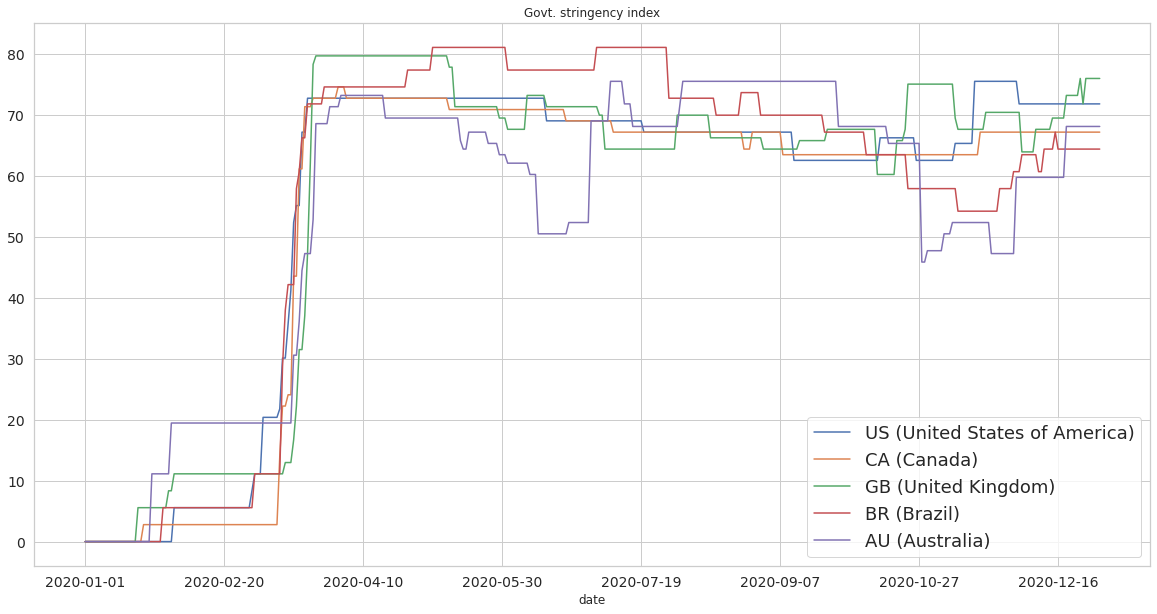

In [223]:

def plot_gov_time_series(country_list):
  fig, ax = plt.subplots(1,1,figsize=(20,10))
  for country in country_list:
    df = df_gov[df_gov.location_key == country]
    df.plot(ax=ax, x='date', y='stringency_index', label=key_name(country), title='Govt. stringency index')

plot_gov_time_series(['US', 'CA', 'GB', 'BR', 'AU'])

# Weather

In [300]:
cols_weather = table_cols['weather']
df_weather_all = read_data(cols_weather) # takes several minutes

In [359]:
df_weather_all = df_weather_all.dropna()
df_weather_all['date']= pd.to_datetime(df_weather_all['date'],format='%Y-%m-%d') # converts date to datetime object


print(df_weather_all.shape)
df_weather_all.sample(n=10, random_state=42)

(223775, 11)


,location_key,date,aggregation_level,population,average_temperature_celsius,minimum_temperature_celsius,maximum_temperature_celsius,rainfall_mm,snowfall_mm,dew_point,relative_humidity
3696963,ES_MD_28051,2020-02-06,2,2414.0,6.850000,2.750000,11.655556,0.000000,20.32,2.104938,73.372989
7061136,US_IA_19009,2020-01-30,2,5550.0,-1.838889,-3.777778,0.922222,0.084667,50.80,-2.650794,92.602742
7522887,US_ND_38085,2020-10-21,2,4425.0,-1.763889,-5.451389,2.972222,1.270000,30.48,-4.865079,79.383854
2582202,CN_NM,2020-01-01,1,24706321.0,-18.322222,-25.877778,-11.483333,0.000000,30.48,-22.461111,70.535698
3285604,ES_CT_08016,2020-01-22,2,2140.0,9.194444,5.550000,12.044444,45.945778,20.32,8.125000,92.213952
8020006,US_WI_55117,2020-01-20,2,115089.0,-6.927778,-10.622222,-3.972222,0.000000,129.54,-11.351852,73.467993
3486053,ES_CT_17125,2020-11-04,2,169.0,11.033333,8.083333,13.955556,6.716889,20.32,7.105556,78.470628
4760813,IT_36,2020-10-17,1,1215220.0,6.222222,2.690476,10.777778,0.762000,599.44,4.296296,83.439813
7627254,US_OH_39061,2020-12-17,2,814170.0,-0.627778,-1.788889,1.233333,2.603500,30.48,-2.422222,87.798121
3716425,ES_MD_28086,2020-04-10,2,9287.0,11.211111,9.388889,14.155556,10.526889,10.16,9.765432,91.294585


## Meta-data

In [360]:
#@title HTML
tbl_html = '''
<table>
<thead>
<tr>
<th>Name</th>
<th>Type</th>
<th>Description</th>
<th>Example</th>
</tr>
</thead>
<tbody>
<tr>
<td><strong>date</strong></td>
<td><code>string</code></td>
<td>ISO 8601 date (YYYY-MM-DD) of the datapoint</td>
<td>2020-03-30</td>
</tr>
<tr>
<td><strong>key</strong></td>
<td><code>string</code></td>
<td>Unique string identifying the region</td>
<td>US_CA</td>
</tr>
<tr>
<td><strong>noaa_station*</strong></td>
<td><code>string</code></td>
<td>Identifier for the weather station</td>
<td>USC00206080</td>
</tr>
<tr>
<td><strong>noaa_distance*</strong></td>
<td><code>double</code> <code>[kilometers]</code></td>
<td>Distance between the location coordinates and the weather station</td>
<td>28.693</td>
</tr>
<tr>
<td><strong>average_temperature</strong></td>
<td><code>double</code> <code>[celsius]</code></td>
<td>Recorded hourly average temperature</td>
<td>11.22</td>
</tr>
<tr>
<td><strong>minimum_temperature</strong></td>
<td><code>double</code> <code>[celsius]</code></td>
<td>Recorded hourly minimum temperature</td>
<td>1.74</td>
</tr>
<tr>
<td><strong>maximum_temperature</strong></td>
<td><code>double</code> <code>[celsius]</code></td>
<td>Recorded hourly maximum temperature</td>
<td>19.42</td>
</tr>
<tr>
<td><strong>rainfall</strong></td>
<td><code>double</code> <code>[millimeters]</code></td>
<td>Rainfall during the entire day</td>
<td>51.0</td>
</tr>
<tr>
<td><strong>snowfall</strong></td>
<td><code>double</code> <code>[millimeters]</code></td>
<td>Snowfall during the entire day</td>
<td>0.0</td>
</tr>
<tr>
<td><strong>dew_point</strong></td>
<td><code>double</code> <code>[celsius]</code></td>
<td>Temperature to which air must be cooled to become saturated with water vapor</td>
<td>10.88</td>
</tr>
<tr>
<td><strong>relative_humidity</strong></td>
<td><code>double</code> <code>[%]</code></td>
<td>The amount of water vapor present in air expressed as a percentage of the amount needed for saturation at the same temperature</td>
<td>43.09</td>
</tr>
</tbody>
</table>
<p>*The reported data corresponds to the average of the nearest 10 stations within a 300km radius. The
columns <code>noaa_station</code> and <code>noaa_distance</code> refer to the nearest station only.</p>
<h2><a id="user-content-sources-of-data" class="anchor" aria-hidden="true" href="#sources-of-data"><svg class="octicon octicon-link" viewBox="0 0 16 16" version="1.1" width="16" height="16" aria-hidden="true"><path fill-rule="evenodd" d="M7.775 3.275a.75.75 0 001.06 1.06l1.25-1.25a2 2 0 112.83 2.83l-2.5 2.5a2 2 0 01-2.83 0 .75.75 0 00-1.06 1.06 3.5 3.5 0 004.95 0l2.5-2.5a3.5 3.5 0 00-4.95-4.95l-1.25 1.25zm-4.69 9.64a2 2 0 010-2.83l2.5-2.5a2 2 0 012.83 0 .75.75 0 001.06-1.06 3.5 3.5 0 00-4.95 0l-2.5 2.5a3.5 3.5 0 004.95 4.95l1.25-1.25a.75.75 0 00-1.06-1.06l-1.25 1.25a2 2 0 01-2.83 0z"></path></svg></a>Sources of data</h2>
<details>
<summary>Show data sources</summary>
<table>
<thead>
<tr>
<th>Data</th>
<th>Source</th>
<th>License and Terms of Use</th>
</tr>
</thead>
<tbody>
<tr>
<td>Weather</td>
<td><a href="https://www.ncei.noaa.gov" rel="nofollow">NOAA</a></td>
<td><a href="https://www.wmo.int/pages/prog/www/ois/Operational_Information/Publications/Congress/Cg_XII/res40_en.html" rel="nofollow">Attribution required, non-commercial use</a></td>
</tr>
</tbody>
</table>
</details>
</article>
  </div>

    </div>

  

  <details class="details-reset details-overlay details-overlay-dark" id="jumpto-line-details-dialog">
    <summary data-hotkey="l" aria-label="Jump to line"></summary>
    <details-dialog class="Box Box--overlay d-flex flex-column anim-fade-in fast linejump" aria-label="Jump to line">
      <!-- '"` --><!-- </textarea></xmp> --></option></form><form class="js-jump-to-line-form Box-body d-flex" action="" accept-charset="UTF-8" method="get">
        <input class="form-control flex-auto mr-3 linejump-input js-jump-to-line-field" type="text" placeholder="Jump to line&hellip;" aria-label="Jump to line" autofocus>
        <button type="submit" class="btn" data-close-dialog>Go</button>
</form>    </details-dialog>
  </details>

    <div class="Popover anim-scale-in js-tagsearch-popover"
     hidden
     data-tagsearch-url="/GoogleCloudPlatform/covid-19-open-data/find-definition"
     data-tagsearch-ref="main"
     data-tagsearch-path="docs/table-weather.md"
     data-tagsearch-lang="Markdown"
     data-hydro-click="{&quot;event_type&quot;:&quot;code_navigation.click_on_symbol&quot;,&quot;payload&quot;:{&quot;action&quot;:&quot;click_on_symbol&quot;,&quot;repository_id&quot;:282079576,&quot;ref&quot;:&quot;main&quot;,&quot;language&quot;:&quot;Markdown&quot;,&quot;originating_url&quot;:&quot;https://github.com/GoogleCloudPlatform/covid-19-open-data/blob/main/docs/table-weather.md&quot;,&quot;user_id&quot;:4632336}}"
     data-hydro-click-hmac="933c923a8da0bc56ec6901cda25972079dcc359513d8526e489902bbb39da138">
  <div class="Popover-message Popover-message--large Popover-message--top-left TagsearchPopover mt-1 mb-4 mx-auto Box box-shadow-large">
    <div class="TagsearchPopover-content js-tagsearch-popover-content overflow-auto" style="will-change:transform;">
    </div>
  </div>
</div>


</div>
'''

In [303]:
tables = pd.read_html(tbl_html)
display(tables[0])
display(tables[1])

,Name,Type,Description,Example
0,date,string,ISO 8601 date (YYYY-MM-DD) of the datapoint,2020-03-30
1,key,string,Unique string identifying the region,US_CA
2,noaa_station*,string,Identifier for the weather station,USC00206080
3,noaa_distance*,double [kilometers],Distance between the location coordinates and the weather station,28.693
4,average_temperature,double [celsius],Recorded hourly average temperature,11.22
5,minimum_temperature,double [celsius],Recorded hourly minimum temperature,1.74
6,maximum_temperature,double [celsius],Recorded hourly maximum temperature,19.42
7,rainfall,double [millimeters],Rainfall during the entire day,51.0
8,snowfall,double [millimeters],Snowfall during the entire day,0.0
9,dew_point,double [celsius],Temperature to which air must be cooled to become saturated with water vapor,10.88


,Data,Source,License and Terms of Use
0,Weather,NOAA,"Attribution required, non-commercial use"


In [361]:


df = pd.read_html(tbl_html)[0]
df = df.drop(columns = 'Example')
feature_names = df.Name.values
feature_sources = ['NOAA' for f in feature_names]
df_sources = pd.DataFrame({'Sources': feature_sources})
#df = pd.concat([df, df_sources], axis=1)
df = df[df.Name != 'date']
df = df[df.Name != 'key']
display(df)

,Name,Type,Description
2,noaa_station*,string,Identifier for the weather station
3,noaa_distance*,double [kilometers],Distance between the location coordinates and the weather station
4,average_temperature,double [celsius],Recorded hourly average temperature
5,minimum_temperature,double [celsius],Recorded hourly minimum temperature
6,maximum_temperature,double [celsius],Recorded hourly maximum temperature
7,rainfall,double [millimeters],Rainfall during the entire day
8,snowfall,double [millimeters],Snowfall during the entire day
9,dew_point,double [celsius],Temperature to which air must be cooled to become saturated with water vapor
10,relative_humidity,double [%],The amount of water vapor present in air expressed as a percentage of the amount needed for satu...


In [362]:
print(df.to_latex(index=False)) 

\begin{tabular}{lll}
\toprule
                Name &                  Type &                                                                                          Description \\
\midrule
       noaa\_station* &                string &                                                                   Identifier for the weather station \\
      noaa\_distance* &   double [kilometers] &                                    Distance between the location coordinates and the weather station \\
 average\_temperature &      double [celsius] &                                                                  Recorded hourly average temperature \\
 minimum\_temperature &      double [celsius] &                                                                  Recorded hourly minimum temperature \\
 maximum\_temperature &      double [celsius] &                                                                  Recorded hourly maximum temperature \\
            rainfall &  double [millimeters] &    

# Mobility

In [306]:

cols_mob = table_cols['mobility']
df_mob_all = read_data(cols_mob) # takes several minutes

In [326]:
df_mob_all = df_mob_all.dropna()
df_mob_all['date']= pd.to_datetime(df_mob_all['date'],format='%Y-%m-%d') # converts date to datetime object
print(df_mob_all.shape)
df_mob_all.sample(n=10, random_state=42)

(733591, 10)


,location_key,date,aggregation_level,population,mobility_retail_and_recreation,mobility_grocery_and_pharmacy,mobility_parks,mobility_transit_stations,mobility_workplaces,mobility_residential
6881617,US_AL_01101,2020-08-04,2,227265.0,-9.0,1.0,4.0,-10.0,-30.0,9.0
7582220,US_NM_35043,2020-12-01,2,142689.0,-18.0,8.0,-31.0,-37.0,-47.0,18.0
3873311,GH,2020-12-04,0,30417856.0,7.0,27.0,-9.0,18.0,-8.0,9.0
2112647,BR_SP_350610,2020-07-24,2,75035.0,-26.0,11.0,-12.0,-60.0,-5.0,10.0
1174771,BR_MT_510340,2020-08-15,2,551098.0,-26.0,9.0,-47.0,-23.0,-5.0,9.0
4673902,IN_TG_MDK,2020-05-01,2,3031877.0,-80.0,-28.0,-81.0,-65.0,-63.0,33.0
7389299,US_MO_29077,2020-09-13,2,289512.0,0.0,2.0,74.0,3.0,-14.0,1.0
7576739,US_NM_35015,2020-12-10,2,57108.0,-42.0,-14.0,-32.0,-34.0,-34.0,13.0
7916553,US_UT,2020-05-24,1,2763885.0,-7.0,14.0,193.0,-25.0,-28.0,2.0
4794147,IT_BZ,2020-11-14,1,531178.0,-75.0,-28.0,-55.0,-60.0,-41.0,19.0


In [327]:

# Exract country-level data
df_mob = df_mob_all[df_mob_all.aggregation_level == 0]
print(df_mob.shape)
df_mob.sample(n=10, random_state=42)

(41334, 10)


,location_key,date,aggregation_level,population,mobility_retail_and_recreation,mobility_grocery_and_pharmacy,mobility_parks,mobility_transit_stations,mobility_workplaces,mobility_residential
6762958,RW,2020-05-21,0,1.262695e+07,-33.0,-23.0,-8.0,-31.0,-28.0,15.0
3911252,IE,2020-08-03,0,4.904240e+06,-11.0,-7.0,193.0,-39.0,-74.0,15.0
3872004,GE,2020-05-09,0,3.720382e+06,-66.0,-41.0,-33.0,-59.0,-44.0,15.0
3893671,HR,2020-07-21,0,4.076246e+06,21.0,15.0,366.0,-12.0,-28.0,1.0
4457749,IN,2020-10-01,0,1.366418e+09,-39.0,2.0,-46.0,-24.0,-29.0,12.0
3911332,IE,2020-10-22,0,4.904240e+06,-51.0,-2.0,6.0,-54.0,-37.0,16.0
3010530,CR,2020-06-28,0,5.047561e+06,-61.0,-36.0,-64.0,-63.0,-26.0,19.0
5791022,MZ,2020-10-28,0,3.036604e+07,-12.0,-2.0,-17.0,-17.0,-8.0,3.0
4795498,JO,2020-07-24,0,1.010169e+07,2.0,12.0,33.0,-65.0,-5.0,1.0
5797244,NI,2020-10-28,0,6.545502e+06,-18.0,-1.0,-18.0,-13.0,-6.0,6.0


In [309]:

countries = set(df_mob['location_key'].values)
print(len(countries)) # country level data for 134 countries
print(countries)

(41334, 10)
132
{'PA', 'GT', 'PR', 'EE', 'NP', 'CR', 'NZ', 'BO', 'PT', 'CA', 'KR', 'NE', 'BY', 'OM', 'HK', 'AT', 'JO', 'BW', 'AG', 'BS', 'SI', 'SV', 'ML', 'LT', 'BG', 'MM', 'NG', 'SK', 'MU', 'HN', 'IL', 'BR', 'CZ', 'AO', 'KW', 'IT', 'AF', 'DK', 'SA', 'MA', 'BJ', 'YE', 'RU', 'PY', 'TW', 'BA', 'DO', 'VN', 'CH', 'LY', 'GB', 'HU', 'BB', 'NO', 'IN', 'NL', 'MK', 'ES', 'LV', 'LA', 'PG', 'MD', 'KE', 'FR', 'TJ', 'BE', 'NA', 'GA', 'GE', 'KH', 'MY', 'RS', 'HR', 'PL', 'LU', 'GR', 'SE', 'US', 'BZ', 'PH', 'TR', 'PE', 'LB', 'TT', 'CM', 'CL', 'UA', 'VE', 'QA', 'KZ', 'LK', 'FI', 'RW', 'CO', 'MT', 'AW', 'AU', 'EC', 'CI', 'MN', 'TG', 'HT', 'PK', 'MZ', 'MX', 'JM', 'NI', 'SG', 'FJ', 'JP', 'BD', 'RO', 'BF', 'BH', 'TZ', 'AR', 'ZW', 'IQ', 'DE', 'CV', 'TH', 'ZM', 'ZA', 'SN', 'AE', 'ID', 'GH', 'UY', 'IE', 'EG', 'KG', 'UG'}


In [310]:
df = df_mob[df_mob['location_key'] == 'GB']
df.head()


,location_key,date,aggregation_level,population,mobility_retail_and_recreation,mobility_grocery_and_pharmacy,mobility_parks,mobility_transit_stations,mobility_workplaces,mobility_residential
3799452,GB,2020-02-15,0,66647112.0,-12.0,-7.0,-35.0,-12.0,-4.0,2.0
3799453,GB,2020-02-16,0,66647112.0,-7.0,-6.0,-28.0,-7.0,-3.0,1.0
3799454,GB,2020-02-17,0,66647112.0,10.0,1.0,24.0,-2.0,-14.0,2.0
3799455,GB,2020-02-18,0,66647112.0,7.0,-1.0,20.0,-3.0,-14.0,2.0
3799456,GB,2020-02-19,0,66647112.0,6.0,-2.0,8.0,-4.0,-14.0,3.0


## Meta-data

In [311]:
#@title HTML
tbl_html = '''
<table>
<thead>
<tr>
<th>Name</th>
<th>Type</th>
<th>Description</th>
<th>Example</th>
</tr>
</thead>
<tbody>
<tr>
<td><strong>date</strong></td>
<td><code>string</code></td>
<td>ISO 8601 date (YYYY-MM-DD) of the datapoint</td>
<td>2020-03-30</td>
</tr>
<tr>
<td><strong>key</strong></td>
<td><code>string</code></td>
<td>Unique string identifying the region</td>
<td>US_CA</td>
</tr>
<tr>
<td><strong>mobility_grocery_and_pharmacy</strong></td>
<td><code>double</code> <code>[%]</code></td>
<td>Percentage change in visits to places like grocery markets, food warehouses, farmers markets, specialty food shops, drug stores, and pharmacies compared to baseline</td>
<td>-15</td>
</tr>
<tr>
<td><strong>mobility_parks</strong></td>
<td><code>double</code> <code>[%]</code></td>
<td>Percentage change in visits to places like local parks, national parks, public beaches, marinas, dog parks, plazas, and public gardens compared to baseline</td>
<td>-15</td>
</tr>
<tr>
<td><strong>mobility_transit_stations</strong></td>
<td><code>double</code> <code>[%]</code></td>
<td>Percentage change in visits to places like public transport hubs such as subway, bus, and train stations compared to baseline</td>
<td>-15</td>
</tr>
<tr>
<td><strong>mobility_retail_and_recreation</strong></td>
<td><code>double</code> <code>[%]</code></td>
<td>Percentage change in visits to restaurants, cafes, shopping centers, theme parks, museums, libraries, and movie theaters compared to baseline</td>
<td>-15</td>
</tr>
<tr>
<td><strong>mobility_residential</strong></td>
<td><code>double</code> <code>[%]</code></td>
<td>Percentage change in visits to places of residence compared to baseline</td>
<td>-15</td>
</tr>
<tr>
<td><strong>mobility_workplaces</strong></td>
<td><code>double</code> <code>[%]</code></td>
<td>Percentage change in visits to places of work compared to baseline</td>
<td>-15</td>
</tr>
</tbody>
</table>
<h2><a id="user-content-sources-of-data" class="anchor" aria-hidden="true" href="#sources-of-data"><svg class="octicon octicon-link" viewBox="0 0 16 16" version="1.1" width="16" height="16" aria-hidden="true"><path fill-rule="evenodd" d="M7.775 3.275a.75.75 0 001.06 1.06l1.25-1.25a2 2 0 112.83 2.83l-2.5 2.5a2 2 0 01-2.83 0 .75.75 0 00-1.06 1.06 3.5 3.5 0 004.95 0l2.5-2.5a3.5 3.5 0 00-4.95-4.95l-1.25 1.25zm-4.69 9.64a2 2 0 010-2.83l2.5-2.5a2 2 0 012.83 0 .75.75 0 001.06-1.06 3.5 3.5 0 00-4.95 0l-2.5 2.5a3.5 3.5 0 004.95 4.95l1.25-1.25a.75.75 0 00-1.06-1.06l-1.25 1.25a2 2 0 01-2.83 0z"></path></svg></a>Sources of data</h2>
<details>
<summary>Show data sources</summary>
<table>
<thead>
<tr>
<th>Data</th>
<th>Source</th>
<th>License and Terms of Use</th>
</tr>
</thead>
<tbody>
<tr>
<td>Google Mobility data</td>
<td><a href="https://www.google.com/covid19/mobility/" rel="nofollow">https://www.google.com/covid19/mobility/</a></td>
<td><a href="https://policies.google.com/terms" rel="nofollow">Google Terms of Service</a></td>
</tr>
</tbody>
</table>
</details>
</article>
  </div>

    </div>
 '''   

In [312]:
tables = pd.read_html(tbl_html)
display(tables[0])
display(tables[1])

,Name,Type,Description,Example
0,date,string,ISO 8601 date (YYYY-MM-DD) of the datapoint,2020-03-30
1,key,string,Unique string identifying the region,US_CA
2,mobility_grocery_and_pharmacy,double [%],"Percentage change in visits to places like grocery markets, food warehouses, farmers markets, sp...",-15
3,mobility_parks,double [%],"Percentage change in visits to places like local parks, national parks, public beaches, marinas,...",-15
4,mobility_transit_stations,double [%],"Percentage change in visits to places like public transport hubs such as subway, bus, and train ...",-15
5,mobility_retail_and_recreation,double [%],"Percentage change in visits to restaurants, cafes, shopping centers, theme parks, museums, libra...",-15
6,mobility_residential,double [%],Percentage change in visits to places of residence compared to baseline,-15
7,mobility_workplaces,double [%],Percentage change in visits to places of work compared to baseline,-15


,Data,Source,License and Terms of Use
0,Google Mobility data,https://www.google.com/covid19/mobility/,Google Terms of Service


In [332]:

df = pd.read_html(tbl_html)[0]
df = df.drop(columns = 'Example')
feature_names = df.Name.values
feature_sources = ['Google' for f in feature_names]
#df_sources = pd.DataFrame({'Sources': feature_sources})
#df = pd.concat([df, df_sources], axis=1)
df = df[df.Name != 'date']
df = df[df.Name != 'key']
display(df)

,Name,Type,Description
2,mobility_grocery_and_pharmacy,double [%],"Percentage change in visits to places like grocery markets, food warehouses, farmers markets, sp..."
3,mobility_parks,double [%],"Percentage change in visits to places like local parks, national parks, public beaches, marinas,..."
4,mobility_transit_stations,double [%],"Percentage change in visits to places like public transport hubs such as subway, bus, and train ..."
5,mobility_retail_and_recreation,double [%],"Percentage change in visits to restaurants, cafes, shopping centers, theme parks, museums, libra..."
6,mobility_residential,double [%],Percentage change in visits to places of residence compared to baseline
7,mobility_workplaces,double [%],Percentage change in visits to places of work compared to baseline


In [333]:
print(df.to_latex(index=False)) 

\begin{tabular}{lll}
\toprule
                           Name &        Type &                                                                                          Description \\
\midrule
  mobility\_grocery\_and\_pharmacy &  double [\%] &  Percentage change in visits to places like grocery markets, food warehouses, farmers markets, sp... \\
                 mobility\_parks &  double [\%] &  Percentage change in visits to places like local parks, national parks, public beaches, marinas,... \\
      mobility\_transit\_stations &  double [\%] &  Percentage change in visits to places like public transport hubs such as subway, bus, and train ... \\
 mobility\_retail\_and\_recreation &  double [\%] &  Percentage change in visits to restaurants, cafes, shopping centers, theme parks, museums, libra... \\
           mobility\_residential &  double [\%] &                              Percentage change in visits to places of residence compared to baseline \\
            mobility\_workplaces &

## Plots

In [315]:
# comptue average mobility index for each country.
# We standardize each column  since they have very different magnitudes

from sklearn import preprocessing

def standardize_col(df):
  x = df.to_numpy()
  min_max_scaler = preprocessing.StandardScaler()
  x_scaled = min_max_scaler.fit_transform(x.reshape(-1,1))
  return x_scaled

def compute_avg_mobility(df):
  mob_names = table_cols['mobility']
  mob = standardize_col(df[mob_names[0]])
  N = len(mob_names)
  for i in range(1, N):
    mob += mob + standardize_col(df[mob_names[i]])
  mob = mob / N 
  df = df.assign(mobility_index=mob)
  return df


In [328]:
df = df_mob.copy()
df2 = compute_avg_mobility(df)
df2.columns

Index(['location_key', 'date', 'aggregation_level', 'population', 'mobility_retail_and_recreation', 'mobility_grocery_and_pharmacy', 'mobility_parks', 'mobility_transit_stations', 'mobility_workplaces', 'mobility_residential', 'mobility_index'], dtype='object')

In [330]:


def plot_mob_time_series(country_list, col='mobility_index', annotate_outliers=False):
  fig, ax = plt.subplots(1,1,figsize=(20,10))
  for country in country_list:
    df = df_mob[df_mob['location_key'] == country]
    df = compute_avg_mobility(df) 
    ax.plot(df.date, df[col].rolling(window=14).mean(), label=key_name(country))
  ax.legend()
  ax.set_title(col)



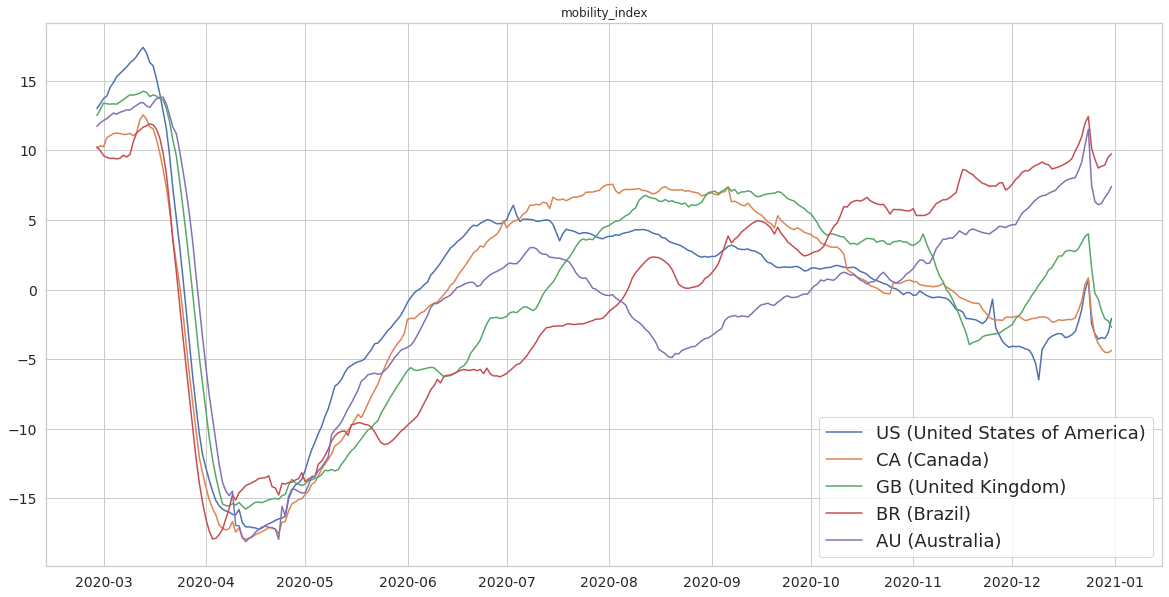

In [331]:
plot_mob_time_series(['US', 'CA', 'GB', 'BR', 'AU'])


# Google search trends

In [363]:

cols_search = table_cols['google-search-trends']
df_search_all = read_data(cols_search) # takes several minutes

ValueError: ignored

In [366]:
print(len(table_cols['google-search-trends']))
print(table_cols['google-search-trends'])

422
['search_trends_abdominal_obesity', 'search_trends_abdominal_pain', 'search_trends_acne', 'search_trends_actinic_keratosis', 'search_trends_acute_bronchitis', 'search_trends_adrenal_crisis', 'search_trends_ageusia', 'search_trends_alcoholism', 'search_trends_allergic_conjunctivitis', 'search_trends_allergy', 'search_trends_amblyopia', 'search_trends_amenorrhea', 'search_trends_amnesia', 'search_trends_anal_fissure', 'search_trends_anaphylaxis', 'search_trends_anemia', 'search_trends_angina_pectoris', 'search_trends_angioedema', 'search_trends_angular_cheilitis', 'search_trends_anosmia', 'search_trends_anxiety', 'search_trends_aphasia', 'search_trends_aphonia', 'search_trends_apnea', 'search_trends_arthralgia', 'search_trends_arthritis', 'search_trends_ascites', 'search_trends_asperger_syndrome', 'search_trends_asphyxia', 'search_trends_asthma', 'search_trends_astigmatism', 'search_trends_ataxia', 'search_trends_atheroma', 'search_trends_attention_deficit_hyperactivity_disorder', 's

In [367]:
search_cols = [col for col in COLUMNS if col.startswith('search_trends_')]
print(len(search_cols))
print(search_cols)


421
['search_trends_abdominal_obesity', 'search_trends_abdominal_pain', 'search_trends_acne', 'search_trends_actinic_keratosis', 'search_trends_acute_bronchitis', 'search_trends_adrenal_crisis', 'search_trends_ageusia', 'search_trends_alcoholism', 'search_trends_allergic_conjunctivitis', 'search_trends_allergy', 'search_trends_amblyopia', 'search_trends_amenorrhea', 'search_trends_amnesia', 'search_trends_anal_fissure', 'search_trends_anaphylaxis', 'search_trends_anemia', 'search_trends_angina_pectoris', 'search_trends_angioedema', 'search_trends_angular_cheilitis', 'search_trends_anosmia', 'search_trends_anxiety', 'search_trends_aphasia', 'search_trends_aphonia', 'search_trends_apnea', 'search_trends_arthralgia', 'search_trends_arthritis', 'search_trends_ascites', 'search_trends_asperger_syndrome', 'search_trends_asphyxia', 'search_trends_asthma', 'search_trends_astigmatism', 'search_trends_ataxia', 'search_trends_atheroma', 'search_trends_attention_deficit_hyperactivity_disorder', 's

In [ ]:
#df_search_all = read_data(search_cols) # takes several minutes - too big 

# Demographics

In [13]:

cols_demo = table_cols['demographics']
df_demo_all = read_data(cols_demo) # takes several minutes

In [14]:
df_demo_all = df_demo_all.dropna()
print(df_demo_all.shape)
df_demo_all.sample(n=10, random_state=42)

(41724, 21)


,location_key,date,aggregation_level,population,population_male,population_female,population_rural,population_urban,population_density,human_development_index,population_age_00_09,population_age_10_19,population_age_20_29,population_age_30_39,population_age_40_49,population_age_50_59,population_age_60_69,population_age_70_79,population_age_80_and_older,population_largest_city,population_clustered
3873214,GH,2020-08-29,0,3.041786e+07,15416085.0,15001771.0,13168802.0,17249054.0,130.821429,0.592,7168853.0,6912477.0,6211536.0,4882550.0,3531490.0,2435248.0,1294343.0,563765.0,201612.0,3205586.0,5680794.0
260893,AZ,2020-07-24,0,1.002332e+07,5003653.0,5019665.0,4407153.0,5616165.0,120.234317,0.751,1679522.0,1347195.0,1625993.0,1784550.0,1292261.0,1288615.0,805218.0,241705.0,140443.0,2313138.0,2313138.0
2574751,CN,2020-04-05,0,1.397715e+09,717118675.0,680596325.0,554781038.0,842933962.0,148.348833,0.752,118245654.0,114652581.0,134049256.0,167880817.0,152619930.0,158614140.0,106283266.0,51361562.0,19772969.0,26317104.0,398976116.0
3010464,CR,2020-04-23,0,5.047561e+06,2522539.0,2525022.0,1005676.0,4041885.0,97.913063,0.794,663801.0,695606.0,777549.0,771435.0,621863.0,573455.0,395964.0,224811.0,109050.0,1378546.0,1378546.0
6830286,TR,2020-05-05,0,8.200388e+07,41139980.0,40863902.0,20331797.0,63097818.0,106.200000,0.820,12843906.0,12764690.0,12823598.0,12909225.0,11156733.0,8873665.0,6058068.0,3119472.0,1454525.0,14967667.0,30836753.0
8054051,UY,2020-01-27,0,3.461734e+06,1671890.0,1789844.0,158340.0,3303394.0,19.708028,0.804,462857.0,476883.0,496818.0,448012.0,441956.0,377233.0,316186.0,211983.0,147206.0,1744700.0,1744700.0
2440816,CI,2020-04-26,0,2.571654e+07,12974201.0,12742343.0,12539644.0,13176900.0,78.834053,0.492,7827514.0,6050793.0,4673441.0,3163855.0,2151789.0,1414651.0,868013.0,346042.0,69279.0,5058550.0,5058550.0
6762884,RW,2020-03-08,0,1.262695e+07,6206092.0,6420858.0,10440846.0,2186104.0,498.659870,0.524,3477345.0,3512686.0,2005918.0,2053604.0,1119797.0,699613.0,479528.0,134703.0,49318.0,1094796.0,1094796.0
3225339,DZ,2020-05-26,0,4.305305e+07,21749666.0,21303388.0,11542954.0,31510100.0,17.730075,0.754,9292374.0,6889546.0,6677288.0,7443049.0,5582325.0,3876315.0,2584988.0,1256806.0,584039.0,2729325.0,2729325.0
4740814,IQ,2020-02-25,0,3.930978e+07,19891811.0,19417972.0,11526415.0,27783368.0,88.530570,0.685,12777787.0,9868090.0,7567505.0,5593799.0,4130533.0,2419696.0,1321451.0,591112.0,199029.0,6974439.0,9877181.0


## Meta-data


In [72]:
#@title HTML
tbl_html = '''
<table>
<thead>
<tr>
<th>Name</th>
<th>Type</th>
<th>Description</th>
<th>Example</th>
</tr>
</thead>
<tbody>
<tr>
<td><strong>key</strong></td>
<td><code>string</code></td>
<td>Unique string identifying the region</td>
<td>KR</td>
</tr>
<tr>
<td><strong>population</strong></td>
<td><code>integer</code></td>
<td>Total count of humans</td>
<td>51606633</td>
</tr>
<tr>
<td><strong>population_male</strong></td>
<td><code>integer</code></td>
<td>Total count of males</td>
<td>25846211</td>
</tr>
<tr>
<td><strong>population_female</strong></td>
<td><code>integer</code></td>
<td>Total count of females</td>
<td>25760422</td>
</tr>
<tr>
<td><strong>rural_population</strong></td>
<td><code>integer</code></td>
<td>Population in a rural area</td>
<td>9568386</td>
</tr>
<tr>
<td><strong>urban_population</strong></td>
<td><code>integer</code></td>
<td>Population in an urban area</td>
<td>42038247</td>
</tr>
<tr>
<td><strong>largest_city_population</strong></td>
<td><code>integer</code></td>
<td>Population in the largest city of the region</td>
<td>9963497</td>
</tr>
<tr>
<td><strong>clustered_population</strong></td>
<td><code>integer</code></td>
<td>Population in urban agglomerations of more than 1 million</td>
<td>25893097</td>
</tr>
<tr>
<td><strong>population_density</strong></td>
<td><code>double</code> <code>[persons per squared kilometer]</code></td>
<td>Population per squared kilometer of land area</td>
<td>529.3585</td>
</tr>
<tr>
<td><strong>human_development_index</strong></td>
<td><code>double</code> <code>[0-1]</code></td>
<td>Composite index of life expectancy, education, and per capita income indicators</td>
<td>0.903</td>
</tr>
<tr>
<td><strong>population_age_<code>${lower}</code>_<code>${upper}</code>*</strong></td>
<td><code>integer</code></td>
<td>Estimated population between the ages of <code>${lower}</code> and <code>${upper}</code>, both inclusive</td>
<td>42038247</td>
</tr>
<tr>
<td><strong>population_age_80_and_older*</strong></td>
<td><code>integer</code></td>
<td>Estimated population over the age of 80</td>
<td>477081</td>
</tr>
</tbody>
</table>
<p>*Structured population data is estimated from the WorldPop project. Refer to the
<a href="https://www.worldpop.org/geodata/summary?id=24798" rel="nofollow">WorldPop documentation</a> for more details.</p>
<h2><a id="user-content-sources-of-data" class="anchor" aria-hidden="true" href="#sources-of-data"><svg class="octicon octicon-link" viewBox="0 0 16 16" version="1.1" width="16" height="16" aria-hidden="true"><path fill-rule="evenodd" d="M7.775 3.275a.75.75 0 001.06 1.06l1.25-1.25a2 2 0 112.83 2.83l-2.5 2.5a2 2 0 01-2.83 0 .75.75 0 00-1.06 1.06 3.5 3.5 0 004.95 0l2.5-2.5a3.5 3.5 0 00-4.95-4.95l-1.25 1.25zm-4.69 9.64a2 2 0 010-2.83l2.5-2.5a2 2 0 012.83 0 .75.75 0 001.06-1.06 3.5 3.5 0 00-4.95 0l-2.5 2.5a3.5 3.5 0 004.95 4.95l1.25-1.25a.75.75 0 00-1.06-1.06l-1.25 1.25a2 2 0 01-2.83 0z"></path></svg></a>Sources of data</h2>
<details>
<summary>Show data sources</summary>
<table>
<thead>
<tr>
<th>Data</th>
<th>Source</th>
<th>License and Terms of Use</th>
</tr>
</thead>
<tbody>
<tr>
<td>Metadata</td>
<td><a href="https://wikidata.org" rel="nofollow">Wikipedia</a></td>
<td><a href="https://foundation.wikimedia.org/wiki/Terms_of_Use" rel="nofollow">Terms of Use</a></td>
</tr>
<tr>
<td>Metadata</td>
<td><a href="https://ec.europa.eu/eurostat" rel="nofollow">Eurostat</a></td>
<td><a href="https://ec.europa.eu/info/legal-notice_en#copyright-notice" rel="nofollow">CC BY</a></td>
</tr>
<tr>
<td>Demographics</td>
<td><a href="https://wikidata.org" rel="nofollow">Wikidata</a></td>
<td><a href="https://www.wikidata.org/wiki/Wikidata:Licensing" rel="nofollow">CC0</a></td>
</tr>
<tr>
<td>Demographics</td>
<td><a href="https://datacommons.org" rel="nofollow">DataCommons</a></td>
<td><a href="https://policies.google.com/terms" rel="nofollow">Attribution required</a></td>
</tr>
<tr>
<td>Demographics</td>
<td><a href="https://worldbank.org" rel="nofollow">WorldBank</a></td>
<td><a href="https://www.worldbank.org/en/about/legal/terms-of-use-for-datasets" rel="nofollow">CC BY</a></td>
</tr>
<tr>
<td>Demographics</td>
<td><a href="https://www.worldpop.org" rel="nofollow">WorldPop</a></td>
<td><a href="https://creativecommons.org/licenses/by/4.0/" rel="nofollow">CC BY</a></td>
</tr>
<tr>
<td>Argentina (2010 Census)</td>
<td><a href="https://www.indec.gob.ar/indec/web/Nivel4-Tema-2-41-135" rel="nofollow">Instituto Nacional de Estadística y Censos</a></td>
<td><a href="https://datos.gob.ar/acerca/seccion/marco-legal" rel="nofollow">Public domain</a></td>
</tr>
<tr>
<td>Chile (2017 Census)</td>
<td><a href="https://www.ine.cl/estadisticas/sociales/censos-de-poblacion-y-vivienda/poblacion-y-vivienda" rel="nofollow">Instituto Nacional de Estadística</a></td>
<td><a href="https://datos.gob.cl/" rel="nofollow">CC BY</a></td>
</tr>
<tr>
<td>Israel (2019 Census)</td>
<td><a href="https://www.cbs.gov.il/he/settlements/Pages/default.aspx?mode=Metropolin" rel="nofollow">Central Bureau of Statistics</a></td>
<td><a href="https://www.cbs.gov.il/en/Pages/Enduser-license.aspx" rel="nofollow">Attribution Required</a></td>
</tr>
<tr>
<td>Indonesia (2020 Census)</td>
<td>Central Bureau of Statistics</td>
<td><a href="https://www.bps.go.id/website/fileMenu/S&amp;K.pdf" rel="nofollow">Attribution required</a></td>
</tr>
<tr>
<td>Mexico (2010 Census)</td>
<td><a href="https://www.inegi.org.mx/programas/ccpv/2010/default.html" rel="nofollow">INEGI</a></td>
<td><a href="https://datos.gob.mx/libreusomx" rel="nofollow">Attribution Required</a></td>
</tr>
<tr>
<td>Peru (2017 Census)</td>
<td><a href="https://censos2017.inei.gob.pe/redatam/" rel="nofollow">INEI</a></td>
<td><a href="http://opendefinition.org/licenses/odc-by/" rel="nofollow">ODC BY</a></td>
</tr>
<tr>
<td>Philippines (2015 Census)</td>
<td><a href="https://psa.gov.ph/population-and-housing/statistical-tables" rel="nofollow">Philippine Statistics Authority</a></td>
<td><a href="https://psa.gov.ph/article/terms-use" rel="nofollow">Attribution Required</a></td>
</tr>
<tr>
<td>USA (2019 Census)</td>
<td><a href="https://www.census.gov/data/tables/time-series/demo/popest/2010s-counties-total.html" rel="nofollow">United States Census Bureau</a></td>
<td><a href="https://ask.census.gov/prweb/PRServletCustom?pyActivity=pyMobileSnapStart&amp;ArticleID=KCP-4726" rel="nofollow">Public Domain</a></td>
</tr>
</tbody>
</table>
</details>
</article>
  </div>

    </div>

'''

In [73]:
df = pd.read_html(tbl_html)[0]
df = df.drop(columns = 'Example')
df = df[df.Name != 'key']
display(df)

,Name,Type,Description
1,population,integer,Total count of humans
2,population_male,integer,Total count of males
3,population_female,integer,Total count of females
4,rural_population,integer,Population in a rural area
5,urban_population,integer,Population in an urban area
6,largest_city_population,integer,Population in the largest city of the region
7,clustered_population,integer,Population in urban agglomerations of more than 1 million
8,population_density,double [persons per squared kilometer],Population per squared kilometer of land area
9,human_development_index,double [0-1],"Composite index of life expectancy, education, and per capita income indicators"
10,population_age_${lower}_${upper}*,integer,"Estimated population between the ages of ${lower} and ${upper}, both inclusive"


In [74]:
print(df.to_latex(index=False)) 

\begin{tabular}{lll}
\toprule
                              Name &                                    Type &                                                                      Description \\
\midrule
                        population &                                 integer &                                                            Total count of humans \\
                   population\_male &                                 integer &                                                             Total count of males \\
                 population\_female &                                 integer &                                                           Total count of females \\
                  rural\_population &                                 integer &                                                       Population in a rural area \\
                  urban\_population &                                 integer &                                                      Population

# Economy

In [57]:

df_econ_all = read_table('economy') 
display(df_econ_all)

reading  https://storage.googleapis.com/covid19-open-data/v3/economy.csv


,location_key,gdp_usd,gdp_per_capita_usd,human_capital_index
0,AD,3.154058e+09,40886,NaN
1,AE,4.211423e+11,43103,0.659
2,AF,1.910135e+10,502,0.389
3,AG,1.727759e+09,17790,NaN
4,AL,1.527808e+10,5352,0.621
...,...,...,...,...
359,WS,8.506550e+08,4315,NaN
360,YE,2.759126e+10,968,0.369
361,ZA,3.514316e+11,6001,0.406
362,ZM,2.306472e+10,1291,0.396


In [58]:

#df_econ_all = df_econ_all.dropna()
print(df_econ_all.shape)
display(df_econ_all.sample(n=10, random_state=42))

(364, 4)


,location_key,gdp_usd,gdp_per_capita_usd,human_capital_index
193,IT_67,7.626824e+09,24780,NaN
33,BE_WHT,4.040211e+10,30090,NaN
15,AT_6,5.853213e+10,47200,NaN
347,TT,2.410020e+10,17276,0.613
57,CI,5.879221e+10,2286,0.353
183,IT_25,4.579164e+11,45548,NaN
76,CZ_53,NaN,19234,NaN
119,ES_GA,7.383262e+10,27376,NaN
152,GB_UKJ,4.154623e+11,45430,NaN
126,ES_RI,1.004515e+10,32096,NaN


## Meta-data

In [23]:
#@title HTML
tbl_html = '''
<table>
<thead>
<tr>
<th>Name</th>
<th>Name</th>
<th>Description</th>
<th>Example</th>
</tr>
</thead>
<tbody>
<tr>
<td><strong>key</strong></td>
<td><code>string</code></td>
<td>Unique string identifying the region</td>
<td>CN_HB</td>
</tr>
<tr>
<td><strong>gdp</strong></td>
<td><code>integer</code> <code>[USD]</code></td>
<td>Gross domestic product; monetary value of all finished goods and services</td>
<td>24450604878</td>
</tr>
<tr>
<td><strong>gdp_per_capita</strong></td>
<td><code>integer</code> <code>[USD]</code></td>
<td>Gross domestic product divided by total population</td>
<td>1148</td>
</tr>
<tr>
<td><strong>human_capital_index</strong></td>
<td><code>double</code> <code>[0-1]</code></td>
<td>Mobilization of the economic and professional potential of citizens</td>
<td>0.765</td>
</tr>
</tbody>
</table>
<h2><a id="user-content-sources-of-data" class="anchor" aria-hidden="true" href="#sources-of-data"><svg class="octicon octicon-link" viewBox="0 0 16 16" version="1.1" width="16" height="16" aria-hidden="true"><path fill-rule="evenodd" d="M7.775 3.275a.75.75 0 001.06 1.06l1.25-1.25a2 2 0 112.83 2.83l-2.5 2.5a2 2 0 01-2.83 0 .75.75 0 00-1.06 1.06 3.5 3.5 0 004.95 0l2.5-2.5a3.5 3.5 0 00-4.95-4.95l-1.25 1.25zm-4.69 9.64a2 2 0 010-2.83l2.5-2.5a2 2 0 012.83 0 .75.75 0 001.06-1.06 3.5 3.5 0 00-4.95 0l-2.5 2.5a3.5 3.5 0 004.95 4.95l1.25-1.25a.75.75 0 00-1.06-1.06l-1.25 1.25a2 2 0 01-2.83 0z"></path></svg></a>Sources of data</h2>
<details>
<summary>Show data sources</summary>
<table>
<thead>
<tr>
<th>Data</th>
<th>Source</th>
<th>License and Terms of Use</th>
</tr>
</thead>
<tbody>
<tr>
<td>Metadata</td>
<td><a href="https://wikidata.org" rel="nofollow">Wikipedia</a></td>
<td><a href="https://foundation.wikimedia.org/wiki/Terms_of_Use" rel="nofollow">Terms of Use</a></td>
</tr>
<tr>
<td>Metadata</td>
<td><a href="https://ec.europa.eu/eurostat" rel="nofollow">Eurostat</a></td>
<td><a href="https://ec.europa.eu/info/legal-notice_en#copyright-notice" rel="nofollow">CC BY</a></td>
</tr>
<tr>
<td>Economy</td>
<td><a href="https://wikidata.org" rel="nofollow">Wikidata</a></td>
<td><a href="https://www.wikidata.org/wiki/Wikidata:Licensing" rel="nofollow">CC0</a></td>
</tr>
<tr>
<td>Economy</td>
<td><a href="https://datacommons.org" rel="nofollow">DataCommons</a></td>
<td><a href="https://policies.google.com/terms" rel="nofollow">Attribution required</a></td>
</tr>
<tr>
<td>Economy</td>
<td><a href="https://worldbank.org" rel="nofollow">WorldBank</a></td>
<td><a href="https://www.worldbank.org/en/about/legal/terms-of-use-for-datasets" rel="nofollow">CC BY</a></td>
</tr>
</tbody>
</table>
</details>
</article>
  </div>

    </div>
'''

In [22]:
df = pd.read_html(tbl_html)[0]
df = df.drop(columns = 'Example')
df = df[df.Name != 'key']
display(df)

,Name,Name.1,Description
1,gdp,integer [USD],Gross domestic product; monetary value of all ...
2,gdp_per_capita,integer [USD],Gross domestic product divided by total popula...
3,human_capital_index,double [0-1],Mobilization of the economic and professional ...


In [24]:
print(df.to_latex(index=False)) 

\begin{tabular}{lll}
\toprule
                Name &         Name.1 &                                        Description \\
\midrule
                 gdp &  integer [USD] &  Gross domestic product; monetary value of all ... \\
      gdp\_per\_capita &  integer [USD] &  Gross domestic product divided by total popula... \\
 human\_capital\_index &   double [0-1] &  Mobilization of the economic and professional ... \\
\bottomrule
\end{tabular}



# Geography

In [55]:

df_geo_all = read_table('geography') 
display(df_geo_all)

reading  https://storage.googleapis.com/covid19-open-data/v3/geography.csv


,location_key,openstreetmap_id,latitude,longitude,elevation_m,area_sq_km,area_rural_sq_km,area_urban_sq_km
0,AD,9407.0,42.558333,1.555278,NaN,470.0,NaN,NaN
1,AE,307763.0,24.400000,54.300000,NaN,83600.0,70575.0,8568.0
2,AF,303427.0,34.000000,66.000000,NaN,652860.0,NaN,NaN
3,AF_BAL,1674795.0,36.700000,67.116667,340.0,16186.0,NaN,NaN
4,AF_BAM,NaN,34.750000,67.250000,3042.0,14175.0,NaN,NaN
...,...,...,...,...,...,...,...,...
21195,ZA_WC_DC3,NaN,-34.500000,20.000000,247.0,12241.0,NaN,NaN
21196,ZA_WC_DC4,NaN,-33.750000,22.000000,555.0,NaN,NaN,NaN
21197,ZA_WC_DC5,NaN,-32.666667,22.250000,640.0,NaN,NaN,NaN
21198,ZM,195271.0,-14.000000,28.000000,NaN,752610.0,NaN,NaN


In [56]:

#df_geo_all = df_geo_all.dropna()
print(df_geo_all.shape)
df_geo_all.sample(n=10, random_state=42)

(21200, 8)


,location_key,openstreetmap_id,latitude,longitude,elevation_m,area_sq_km,area_rural_sq_km,area_urban_sq_km
6223,BR_SP_355440,297975.0,-20.788889,-48.330000,600.0,219.0,NaN,NaN
16202,PE_HUC_0609,7873469.0,-9.080970,-76.063000,NaN,NaN,NaN,NaN
15469,PE_ANC_0701,1953333.0,-9.094400,-77.328660,3131.0,256.0,NaN,NaN
16796,PE_LMA_0141,1944852.0,-12.117222,-77.020556,105.0,3.0,NaN,NaN
8485,DE_RP_07231,62668.0,49.986944,6.889722,337.0,1168.0,NaN,NaN
16015,PE_CAJ_1204,1900651.0,-7.025000,-78.739145,3075.0,264.0,NaN,NaN
7976,CO_85_85400,NaN,5.830278,-72.162222,1156.0,1136.0,NaN,NaN
6384,BR_TO_172000,336776.0,-6.433889,-47.672778,250.0,269.0,NaN,NaN
17872,US_AL_01093,1848789.0,34.136389,-87.884167,NaN,1926.0,NaN,NaN
17205,PE_TUM_0105,1986986.0,-3.642196,-80.448582,11.0,231.0,NaN,NaN


## Meta-data

In [50]:
#@title HTML
tbl_html = '''
<table>
<thead>
<tr>
<th>Name</th>
<th>Type</th>
<th>Description</th>
<th>Example</th>
</tr>
</thead>
<tbody>
<tr>
<td><strong>key</strong></td>
<td><code>string</code></td>
<td>Unique string identifying the region</td>
<td>CN_HB</td>
</tr>
<tr>
<td><strong>latitude</strong></td>
<td><code>double</code></td>
<td>Floating point representing the geographic coordinate</td>
<td>30.9756</td>
</tr>
<tr>
<td><strong>longitude</strong></td>
<td><code>double</code></td>
<td>Floating point representing the geographic coordinate</td>
<td>112.2707</td>
</tr>
<tr>
<td><strong>elevation</strong></td>
<td><code>integer</code> <code>[meters]</code></td>
<td>Elevation above the sea level</td>
<td>875</td>
</tr>
<tr>
<td><strong>area</strong></td>
<td><code>integer</code> [squared kilometers]</td>
<td>Area encompassing this region</td>
<td>3729</td>
</tr>
<tr>
<td><strong>rural_area</strong></td>
<td><code>integer</code> [squared kilometers]</td>
<td>Area encompassing rural land in this region</td>
<td>3729</td>
</tr>
<tr>
<td><strong>urban_area</strong></td>
<td><code>integer</code> [squared kilometers]</td>
<td>Area encompassing urban land this region</td>
<td>3729</td>
</tr>
<tr>
<td><strong>open_street_maps</strong></td>
<td><code>string</code></td>
<td>OpenStreetMap relation ID corresponding to this key</td>
<td>165475</td>
</tr>
</tbody>
</table>
<h2><a id="user-content-sources-of-data" class="anchor" aria-hidden="true" href="#sources-of-data"><svg class="octicon octicon-link" viewBox="0 0 16 16" version="1.1" width="16" height="16" aria-hidden="true"><path fill-rule="evenodd" d="M7.775 3.275a.75.75 0 001.06 1.06l1.25-1.25a2 2 0 112.83 2.83l-2.5 2.5a2 2 0 01-2.83 0 .75.75 0 00-1.06 1.06 3.5 3.5 0 004.95 0l2.5-2.5a3.5 3.5 0 00-4.95-4.95l-1.25 1.25zm-4.69 9.64a2 2 0 010-2.83l2.5-2.5a2 2 0 012.83 0 .75.75 0 001.06-1.06 3.5 3.5 0 00-4.95 0l-2.5 2.5a3.5 3.5 0 004.95 4.95l1.25-1.25a.75.75 0 00-1.06-1.06l-1.25 1.25a2 2 0 01-2.83 0z"></path></svg></a>Sources of data</h2>
<details>
<summary>Show data sources</summary>
<table>
<thead>
<tr>
<th>Data</th>
<th>Source</th>
<th>License and Terms of Use</th>
</tr>
</thead>
<tbody>
<tr>
<td>Geography</td>
<td><a href="https://wikidata.org" rel="nofollow">Wikidata</a></td>
<td><a href="https://www.wikidata.org/wiki/Wikidata:Licensing" rel="nofollow">CC0</a></td>
</tr>
<tr>
<td>Geography</td>
<td><a href="https://worldbank.org" rel="nofollow">WorldBank</a></td>
<td><a href="https://www.worldbank.org/en/about/legal/terms-of-use-for-datasets" rel="nofollow">CC BY</a></td>
</tr>
</tbody>
</table>
</details>
</article>
  </div>

    </div>
'''

In [51]:
df = pd.read_html(tbl_html)[0]
df = df.drop(columns = 'Example')
df = df[df.Name != 'key']
display(df)

,Name,Type,Description
1,latitude,double,Floating point representing the geographic coordinate
2,longitude,double,Floating point representing the geographic coordinate
3,elevation,integer [meters],Elevation above the sea level
4,area,integer [squared kilometers],Area encompassing this region
5,rural_area,integer [squared kilometers],Area encompassing rural land in this region
6,urban_area,integer [squared kilometers],Area encompassing urban land this region
7,open_street_maps,string,OpenStreetMap relation ID corresponding to this key


In [52]:
print(df.to_latex(index=False)) 

\begin{tabular}{lll}
\toprule
             Name &                          Type &                                            Description \\
\midrule
         latitude &                        double &  Floating point representing the geographic coordinate \\
        longitude &                        double &  Floating point representing the geographic coordinate \\
        elevation &              integer [meters] &                          Elevation above the sea level \\
             area &  integer [squared kilometers] &                          Area encompassing this region \\
       rural\_area &  integer [squared kilometers] &            Area encompassing rural land in this region \\
       urban\_area &  integer [squared kilometers] &               Area encompassing urban land this region \\
 open\_street\_maps &                        string &    OpenStreetMap relation ID corresponding to this key \\
\bottomrule
\end{tabular}



# Health

In [59]:
df_health_all = read_table('health') 
display(df_health_all)

reading  https://storage.googleapis.com/covid19-open-data/v3/health.csv


,location_key,life_expectancy,smoking_prevalence,diabetes_prevalence,infant_mortality_rate,adult_male_mortality_rate,adult_female_mortality_rate,pollution_mortality_rate,comorbidity_mortality_rate,hospital_beds_per_1000,nurses_per_1000,physicians_per_1000,health_expenditure_usd,out_of_pocket_health_expenditure_usd
0,AD,NaN,33.5,7.7,2.7,NaN,NaN,NaN,NaN,NaN,4.0128,3.3333,4040.786621,1688.121460
1,AE,77.814,28.9,16.3,6.5,69.555,44.863,54.7,16.8,NaN,5.7271,2.5278,1357.017456,256.034485
2,AF,64.486,NaN,9.2,47.9,237.554,192.532,211.1,29.8,0.5,0.1755,0.2782,67.122650,50.665913
3,AG,76.885,NaN,13.1,5.0,126.917,83.136,29.9,22.6,NaN,4.5171,2.9560,673.859680,235.749039
4,AL,78.900,28.7,9.0,7.8,93.315,49.486,68.0,17.0,NaN,3.6495,1.2164,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3440,WS,73.187,27.7,9.2,13.6,138.239,80.735,85.0,20.6,NaN,2.4885,0.3445,233.065063,27.634661
3441,YE,66.096,18.4,5.4,42.9,219.749,174.558,194.2,30.6,NaN,0.7852,NaN,72.039467,58.321163
3442,ZA,63.857,20.3,12.7,28.5,376.404,248.816,86.7,26.2,NaN,1.3078,0.9054,499.237549,38.775391
3443,ZM,63.510,13.8,4.5,40.4,321.143,221.573,127.2,17.9,NaN,1.3376,1.1867,67.648666,8.015779


In [60]:
#df_health_all = df_health_all.dropna()
print(df_health_all.shape)
df_health_all.sample(n=10, random_state=42)

(3445, 14)


,location_key,life_expectancy,smoking_prevalence,diabetes_prevalence,infant_mortality_rate,adult_male_mortality_rate,adult_female_mortality_rate,pollution_mortality_rate,comorbidity_mortality_rate,hospital_beds_per_1000,nurses_per_1000,physicians_per_1000,health_expenditure_usd,out_of_pocket_health_expenditure_usd
443,US_AL_01021,73.922222,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51,CD,60.368000,NaN,6.0,68.2,273.573,224.637,163.9,19.4,NaN,1.1101,0.074,19.431646,7.796894
794,US_GA_13011,76.225000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1572,US_LA_22115,76.575000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1437,US_KY_21085,73.900000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1926,US_MS_28049,75.133333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
229,IT_62,83.600000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
298,NL_OV,81.700000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
759,US_FL_12077,75.850000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
810,US_GA_13045,75.025000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Meta-data

In [75]:
#@title HTML
tbl_html = '''
<table>
<thead>
<tr>
<th>Name</th>
<th>Type</th>
<th>Description</th>
<th>Example</th>
</tr>
</thead>
<tbody>
<tr>
<td><strong>key</strong></td>
<td><code>string</code></td>
<td>Unique string identifying the region</td>
<td>BN</td>
</tr>
<tr>
<td><strong>life_expectancy</strong></td>
<td><code>double</code> <code>[years]</code></td>
<td>Average years that an individual is expected to live</td>
<td>75.722</td>
</tr>
<tr>
<td><strong>smoking_prevalence</strong></td>
<td><code>double</code> <code>[%]</code></td>
<td>Percentage of smokers in population</td>
<td>16.9</td>
</tr>
<tr>
<td><strong>diabetes_prevalence</strong></td>
<td><code>double</code> <code>[%]</code></td>
<td>Percentage of persons with diabetes in population</td>
<td>13.3</td>
</tr>
<tr>
<td><strong>infant_mortality_rate</strong></td>
<td><code>double</code></td>
<td>Infant mortality rate (per 1,000 live births)</td>
<td>9.8</td>
</tr>
<tr>
<td><strong>adult_male_mortality_rate</strong></td>
<td><code>double</code></td>
<td>Mortality rate, adult, male (per 1,000 male adults)</td>
<td>143.719</td>
</tr>
<tr>
<td><strong>adult_female_mortality_rate</strong></td>
<td><code>double</code></td>
<td>Mortality rate, adult, female (per 1,000 male adults)</td>
<td>98.803</td>
</tr>
<tr>
<td><strong>pollution_mortality_rate</strong></td>
<td><code>double</code></td>
<td>Mortality rate attributed to household and ambient air pollution, age-standardized (per 100,000 population)</td>
<td>13.3</td>
</tr>
<tr>
<td><strong>comorbidity_mortality_rate</strong></td>
<td><code>double</code> <code>[%]</code></td>
<td>Mortality from cardiovascular disease, cancer, diabetes or cardiorespiratory disease between exact ages 30 and 70</td>
<td>16.6</td>
</tr>
<tr>
<td><strong>hospital_beds</strong></td>
<td><code>double</code></td>
<td>Hospital beds (per 1,000 people)</td>
<td>2.7</td>
</tr>
<tr>
<td><strong>nurses</strong></td>
<td><code>double</code></td>
<td>Nurses and midwives (per 1,000 people)</td>
<td>5.8974</td>
</tr>
<tr>
<td><strong>physicians</strong></td>
<td><code>double</code></td>
<td>Physicians (per 1,000 people)</td>
<td>1.609</td>
</tr>
<tr>
<td><strong>health_expenditure</strong></td>
<td><code>double</code> <code>[USD]</code></td>
<td>Health expenditure per capita</td>
<td>671.4115</td>
</tr>
<tr>
<td><strong>out_of_pocket_health_expenditure</strong></td>
<td><code>double</code> <code>[USD]</code></td>
<td>Out-of-pocket health expenditure per capita</td>
<td>34.756348</td>
</tr>
</tbody>
</table>
<p>Note that the majority of the health indicators are only available at the country level.</p>
<h2><a id="user-content-sources-of-data" class="anchor" aria-hidden="true" href="#sources-of-data"><svg class="octicon octicon-link" viewBox="0 0 16 16" version="1.1" width="16" height="16" aria-hidden="true"><path fill-rule="evenodd" d="M7.775 3.275a.75.75 0 001.06 1.06l1.25-1.25a2 2 0 112.83 2.83l-2.5 2.5a2 2 0 01-2.83 0 .75.75 0 00-1.06 1.06 3.5 3.5 0 004.95 0l2.5-2.5a3.5 3.5 0 00-4.95-4.95l-1.25 1.25zm-4.69 9.64a2 2 0 010-2.83l2.5-2.5a2 2 0 012.83 0 .75.75 0 001.06-1.06 3.5 3.5 0 00-4.95 0l-2.5 2.5a3.5 3.5 0 004.95 4.95l1.25-1.25a.75.75 0 00-1.06-1.06l-1.25 1.25a2 2 0 01-2.83 0z"></path></svg></a>Sources of data</h2>
<details>
<summary>Show data sources</summary>
<table>
<thead>
<tr>
<th>Data</th>
<th>Source</th>
<th>License and Terms of Use</th>
</tr>
</thead>
<tbody>
<tr>
<td>Health</td>
<td><a href="https://ec.europa.eu/eurostat" rel="nofollow">Eurostat</a></td>
<td><a href="https://ec.europa.eu/info/legal-notice_en#copyright-notice" rel="nofollow">CC BY</a></td>
</tr>
<tr>
<td>Health</td>
<td><a href="https://wikidata.org" rel="nofollow">Wikidata</a></td>
<td>[CC0][23]</td>
</tr>
<tr>
<td>Health</td>
<td><a href="https://worldbank.org" rel="nofollow">WorldBank</a></td>
<td><a href="https://www.worldbank.org/en/about/legal/terms-of-use-for-datasets" rel="nofollow">CC BY</a></td>
</tr>
</tbody>
</table>
</details>
</article>
  </div>

    </div>

  

  <details class="details-reset details-overlay details-overlay-dark" id="jumpto-line-details-dialog">
    <summary data-hotkey="l" aria-label="Jump to line"></summary>
    <details-dialog class="Box Box--overlay d-flex flex-column anim-fade-in fast linejump" aria-label="Jump to line">
      <!-- '"` --><!-- </textarea></xmp> --></option></form><form class="js-jump-to-line-form Box-body d-flex" action="" accept-charset="UTF-8" method="get">
        <input class="form-control flex-auto mr-3 linejump-input js-jump-to-line-field" type="text" placeholder="Jump to line&hellip;" aria-label="Jump to line" autofocus>
        <button type="submit" class="btn" data-close-dialog>Go</button>
</form>    </details-dialog>
  </details>

    <div class="Popover anim-scale-in js-tagsearch-popover"
     hidden
     data-tagsearch-url="/GoogleCloudPlatform/covid-19-open-data/find-definition"
     data-tagsearch-ref="main"
     data-tagsearch-path="docs/table-health.md"
     data-tagsearch-lang="Markdown"
     data-hydro-click="{&quot;event_type&quot;:&quot;code_navigation.click_on_symbol&quot;,&quot;payload&quot;:{&quot;action&quot;:&quot;click_on_symbol&quot;,&quot;repository_id&quot;:282079576,&quot;ref&quot;:&quot;main&quot;,&quot;language&quot;:&quot;Markdown&quot;,&quot;originating_url&quot;:&quot;https://github.com/GoogleCloudPlatform/covid-19-open-data/blob/main/docs/table-health.md&quot;,&quot;user_id&quot;:4632336}}"
     data-hydro-click-hmac="39bbdaeddef95e9fff7fb5595b0a67378cfccb9fdadca6a27017226759f08104">
  <div class="Popover-message Popover-message--large Popover-message--top-left TagsearchPopover mt-1 mb-4 mx-auto Box box-shadow-large">
    <div class="TagsearchPopover-content js-tagsearch-popover-content overflow-auto" style="will-change:transform;">
    </div>
  </div>
</div>


</div>



  </div>
</div>
'''

In [68]:
df = pd.read_html(tbl_html)[0]
df = df.drop(columns = 'Example')
df = df[df.Name != 'key']
#df = df.style.set_properties(**{'text-align': 'left'}) 
display(df)

,Name,Type,Description
1,life_expectancy,double [years],Average years that an individual is expected to live
2,smoking_prevalence,double [%],Percentage of smokers in population
3,diabetes_prevalence,double [%],Percentage of persons with diabetes in population
4,infant_mortality_rate,double,"Infant mortality rate (per 1,000 live births)"
5,adult_male_mortality_rate,double,"Mortality rate, adult, male (per 1,000 male adults)"
6,adult_female_mortality_rate,double,"Mortality rate, adult, female (per 1,000 male adults)"
7,pollution_mortality_rate,double,"Mortality rate attributed to household and ambient air pollution, age-standardized (per 100,000 ..."
8,comorbidity_mortality_rate,double [%],"Mortality from cardiovascular disease, cancer, diabetes or cardiorespiratory disease between exa..."
9,hospital_beds,double,"Hospital beds (per 1,000 people)"
10,nurses,double,"Nurses and midwives (per 1,000 people)"


In [69]:
print(df.to_latex(index=False)) 

\begin{tabular}{lll}
\toprule
                             Name &            Type &                                                                                          Description \\
\midrule
                  life\_expectancy &  double [years] &                                                 Average years that an individual is expected to live \\
               smoking\_prevalence &      double [\%] &                                                                  Percentage of smokers in population \\
              diabetes\_prevalence &      double [\%] &                                                    Percentage of persons with diabetes in population \\
            infant\_mortality\_rate &          double &                                                        Infant mortality rate (per 1,000 live births) \\
        adult\_male\_mortality\_rate &          double &                                                  Mortality rate, adult, male (per 1,000 male adults) \\
   

# Worldbank

In [64]:
print(len(table_cols['worldbank']))
print(table_cols['worldbank'])

1404
['AG.AGR.TRAC.NO', 'AG.CON.FERT.PT.ZS', 'AG.CON.FERT.ZS', 'AG.LND.AGRI.K2', 'AG.LND.AGRI.ZS', 'AG.LND.ARBL.HA', 'AG.LND.ARBL.HA.PC', 'AG.LND.ARBL.ZS', 'AG.LND.CREL.HA', 'AG.LND.CROP.ZS', 'AG.LND.EL5M.RU.K2', 'AG.LND.EL5M.RU.ZS', 'AG.LND.EL5M.UR.K2', 'AG.LND.EL5M.UR.ZS', 'AG.LND.EL5M.ZS', 'AG.LND.FRST.K2', 'AG.LND.FRST.ZS', 'AG.LND.IRIG.AG.ZS', 'AG.LND.PRCP.MM', 'AG.LND.TOTL.K2', 'AG.LND.TOTL.RU.K2', 'AG.LND.TOTL.UR.K2', 'AG.LND.TRAC.ZS', 'AG.PRD.CREL.MT', 'AG.PRD.CROP.XD', 'AG.PRD.FOOD.XD', 'AG.PRD.LVSK.XD', 'AG.SRF.TOTL.K2', 'AG.YLD.CREL.KG', 'BG.GSR.NFSV.GD.ZS', 'BM.GSR.CMCP.ZS', 'BM.GSR.FCTY.CD', 'BM.GSR.GNFS.CD', 'BM.GSR.INSF.ZS', 'BM.GSR.MRCH.CD', 'BM.GSR.NFSV.CD', 'BM.GSR.ROYL.CD', 'BM.GSR.TOTL.CD', 'BM.GSR.TRAN.ZS', 'BM.GSR.TRVL.ZS', 'BM.KLT.DINV.CD.WD', 'BM.KLT.DINV.WD.GD.ZS', 'BM.TRF.PRVT.CD', 'BM.TRF.PWKR.CD.DT', 'BN.CAB.XOKA.CD', 'BN.CAB.XOKA.GD.ZS', 'BN.FIN.TOTL.CD', 'BN.GSR.FCTY.CD', 'BN.GSR.GNFS.CD', 'BN.GSR.MRCH.CD', 'BN.KAC.EOMS.CD', 'BN.KLT.DINV.CD', 'BN.KLT.PTXL.

# Static features

We combine all the static tables, except worldbank.


In [ ]:
df_static_all = df_index

df_demo = pd.read_csv(f'{ROOT}/demographics.csv', **READ_OPTS) 
df_static_all = df_static_all.merge(df_demo, how='left')

df_econ = pd.read_csv(f'{ROOT}/economy.csv', **READ_OPTS) 
df_static_all = df_static_all.merge(df_econ, how='left')

df_geo = pd.read_csv(f'{ROOT}/geography.csv', **READ_OPTS)
df_static_all = df_static_all.merge(df_geo, how='left')

df_health = pd.read_csv(f'{ROOT}/health.csv', **READ_OPTS)
df_static_all = df_static_all.merge(df_health, how='left')

print(df_static_all.shape)
df_static_all.sample(n=5, random_state=42)

## What correlates with death rate per country?

In [ ]:
# get country level static data
df_static = df_static[df_static_all.aggregation_level == 0]
print(df_static.shape)
df_static.sample(n=5, random_state=42)


In [ ]:
def make_scatter_plot_for_countries(col1, col2, df):
  df = df[['location_key', col1, col2]]
  df = df.dropna(subset=[col1]) # drop rows where target value is missing
  df = df.dropna(subset=[col2]) # drop rows where target value is missing
  keys = df.location_key.values
  names = [key_name(c) for c in keys]
  plt.figure(figsize=(10,10))
  xs = df[col1].values;
  ys = df[col2].values
  plt.scatter(xs, ys)
  plt.xlabel(col1)
  plt.ylabel(col2)
  N = len(names)
  plt.title(f'N={N} countries')
  for i, txt in enumerate(names):
    plt.annotate(txt, (xs[i], ys[i])) 


In [ ]:
df = df_static[['location_key', 'gdp_per_capita_usd', 'life_expectancy']]
df = df.merge(df_death_rate, how='left')
df.sample(n=5, random_state=0)

In [ ]:
make_scatter_plot_for_countries('gdp_per_capita_usd', 'deaths-per-100k', df)

In [ ]:
make_scatter_plot_for_countries('life_expectancy', 'deaths-per-100k', df)

## Which static features are correlated?

In [ ]:

make_scatter_plot_for_countries('gdp_per_capita_usd', 'life_expectancy', df_static)

In [ ]:
make_scatter_plot_for_countries('human_development_index', 'life_expectancy', df_static)

In [ ]:
make_scatter_plot_for_countries('human_development_index', 'human_capital_index', df_static)